In [2]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Set seeds
np.random.seed(10)
tf.random.set_seed(10)

from tensorflow.keras.layers import Input, Dense, LSTM, Dropout, Flatten, Reshape
from tensorflow.keras.layers import Conv2D, UpSampling2D, MaxPooling2D, Dropout
from tensorflow.keras import optimizers, models, regularizers
from tensorflow.keras import Model
from tensorflow.keras import backend as K

from sklearn.preprocessing import StandardScaler, MinMaxScaler
tf.keras.backend.set_floatx('float32')

In [3]:
class krishnan_model(Model):
    def __init__(self,data_tuple,arch_type='baseline',lrate=0.001,num_epochs=1000,eps_range=0.01):
        super(krishnan_model, self).__init__()

        train_data = data_tuple[0]
        valid_data = data_tuple[1]
        test_data = data_tuple[2]
        
        self.input_train_data = train_data[:,0].reshape(-1,1)
        self.input_valid_data = valid_data[:,0].reshape(-1,1)
        self.input_test_data = test_data[:,0].reshape(-1,1)
        
        self.output_train_data = train_data[:,1].reshape(-1,1)
        self.output_valid_data = valid_data[:,1].reshape(-1,1)
        self.output_test_data = train_data[:,1].reshape(-1,1)

        self.ntrain = self.input_train_data.shape[0]
        self.nvalid = self.input_valid_data.shape[0]
        self.ntest = self.input_test_data.shape[0]
        self.arch_type = arch_type
        self.num_latent = 6

        self.init_architecture_baseline()
        self.train_op = tf.keras.optimizers.Adam(learning_rate=lrate)

        # If adversarial training is used
        self.eps_range = eps_range
        
        # num epochs
        self.num_epochs = num_epochs

    def init_architecture_baseline(self):

        # Define model architecture
        ## Encoder
        self.l1 = Dense(50,activation='relu')

        if self.arch_type == 'baseline':
            self.out = Dense(1,activation='linear')
        
        elif self.arch_type =='mixture' or self.arch_type == 'ensemble' or self.arch_type == 'swa':
            self.out_mean = Dense(1,activation='linear')
            self.out_logvar = Dense(1,activation='linear') #sigma^2

        if self.arch_type == 'dropout':
            self.out = Dense(1,activation='linear')
            self.dropout_layer = Dropout(0.1)

    def call_baseline(self,X):

        # Encode
        hh = self.l1(X)
        out = self.out(hh)

        return out

    def call_dropout(self,X):
        
        # Encode
        hh = self.l1(X)
        hh = self.dropout_layer(hh,training=True)
        out = self.out(hh)

        return out
    
    def call_mixture(self,X):

        # Encode
        hh = self.l1(X)
        mean = self.out_mean(hh)
        logvar = self.out_logvar(hh)

        return mean, logvar

    # Running the model
    def call(self,X):
        if self.arch_type == 'baseline':
            recon = self.call_baseline(X)
            return recon
        elif self.arch_type =='dropout':
            recon = self.call_dropout(X)
            return recon
        elif self.arch_type =='mixture' or self.arch_type == 'ensemble' or self.arch_type == 'swa':
            recon_mean, recon_logvar = self.call_mixture(X)
            return recon_mean, recon_logvar
    
    # Regular MSE
    def get_loss(self,X,Y):

        if self.arch_type == 'mixture' or self.arch_type == 'ensemble' or self.arch_type == 'swa': # Log likelihood optimization
            op_mean, op_logvar = self.call(X)
            
            op_var = tf.math.exp(op_logvar)
            half_logvar = 0.5*op_logvar
            
            mse = (tf.math.square(op_mean-Y))*0.5/(op_var+K.epsilon())
            loss = tf.reduce_mean(half_logvar+mse)

        else: 

            op = self.call(X)
            loss = tf.reduce_mean(tf.math.square(op-Y))

        return loss

    # Regular MSE
    def get_adversarial_loss(self,X,X_adv,Y):

        op_mean, op_logvar = self.call(X_adv)
        
        op_var = tf.math.exp(op_logvar)
        half_logvar = 0.5*op_logvar

        mse = tf.math.square(op_mean-Y)*0.5/(op_var+K.epsilon())
        loss = tf.reduce_mean(half_logvar+mse)

        return loss

    # get gradients - regular
    def get_grad(self,X,Y):
        if self.arch_type == 'ensemble':
            # Adversarial training
            X = tf.convert_to_tensor(X)
            with tf.GradientTape() as tape:
                tape.watch(X)
                L = self.get_loss(X,Y)
                g_temp = tape.gradient(L,X)

            with tf.GradientTape() as tape:
                tape.watch(self.trainable_variables)
                X_adv = X + self.eps_range*tf.math.sign(g_temp)
                L_adv = self.get_adversarial_loss(X,X_adv,Y)
                g = tape.gradient(L+L_adv, self.trainable_variables)
        else:
            # Regular training
            with tf.GradientTape() as tape:
                tape.watch(self.trainable_variables)
                L = self.get_loss(X,Y)
                g = tape.gradient(L, self.trainable_variables)            
        
        return g
    
    # perform gradient descent - regular
    def network_learn(self,X,Y):
        g = self.get_grad(X,Y)
        self.train_op.apply_gradients(zip(g, self.trainable_variables))

    # Train the model
    def train_model(self):
        plot_iter = 0
        stop_iter = 0
        patience = 100
        best_valid_loss = np.inf # Some large number 
        swa_iter = 0

        self.num_batches = 1
        self.train_batch_size = int(self.ntrain/self.num_batches)
        self.valid_batch_size = int(self.nvalid/self.num_batches)
        
        for i in range(self.num_epochs):
            # Training loss
            print('Training iteration:',i)
            
            for batch in range(self.num_batches):
                input_batch = self.input_train_data[batch*self.train_batch_size:(batch+1)*self.train_batch_size]
                output_batch = self.output_train_data[batch*self.train_batch_size:(batch+1)*self.train_batch_size]
                self.network_learn(input_batch,output_batch)

            # Validation loss
            valid_loss = 0.0

            for batch in range(self.num_batches):
                input_batch = self.input_valid_data[batch*self.valid_batch_size:(batch+1)*self.valid_batch_size]
                output_batch = self.output_valid_data[batch*self.valid_batch_size:(batch+1)*self.valid_batch_size]
                valid_loss = valid_loss + self.get_loss(input_batch,output_batch).numpy()

            valid_loss = valid_loss/self.nvalid

            # Check early stopping criteria
            if valid_loss < best_valid_loss:
                
                print('Improved validation loss from:',best_valid_loss,' to:', valid_loss)                
                best_valid_loss = valid_loss
                
                if self.arch_type == 'baseline':
                    self.save_weights('./checkpoints/baseline_checkpoint')
                elif self.arch_type == 'dropout':
                    self.save_weights('./checkpoints/dropout_checkpoint')
                elif self.arch_type == 'mixture':
                    self.save_weights('./checkpoints/mixture_checkpoint')
                elif self.arch_type == 'ensemble':
                    self.save_weights('./checkpoints/ensemble_checkpoint')
                elif self.arch_type == 'swa':
                    self.save_weights('./checkpoints/swa_checkpoint')
                
                stop_iter = 0
            else:
                print('Validation loss (no improvement):',valid_loss)
                stop_iter = stop_iter + 1

            if stop_iter == patience:
                if self.arch_type == 'swa' and swa_iter < 5:
                    self.save_weights('./checkpoints/swa_checkpoint_'+str(swa_iter))
                    swa_iter +=1
                    
                    stop_iter = 0    
                else:   
                    break
                
    # Load weights
    def restore_model(self):
        if self.arch_type == 'baseline':
            self.load_weights('./checkpoints/baseline_checkpoint')
        elif self.arch_type == 'dropout':
            self.load_weights('./checkpoints/dropout_checkpoint')
        elif self.arch_type == 'mixture':
            self.load_weights('./checkpoints/mixture_checkpoint')
        elif self.arch_type == 'ensemble':
            self.load_weights('./checkpoints/ensemble_checkpoint')

    # Do some testing
    def model_inference(self,mc_num=100):
        # Restore from checkpoint
        self.restore_model()

        if self.arch_type == 'baseline':

            predictions = self.call(self.input_test_data)
            
            np.save('Baseline_validation.npy',predictions.numpy())
            
            return None

        
        elif self.arch_type == 'dropout':
            
            prediction_list = []
            for i in range(mc_num):
                recon = self.call(self.input_test_data)
                recon = recon.numpy()
                prediction_list.append(recon)

            prediction_list = np.asarray(prediction_list)
            
            np.save('Dropout_validation.npy',prediction_list)
            
            return None
                    
        elif self.arch_type == 'mixture' or self.arch_type == 'ensemble':       

            mean, var = self.call(self.input_test_data)
            mean = mean.numpy()
            var = var.numpy()
            
            np.save(self.arch_type+'_mean_validation.npy',mean)
            np.save(self.arch_type+'_var_validation.npy',var)
            
            return None
        
        elif self.arch_type == 'swa':
            # Average weights - initialization
            self.load_weights('./checkpoints/swa_checkpoint')
            
            mean, logvar = self.call(self.input_test_data)
            mean = mean.numpy()
            var = np.exp(logvar.numpy()) + mean**2
            
            for i in range(5):
                self.load_weights('./checkpoints/swa_checkpoint_'+str(i))
            
                t1, t2 = self.call(self.input_test_data)
                mean = mean + t1.numpy()
                var = var + np.exp(t2.numpy()) + mean**2
                
            ensemble_mean = mean/6.0
            ensemble_var = var/6.0 - ensemble_mean**2
            ensemble_std = np.sqrt(ensemble_var)
            
            np.save('SWA_ensembles_mean_multiple.npy',ensemble_mean)
            np.save('SWA_ensembles_std_multiple.npy',ensemble_std)
            
            return None

In [4]:
def load_partition_data():
    # Load data
    x = np.random.uniform(low=-4.0,high=4.0,size=(200,1))
    y = x**3 + np.random.normal(0,9)
    
    total_data = np.concatenate((x,y),axis=-1)
    
    train_data = total_data[:40]
    valid_data = total_data[40:60]
    test_data = total_data[60:]

    data_tuple = (train_data, valid_data, test_data)

    return data_tuple

In [5]:
data_tuple = load_partition_data()
eps_range = 0.01*(np.max(data_tuple[0][:,0])-np.min(data_tuple[0][:,0]))

In [6]:
baseline_model = krishnan_model(data_tuple,arch_type='baseline',lrate=0.01,num_epochs=4000,eps_range=eps_range)
dropout_model = krishnan_model(data_tuple,arch_type='dropout',lrate=0.01,num_epochs=4000,eps_range=eps_range)
mixture_model = krishnan_model(data_tuple,arch_type='mixture',lrate=0.01,num_epochs=4000,eps_range=eps_range)
swa_model = krishnan_model(data_tuple,arch_type='swa',lrate=0.01,num_epochs=4000,eps_range=eps_range)

In [7]:
baseline_model.train_model()

Training iteration: 0
Improved validation loss from: inf  to: 29.539276123046875
Training iteration: 1
Improved validation loss from: 29.539276123046875  to: 28.959072875976563
Training iteration: 2
Improved validation loss from: 28.959072875976563  to: 28.387847900390625
Training iteration: 3
Improved validation loss from: 28.387847900390625  to: 27.826141357421875
Training iteration: 4
Improved validation loss from: 27.826141357421875  to: 27.287051391601562
Training iteration: 5
Improved validation loss from: 27.287051391601562  to: 26.756680297851563
Training iteration: 6
Improved validation loss from: 26.756680297851563  to: 26.2314208984375
Training iteration: 7
Improved validation loss from: 26.2314208984375  to: 25.70561828613281
Training iteration: 8
Improved validation loss from: 25.70561828613281  to: 25.17650604248047
Training iteration: 9
Improved validation loss from: 25.17650604248047  to: 24.642312622070314
Training iteration: 10
Improved validation loss from: 24.642312

Training iteration: 98
Improved validation loss from: 6.667756652832031  to: 6.63829345703125
Training iteration: 99
Improved validation loss from: 6.63829345703125  to: 6.60992660522461
Training iteration: 100
Improved validation loss from: 6.60992660522461  to: 6.582463073730469
Training iteration: 101
Improved validation loss from: 6.582463073730469  to: 6.555765533447266
Training iteration: 102
Improved validation loss from: 6.555765533447266  to: 6.529615783691407
Training iteration: 103
Improved validation loss from: 6.529615783691407  to: 6.50377197265625
Training iteration: 104
Improved validation loss from: 6.50377197265625  to: 6.477980041503907
Training iteration: 105
Improved validation loss from: 6.477980041503907  to: 6.452091217041016
Training iteration: 106
Improved validation loss from: 6.452091217041016  to: 6.425978088378907
Training iteration: 107
Improved validation loss from: 6.425978088378907  to: 6.39959831237793
Training iteration: 108
Improved validation loss 

Training iteration: 186
Improved validation loss from: 3.619024658203125  to: 3.589682388305664
Training iteration: 187
Improved validation loss from: 3.589682388305664  to: 3.5606895446777345
Training iteration: 188
Improved validation loss from: 3.5606895446777345  to: 3.5320343017578124
Training iteration: 189
Improved validation loss from: 3.5320343017578124  to: 3.5035430908203127
Training iteration: 190
Improved validation loss from: 3.5035430908203127  to: 3.475132369995117
Training iteration: 191
Improved validation loss from: 3.475132369995117  to: 3.4468345642089844
Training iteration: 192
Improved validation loss from: 3.4468345642089844  to: 3.418793869018555
Training iteration: 193
Improved validation loss from: 3.418793869018555  to: 3.3908973693847657
Training iteration: 194
Improved validation loss from: 3.3908973693847657  to: 3.3631053924560548
Training iteration: 195
Improved validation loss from: 3.3631053924560548  to: 3.3353958129882812
Training iteration: 196
Imp

Training iteration: 291
Improved validation loss from: 1.49536190032959  to: 1.4828091621398927
Training iteration: 292
Improved validation loss from: 1.4828091621398927  to: 1.4702993392944337
Training iteration: 293
Improved validation loss from: 1.4702993392944337  to: 1.4578234672546386
Training iteration: 294
Improved validation loss from: 1.4578234672546386  to: 1.4453943252563477
Training iteration: 295
Improved validation loss from: 1.4453943252563477  to: 1.4330299377441407
Training iteration: 296
Improved validation loss from: 1.4330299377441407  to: 1.4207565307617187
Training iteration: 297
Improved validation loss from: 1.4207565307617187  to: 1.4086209297180177
Training iteration: 298
Improved validation loss from: 1.4086209297180177  to: 1.396618366241455
Training iteration: 299
Improved validation loss from: 1.396618366241455  to: 1.3847564697265624
Training iteration: 300
Improved validation loss from: 1.3847564697265624  to: 1.373041820526123
Training iteration: 301
I

Training iteration: 375
Improved validation loss from: 0.7816913604736329  to: 0.7763805389404297
Training iteration: 376
Improved validation loss from: 0.7763805389404297  to: 0.771114730834961
Training iteration: 377
Improved validation loss from: 0.771114730834961  to: 0.76589994430542
Training iteration: 378
Improved validation loss from: 0.76589994430542  to: 0.7607252597808838
Training iteration: 379
Improved validation loss from: 0.7607252597808838  to: 0.7555838108062745
Training iteration: 380
Improved validation loss from: 0.7555838108062745  to: 0.7504570007324218
Training iteration: 381
Improved validation loss from: 0.7504570007324218  to: 0.7453145027160645
Training iteration: 382
Improved validation loss from: 0.7453145027160645  to: 0.7402133941650391
Training iteration: 383
Improved validation loss from: 0.7402133941650391  to: 0.7351521968841552
Training iteration: 384
Improved validation loss from: 0.7351521968841552  to: 0.7301361083984375
Training iteration: 385
Im

Training iteration: 479
Improved validation loss from: 0.42068328857421877  to: 0.4185627460479736
Training iteration: 480
Improved validation loss from: 0.4185627460479736  to: 0.4164191722869873
Training iteration: 481
Improved validation loss from: 0.4164191722869873  to: 0.4142577648162842
Training iteration: 482
Improved validation loss from: 0.4142577648162842  to: 0.41208643913269044
Training iteration: 483
Improved validation loss from: 0.41208643913269044  to: 0.409988260269165
Training iteration: 484
Improved validation loss from: 0.409988260269165  to: 0.4079486846923828
Training iteration: 485
Improved validation loss from: 0.4079486846923828  to: 0.40599045753479
Training iteration: 486
Improved validation loss from: 0.40599045753479  to: 0.4041476249694824
Training iteration: 487
Improved validation loss from: 0.4041476249694824  to: 0.4023001670837402
Training iteration: 488
Improved validation loss from: 0.4023001670837402  to: 0.4004383087158203
Training iteration: 489

Training iteration: 563
Improved validation loss from: 0.27828383445739746  to: 0.27704243659973143
Training iteration: 564
Improved validation loss from: 0.27704243659973143  to: 0.27586994171142576
Training iteration: 565
Improved validation loss from: 0.27586994171142576  to: 0.27467405796051025
Training iteration: 566
Improved validation loss from: 0.27467405796051025  to: 0.2734398365020752
Training iteration: 567
Improved validation loss from: 0.2734398365020752  to: 0.27216129302978515
Training iteration: 568
Improved validation loss from: 0.27216129302978515  to: 0.2708427429199219
Training iteration: 569
Improved validation loss from: 0.2708427429199219  to: 0.2694962978363037
Training iteration: 570
Improved validation loss from: 0.2694962978363037  to: 0.2681387424468994
Training iteration: 571
Improved validation loss from: 0.2681387424468994  to: 0.26678683757781985
Training iteration: 572
Improved validation loss from: 0.26678683757781985  to: 0.26545860767364504
Training

Improved validation loss from: 0.19604365825653075  to: 0.19537729024887085
Training iteration: 648
Improved validation loss from: 0.19537729024887085  to: 0.19470113515853882
Training iteration: 649
Improved validation loss from: 0.19470113515853882  to: 0.19401512145996094
Training iteration: 650
Improved validation loss from: 0.19401512145996094  to: 0.193341064453125
Training iteration: 651
Improved validation loss from: 0.193341064453125  to: 0.19267202615737916
Training iteration: 652
Improved validation loss from: 0.19267202615737916  to: 0.19202167987823487
Training iteration: 653
Improved validation loss from: 0.19202167987823487  to: 0.1913646340370178
Training iteration: 654
Improved validation loss from: 0.1913646340370178  to: 0.19069740772247315
Training iteration: 655
Improved validation loss from: 0.19069740772247315  to: 0.19003727436065673
Training iteration: 656
Improved validation loss from: 0.19003727436065673  to: 0.18936364650726317
Training iteration: 657
Improv

Training iteration: 731
Improved validation loss from: 0.15153884887695312  to: 0.1511479139328003
Training iteration: 732
Improved validation loss from: 0.1511479139328003  to: 0.1507746934890747
Training iteration: 733
Improved validation loss from: 0.1507746934890747  to: 0.15042022466659546
Training iteration: 734
Improved validation loss from: 0.15042022466659546  to: 0.15008153915405273
Training iteration: 735
Improved validation loss from: 0.15008153915405273  to: 0.149754536151886
Training iteration: 736
Improved validation loss from: 0.149754536151886  to: 0.14943327903747558
Training iteration: 737
Improved validation loss from: 0.14943327903747558  to: 0.14911208152770997
Training iteration: 738
Improved validation loss from: 0.14911208152770997  to: 0.14878517389297485
Training iteration: 739
Improved validation loss from: 0.14878517389297485  to: 0.14844896793365478
Training iteration: 740
Improved validation loss from: 0.14844896793365478  to: 0.14810127019882202
Training

Training iteration: 814
Improved validation loss from: 0.1273071885108948  to: 0.12708054780960082
Training iteration: 815
Improved validation loss from: 0.12708054780960082  to: 0.126853346824646
Training iteration: 816
Improved validation loss from: 0.126853346824646  to: 0.1266253709793091
Training iteration: 817
Improved validation loss from: 0.1266253709793091  to: 0.1263965368270874
Training iteration: 818
Improved validation loss from: 0.1263965368270874  to: 0.12616714239120483
Training iteration: 819
Improved validation loss from: 0.12616714239120483  to: 0.12593761682510377
Training iteration: 820
Improved validation loss from: 0.12593761682510377  to: 0.1257089853286743
Training iteration: 821
Improved validation loss from: 0.1257089853286743  to: 0.1254812479019165
Training iteration: 822
Improved validation loss from: 0.1254812479019165  to: 0.12525515556335448
Training iteration: 823
Improved validation loss from: 0.12525515556335448  to: 0.1250314950942993
Training itera

Improved validation loss from: 0.11096242666244507  to: 0.11079814434051513
Training iteration: 899
Improved validation loss from: 0.11079814434051513  to: 0.11063457727432251
Training iteration: 900
Improved validation loss from: 0.11063457727432251  to: 0.11047152280807496
Training iteration: 901
Improved validation loss from: 0.11047152280807496  to: 0.1103089451789856
Training iteration: 902
Improved validation loss from: 0.1103089451789856  to: 0.11014724969863891
Training iteration: 903
Improved validation loss from: 0.11014724969863891  to: 0.1099860429763794
Training iteration: 904
Improved validation loss from: 0.1099860429763794  to: 0.1098253846168518
Training iteration: 905
Improved validation loss from: 0.1098253846168518  to: 0.1096653699874878
Training iteration: 906
Improved validation loss from: 0.1096653699874878  to: 0.10950980186462403
Training iteration: 907
Improved validation loss from: 0.10950980186462403  to: 0.10935759544372559
Training iteration: 908
Improved

Training iteration: 981
Improved validation loss from: 0.09922329187393189  to: 0.09910200834274292
Training iteration: 982
Improved validation loss from: 0.09910200834274292  to: 0.09898106455802917
Training iteration: 983
Improved validation loss from: 0.09898106455802917  to: 0.09886037707328796
Training iteration: 984
Improved validation loss from: 0.09886037707328796  to: 0.09873994588851928
Training iteration: 985
Improved validation loss from: 0.09873994588851928  to: 0.09861981272697448
Training iteration: 986
Improved validation loss from: 0.09861981272697448  to: 0.0984997272491455
Training iteration: 987
Improved validation loss from: 0.0984997272491455  to: 0.09837978482246398
Training iteration: 988
Improved validation loss from: 0.09837978482246398  to: 0.09826031923294068
Training iteration: 989
Improved validation loss from: 0.09826031923294068  to: 0.09814144372940063
Training iteration: 990
Improved validation loss from: 0.09814144372940063  to: 0.09802284240722656
Tr

Training iteration: 1065
Improved validation loss from: 0.0908867061138153  to: 0.09079712033271789
Training iteration: 1066
Improved validation loss from: 0.09079712033271789  to: 0.0907072365283966
Training iteration: 1067
Improved validation loss from: 0.0907072365283966  to: 0.09061802029609681
Training iteration: 1068
Improved validation loss from: 0.09061802029609681  to: 0.09053013920783996
Training iteration: 1069
Improved validation loss from: 0.09053013920783996  to: 0.09044357538223266
Training iteration: 1070
Improved validation loss from: 0.09044357538223266  to: 0.0903582215309143
Training iteration: 1071
Improved validation loss from: 0.0903582215309143  to: 0.09027441143989563
Training iteration: 1072
Improved validation loss from: 0.09027441143989563  to: 0.09019168615341186
Training iteration: 1073
Improved validation loss from: 0.09019168615341186  to: 0.09010937809944153
Training iteration: 1074
Improved validation loss from: 0.09010937809944153  to: 0.0900271415710

Training iteration: 1150
Improved validation loss from: 0.08375828862190246  to: 0.08367905616760254
Training iteration: 1151
Improved validation loss from: 0.08367905616760254  to: 0.08359916806221009
Training iteration: 1152
Improved validation loss from: 0.08359916806221009  to: 0.08351666331291199
Training iteration: 1153
Improved validation loss from: 0.08351666331291199  to: 0.08343232274055482
Training iteration: 1154
Improved validation loss from: 0.08343232274055482  to: 0.08334667086601258
Training iteration: 1155
Improved validation loss from: 0.08334667086601258  to: 0.08326241374015808
Training iteration: 1156
Improved validation loss from: 0.08326241374015808  to: 0.08318090438842773
Training iteration: 1157
Improved validation loss from: 0.08318090438842773  to: 0.08310271501541137
Training iteration: 1158
Improved validation loss from: 0.08310271501541137  to: 0.08302603960037232
Training iteration: 1159
Improved validation loss from: 0.08302603960037232  to: 0.08294876

Training iteration: 1237
Improved validation loss from: 0.07681120634078979  to: 0.07673327326774597
Training iteration: 1238
Improved validation loss from: 0.07673327326774597  to: 0.07665562629699707
Training iteration: 1239
Improved validation loss from: 0.07665562629699707  to: 0.07657809257507324
Training iteration: 1240
Improved validation loss from: 0.07657809257507324  to: 0.07650081515312195
Training iteration: 1241
Improved validation loss from: 0.07650081515312195  to: 0.07642402648925781
Training iteration: 1242
Improved validation loss from: 0.07642402648925781  to: 0.07634721994400025
Training iteration: 1243
Improved validation loss from: 0.07634721994400025  to: 0.07627065777778626
Training iteration: 1244
Improved validation loss from: 0.07627065777778626  to: 0.0761938214302063
Training iteration: 1245
Improved validation loss from: 0.0761938214302063  to: 0.0761161744594574
Training iteration: 1246
Improved validation loss from: 0.0761161744594574  to: 0.076037919521

Training iteration: 1323
Improved validation loss from: 0.0703467845916748  to: 0.07027356028556823
Training iteration: 1324
Improved validation loss from: 0.07027356028556823  to: 0.07020057439804077
Training iteration: 1325
Improved validation loss from: 0.07020057439804077  to: 0.07012799382209778
Training iteration: 1326
Improved validation loss from: 0.07012799382209778  to: 0.07005617022514343
Training iteration: 1327
Improved validation loss from: 0.07005617022514343  to: 0.06998381614685059
Training iteration: 1328
Improved validation loss from: 0.06998381614685059  to: 0.06991199851036071
Training iteration: 1329
Improved validation loss from: 0.06991199851036071  to: 0.06983928084373474
Training iteration: 1330
Improved validation loss from: 0.06983928084373474  to: 0.06976627111434937
Training iteration: 1331
Improved validation loss from: 0.06976627111434937  to: 0.06969306468963624
Training iteration: 1332
Improved validation loss from: 0.06969306468963624  to: 0.069619786

Training iteration: 1425
Improved validation loss from: 0.06316338181495666  to: 0.06309603452682495
Training iteration: 1426
Improved validation loss from: 0.06309603452682495  to: 0.06302881240844727
Training iteration: 1427
Improved validation loss from: 0.06302881240844727  to: 0.06296156048774719
Training iteration: 1428
Improved validation loss from: 0.06296156048774719  to: 0.06289435625076294
Training iteration: 1429
Improved validation loss from: 0.06289435625076294  to: 0.06282732486724854
Training iteration: 1430
Improved validation loss from: 0.06282732486724854  to: 0.0627600908279419
Training iteration: 1431
Improved validation loss from: 0.0627600908279419  to: 0.0626932680606842
Training iteration: 1432
Improved validation loss from: 0.0626932680606842  to: 0.06262636184692383
Training iteration: 1433
Improved validation loss from: 0.06262636184692383  to: 0.06255951523780823
Training iteration: 1434
Improved validation loss from: 0.06255951523780823  to: 0.062492746114

Training iteration: 1507
Improved validation loss from: 0.05783442854881286  to: 0.05776960253715515
Training iteration: 1508
Improved validation loss from: 0.05776960253715515  to: 0.05770412683486938
Training iteration: 1509
Improved validation loss from: 0.05770412683486938  to: 0.05763874053955078
Training iteration: 1510
Improved validation loss from: 0.05763874053955078  to: 0.05757414698600769
Training iteration: 1511
Improved validation loss from: 0.05757414698600769  to: 0.05751085877418518
Training iteration: 1512
Improved validation loss from: 0.05751085877418518  to: 0.05744858980178833
Training iteration: 1513
Improved validation loss from: 0.05744858980178833  to: 0.05738765001296997
Training iteration: 1514
Improved validation loss from: 0.05738765001296997  to: 0.057326984405517575
Training iteration: 1515
Improved validation loss from: 0.057326984405517575  to: 0.05726613998413086
Training iteration: 1516
Improved validation loss from: 0.05726613998413086  to: 0.057204

Training iteration: 1589
Improved validation loss from: 0.052925729751586915  to: 0.05286648869514465
Training iteration: 1590
Improved validation loss from: 0.05286648869514465  to: 0.05280710458755493
Training iteration: 1591
Improved validation loss from: 0.05280710458755493  to: 0.0527478814125061
Training iteration: 1592
Improved validation loss from: 0.0527478814125061  to: 0.05268851518630981
Training iteration: 1593
Improved validation loss from: 0.05268851518630981  to: 0.0526294469833374
Training iteration: 1594
Improved validation loss from: 0.0526294469833374  to: 0.05257017612457275
Training iteration: 1595
Improved validation loss from: 0.05257017612457275  to: 0.05251128077507019
Training iteration: 1596
Improved validation loss from: 0.05251128077507019  to: 0.05245236754417419
Training iteration: 1597
Improved validation loss from: 0.05245236754417419  to: 0.052393513917922976
Training iteration: 1598
Improved validation loss from: 0.052393513917922976  to: 0.052334868

Training iteration: 1673
Improved validation loss from: 0.04811074733734131  to: 0.04805528521537781
Training iteration: 1674
Improved validation loss from: 0.04805528521537781  to: 0.048000043630599974
Training iteration: 1675
Improved validation loss from: 0.048000043630599974  to: 0.047944658994674684
Training iteration: 1676
Improved validation loss from: 0.047944658994674684  to: 0.04788950383663178
Training iteration: 1677
Improved validation loss from: 0.04788950383663178  to: 0.04783456921577454
Training iteration: 1678
Improved validation loss from: 0.04783456921577454  to: 0.047779577970504764
Training iteration: 1679
Improved validation loss from: 0.047779577970504764  to: 0.04772465229034424
Training iteration: 1680
Improved validation loss from: 0.04772465229034424  to: 0.047669658064842226
Training iteration: 1681
Improved validation loss from: 0.047669658064842226  to: 0.047614821791648866
Training iteration: 1682
Improved validation loss from: 0.047614821791648866  to: 

Training iteration: 1757
Improved validation loss from: 0.043624410033226015  to: 0.0435729444026947
Training iteration: 1758
Improved validation loss from: 0.0435729444026947  to: 0.043521752953529357
Training iteration: 1759
Improved validation loss from: 0.043521752953529357  to: 0.04347062110900879
Training iteration: 1760
Improved validation loss from: 0.04347062110900879  to: 0.043419352173805235
Training iteration: 1761
Improved validation loss from: 0.043419352173805235  to: 0.04336829781532288
Training iteration: 1762
Improved validation loss from: 0.04336829781532288  to: 0.043317285180091855
Training iteration: 1763
Improved validation loss from: 0.043317285180091855  to: 0.04326614439487457
Training iteration: 1764
Improved validation loss from: 0.04326614439487457  to: 0.04321528971195221
Training iteration: 1765
Improved validation loss from: 0.04321528971195221  to: 0.04316441416740417
Training iteration: 1766
Improved validation loss from: 0.04316441416740417  to: 0.043

Training iteration: 1839
Improved validation loss from: 0.03956301808357239  to: 0.03951504826545715
Training iteration: 1840
Improved validation loss from: 0.03951504826545715  to: 0.039467144012451175
Training iteration: 1841
Improved validation loss from: 0.039467144012451175  to: 0.039419031143188475
Training iteration: 1842
Improved validation loss from: 0.039419031143188475  to: 0.03937127888202667
Training iteration: 1843
Improved validation loss from: 0.03937127888202667  to: 0.03932318389415741
Training iteration: 1844
Improved validation loss from: 0.03932318389415741  to: 0.03927552103996277
Training iteration: 1845
Improved validation loss from: 0.03927552103996277  to: 0.03922781944274902
Training iteration: 1846
Improved validation loss from: 0.03922781944274902  to: 0.039180177450180056
Training iteration: 1847
Improved validation loss from: 0.039180177450180056  to: 0.03913266360759735
Training iteration: 1848
Improved validation loss from: 0.03913266360759735  to: 0.03

Improved validation loss from: 0.03585392832756042  to: 0.03581044375896454
Training iteration: 1921
Improved validation loss from: 0.03581044375896454  to: 0.03576693534851074
Training iteration: 1922
Improved validation loss from: 0.03576693534851074  to: 0.035723596811294556
Training iteration: 1923
Improved validation loss from: 0.035723596811294556  to: 0.03568024933338165
Training iteration: 1924
Improved validation loss from: 0.03568024933338165  to: 0.03563700020313263
Training iteration: 1925
Improved validation loss from: 0.03563700020313263  to: 0.035593801736831666
Training iteration: 1926
Improved validation loss from: 0.035593801736831666  to: 0.035550788044929504
Training iteration: 1927
Improved validation loss from: 0.035550788044929504  to: 0.035507756471633914
Training iteration: 1928
Improved validation loss from: 0.035507756471633914  to: 0.03546483516693115
Training iteration: 1929
Improved validation loss from: 0.03546483516693115  to: 0.0354219526052475
Training

Training iteration: 2003
Improved validation loss from: 0.03243979811668396  to: 0.03240109384059906
Training iteration: 2004
Improved validation loss from: 0.03240109384059906  to: 0.03236273229122162
Training iteration: 2005
Improved validation loss from: 0.03236273229122162  to: 0.03232434093952179
Training iteration: 2006
Improved validation loss from: 0.03232434093952179  to: 0.03228605985641479
Training iteration: 2007
Improved validation loss from: 0.03228605985641479  to: 0.03224759697914124
Training iteration: 2008
Improved validation loss from: 0.03224759697914124  to: 0.03220903277397156
Training iteration: 2009
Improved validation loss from: 0.03220903277397156  to: 0.032170307636260984
Training iteration: 2010
Improved validation loss from: 0.032170307636260984  to: 0.03213159143924713
Training iteration: 2011
Improved validation loss from: 0.03213159143924713  to: 0.032092800736427306
Training iteration: 2012
Improved validation loss from: 0.032092800736427306  to: 0.0320

Improved validation loss from: 0.029442018270492552  to: 0.02940787374973297
Training iteration: 2086
Improved validation loss from: 0.02940787374973297  to: 0.029373767971992492
Training iteration: 2087
Improved validation loss from: 0.029373767971992492  to: 0.029339492321014404
Training iteration: 2088
Improved validation loss from: 0.029339492321014404  to: 0.029305389523506163
Training iteration: 2089
Improved validation loss from: 0.029305389523506163  to: 0.029271385073661803
Training iteration: 2090
Improved validation loss from: 0.029271385073661803  to: 0.029237282276153565
Training iteration: 2091
Improved validation loss from: 0.029237282276153565  to: 0.02920343279838562
Training iteration: 2092
Improved validation loss from: 0.02920343279838562  to: 0.029169750213623048
Training iteration: 2093
Improved validation loss from: 0.029169750213623048  to: 0.029135963320732115
Training iteration: 2094
Improved validation loss from: 0.029135963320732115  to: 0.029102268815040588

Training iteration: 2167
Improved validation loss from: 0.026814842224121095  to: 0.026785066723823546
Training iteration: 2168
Improved validation loss from: 0.026785066723823546  to: 0.026755255460739136
Training iteration: 2169
Improved validation loss from: 0.026755255460739136  to: 0.02672552764415741
Training iteration: 2170
Improved validation loss from: 0.02672552764415741  to: 0.026695841550827028
Training iteration: 2171
Improved validation loss from: 0.026695841550827028  to: 0.026666176319122315
Training iteration: 2172
Improved validation loss from: 0.026666176319122315  to: 0.026636618375778198
Training iteration: 2173
Improved validation loss from: 0.026636618375778198  to: 0.02660708725452423
Training iteration: 2174
Improved validation loss from: 0.02660708725452423  to: 0.026577654480934142
Training iteration: 2175
Improved validation loss from: 0.026577654480934142  to: 0.02654837667942047
Training iteration: 2176
Improved validation loss from: 0.02654837667942047  t

Training iteration: 2249
Improved validation loss from: 0.024539348483085633  to: 0.024513666331768037
Training iteration: 2250
Improved validation loss from: 0.024513666331768037  to: 0.024488100409507753
Training iteration: 2251
Improved validation loss from: 0.024488100409507753  to: 0.024462446570396423
Training iteration: 2252
Improved validation loss from: 0.024462446570396423  to: 0.02443681061267853
Training iteration: 2253
Improved validation loss from: 0.02443681061267853  to: 0.024411198496818543
Training iteration: 2254
Improved validation loss from: 0.024411198496818543  to: 0.024385495483875273
Training iteration: 2255
Improved validation loss from: 0.024385495483875273  to: 0.02436001002788544
Training iteration: 2256
Improved validation loss from: 0.02436001002788544  to: 0.02433474063873291
Training iteration: 2257
Improved validation loss from: 0.02433474063873291  to: 0.024309559166431426
Training iteration: 2258
Improved validation loss from: 0.024309559166431426  t

Training iteration: 2331
Improved validation loss from: 0.022481794655323028  to: 0.022451825439929962
Training iteration: 2332
Improved validation loss from: 0.022451825439929962  to: 0.02242540568113327
Training iteration: 2333
Improved validation loss from: 0.02242540568113327  to: 0.022403469681739806
Training iteration: 2334
Improved validation loss from: 0.022403469681739806  to: 0.022383245825767516
Training iteration: 2335
Improved validation loss from: 0.022383245825767516  to: 0.02236071527004242
Training iteration: 2336
Improved validation loss from: 0.02236071527004242  to: 0.02233566790819168
Training iteration: 2337
Improved validation loss from: 0.02233566790819168  to: 0.022309181094169617
Training iteration: 2338
Improved validation loss from: 0.022309181094169617  to: 0.02228224277496338
Training iteration: 2339
Improved validation loss from: 0.02228224277496338  to: 0.022255222499370574
Training iteration: 2340
Improved validation loss from: 0.022255222499370574  to:

Training iteration: 2414
Improved validation loss from: 0.020504312217235567  to: 0.02049441635608673
Training iteration: 2415
Improved validation loss from: 0.02049441635608673  to: 0.0204768106341362
Training iteration: 2416
Improved validation loss from: 0.0204768106341362  to: 0.02044958174228668
Training iteration: 2417
Improved validation loss from: 0.02044958174228668  to: 0.020417432487010955
Training iteration: 2418
Improved validation loss from: 0.020417432487010955  to: 0.02038974016904831
Training iteration: 2419
Improved validation loss from: 0.02038974016904831  to: 0.02037014961242676
Training iteration: 2420
Improved validation loss from: 0.02037014961242676  to: 0.020355208218097685
Training iteration: 2421
Improved validation loss from: 0.020355208218097685  to: 0.020337128639221193
Training iteration: 2422
Improved validation loss from: 0.020337128639221193  to: 0.020313660800457
Training iteration: 2423
Improved validation loss from: 0.020313660800457  to: 0.0202888

Training iteration: 2496
Improved validation loss from: 0.018803408741950987  to: 0.018777284026145934
Training iteration: 2497
Improved validation loss from: 0.018777284026145934  to: 0.018749849498271944
Training iteration: 2498
Improved validation loss from: 0.018749849498271944  to: 0.018724577128887178
Training iteration: 2499
Improved validation loss from: 0.018724577128887178  to: 0.018704742193222046
Training iteration: 2500
Improved validation loss from: 0.018704742193222046  to: 0.018691840767860412
Training iteration: 2501
Improved validation loss from: 0.018691840767860412  to: 0.0186807245016098
Training iteration: 2502
Improved validation loss from: 0.0186807245016098  to: 0.018663367629051207
Training iteration: 2503
Improved validation loss from: 0.018663367629051207  to: 0.01863957941532135
Training iteration: 2504
Improved validation loss from: 0.01863957941532135  to: 0.018613234162330627
Training iteration: 2505
Improved validation loss from: 0.018613234162330627  t

Training iteration: 2578
Improved validation loss from: 0.017303583025932313  to: 0.01726844161748886
Training iteration: 2579
Improved validation loss from: 0.01726844161748886  to: 0.017246858775615694
Training iteration: 2580
Improved validation loss from: 0.017246858775615694  to: 0.01724250614643097
Training iteration: 2581
Validation loss (no improvement): 0.01724696606397629
Training iteration: 2582
Improved validation loss from: 0.01724250614643097  to: 0.017241939902305603
Training iteration: 2583
Improved validation loss from: 0.017241939902305603  to: 0.017219045758247377
Training iteration: 2584
Improved validation loss from: 0.017219045758247377  to: 0.01718910187482834
Training iteration: 2585
Improved validation loss from: 0.01718910187482834  to: 0.01716431975364685
Training iteration: 2586
Improved validation loss from: 0.01716431975364685  to: 0.017148472368717194
Training iteration: 2587
Improved validation loss from: 0.017148472368717194  to: 0.017136594653129576
Tr

Improved validation loss from: 0.015934517979621886  to: 0.015925855934619905
Training iteration: 2665
Improved validation loss from: 0.015925855934619905  to: 0.015918180346488953
Training iteration: 2666
Improved validation loss from: 0.015918180346488953  to: 0.015901871025562286
Training iteration: 2667
Improved validation loss from: 0.015901871025562286  to: 0.015877941250801088
Training iteration: 2668
Improved validation loss from: 0.015877941250801088  to: 0.015855349600315094
Training iteration: 2669
Improved validation loss from: 0.015855349600315094  to: 0.015842525660991667
Training iteration: 2670
Validation loss (no improvement): 0.01584298610687256
Training iteration: 2671
Validation loss (no improvement): 0.015846642851829528
Training iteration: 2672
Improved validation loss from: 0.015842525660991667  to: 0.015837569534778596
Training iteration: 2673
Improved validation loss from: 0.015837569534778596  to: 0.015809185802936554
Training iteration: 2674
Improved validati

Improved validation loss from: 0.014624950289726258  to: 0.014609861373901366
Training iteration: 2762
Improved validation loss from: 0.014609861373901366  to: 0.014605246484279633
Training iteration: 2763
Improved validation loss from: 0.014605246484279633  to: 0.014600905776023864
Training iteration: 2764
Improved validation loss from: 0.014600905776023864  to: 0.014589592814445496
Training iteration: 2765
Improved validation loss from: 0.014589592814445496  to: 0.014573016762733459
Training iteration: 2766
Improved validation loss from: 0.014573016762733459  to: 0.014555466175079346
Training iteration: 2767
Improved validation loss from: 0.014555466175079346  to: 0.014539192616939544
Training iteration: 2768
Improved validation loss from: 0.014539192616939544  to: 0.014527240395545959
Training iteration: 2769
Improved validation loss from: 0.014527240395545959  to: 0.01452091634273529
Training iteration: 2770
Improved validation loss from: 0.01452091634273529  to: 0.0145141959190368

Training iteration: 2862
Improved validation loss from: 0.013487523794174195  to: 0.013476432859897613
Training iteration: 2863
Improved validation loss from: 0.013476432859897613  to: 0.013475584983825683
Training iteration: 2864
Validation loss (no improvement): 0.013479186594486237
Training iteration: 2865
Validation loss (no improvement): 0.013480624556541443
Training iteration: 2866
Improved validation loss from: 0.013475584983825683  to: 0.013472741842269898
Training iteration: 2867
Improved validation loss from: 0.013472741842269898  to: 0.013453876972198487
Training iteration: 2868
Improved validation loss from: 0.013453876972198487  to: 0.013429459929466248
Training iteration: 2869
Improved validation loss from: 0.013429459929466248  to: 0.013408111035823822
Training iteration: 2870
Improved validation loss from: 0.013408111035823822  to: 0.01339697539806366
Training iteration: 2871
Improved validation loss from: 0.01339697539806366  to: 0.01339675486087799
Training iteration:

Training iteration: 2949
Improved validation loss from: 0.012693950533866882  to: 0.01268327534198761
Training iteration: 2950
Validation loss (no improvement): 0.01269042193889618
Training iteration: 2951
Validation loss (no improvement): 0.012702833116054534
Training iteration: 2952
Validation loss (no improvement): 0.012706713378429412
Training iteration: 2953
Validation loss (no improvement): 0.01269414871931076
Training iteration: 2954
Improved validation loss from: 0.01268327534198761  to: 0.012670494616031647
Training iteration: 2955
Improved validation loss from: 0.012670494616031647  to: 0.012646842002868652
Training iteration: 2956
Improved validation loss from: 0.012646842002868652  to: 0.01263096034526825
Training iteration: 2957
Improved validation loss from: 0.01263096034526825  to: 0.012626096606254578
Training iteration: 2958
Validation loss (no improvement): 0.012628667056560516
Training iteration: 2959
Validation loss (no improvement): 0.012631595134735107
Training it

Training iteration: 3056
Improved validation loss from: 0.011922793090343475  to: 0.011908493936061859
Training iteration: 3057
Improved validation loss from: 0.011908493936061859  to: 0.011905360221862792
Training iteration: 3058
Validation loss (no improvement): 0.01190546602010727
Training iteration: 3059
Improved validation loss from: 0.011905360221862792  to: 0.011901749670505524
Training iteration: 3060
Improved validation loss from: 0.011901749670505524  to: 0.011894302070140838
Training iteration: 3061
Improved validation loss from: 0.011894302070140838  to: 0.011890751123428345
Training iteration: 3062
Improved validation loss from: 0.011890751123428345  to: 0.011889483779668808
Training iteration: 3063
Improved validation loss from: 0.011889483779668808  to: 0.011881764978170395
Training iteration: 3064
Improved validation loss from: 0.011881764978170395  to: 0.01186332106590271
Training iteration: 3065
Improved validation loss from: 0.01186332106590271  to: 0.011845213174819

Improved validation loss from: 0.011289636045694352  to: 0.011272595077753068
Training iteration: 3170
Improved validation loss from: 0.011272595077753068  to: 0.011253736168146133
Training iteration: 3171
Improved validation loss from: 0.011253736168146133  to: 0.011248280107975007
Training iteration: 3172
Validation loss (no improvement): 0.01125970333814621
Training iteration: 3173
Validation loss (no improvement): 0.011270521581172943
Training iteration: 3174
Validation loss (no improvement): 0.01126086339354515
Training iteration: 3175
Improved validation loss from: 0.011248280107975007  to: 0.01123853176832199
Training iteration: 3176
Improved validation loss from: 0.01123853176832199  to: 0.011226780712604523
Training iteration: 3177
Validation loss (no improvement): 0.011230424791574479
Training iteration: 3178
Validation loss (no improvement): 0.011235632747411729
Training iteration: 3179
Validation loss (no improvement): 0.011231215298175811
Training iteration: 3180
Improved 

Training iteration: 3265
Improved validation loss from: 0.010858215391635895  to: 0.010852295160293578
Training iteration: 3266
Improved validation loss from: 0.010852295160293578  to: 0.0108485147356987
Training iteration: 3267
Improved validation loss from: 0.0108485147356987  to: 0.010845606029033662
Training iteration: 3268
Improved validation loss from: 0.010845606029033662  to: 0.010845576226711274
Training iteration: 3269
Improved validation loss from: 0.010845576226711274  to: 0.010841862857341766
Training iteration: 3270
Improved validation loss from: 0.010841862857341766  to: 0.010836567729711533
Training iteration: 3271
Improved validation loss from: 0.010836567729711533  to: 0.010828526318073272
Training iteration: 3272
Improved validation loss from: 0.010828526318073272  to: 0.01082346886396408
Training iteration: 3273
Improved validation loss from: 0.01082346886396408  to: 0.010819715261459351
Training iteration: 3274
Improved validation loss from: 0.010819715261459351  t

Training iteration: 3373
Improved validation loss from: 0.0104828342795372  to: 0.010480896383523942
Training iteration: 3374
Validation loss (no improvement): 0.010491570085287094
Training iteration: 3375
Validation loss (no improvement): 0.010492227226495742
Training iteration: 3376
Improved validation loss from: 0.010480896383523942  to: 0.010478679835796357
Training iteration: 3377
Improved validation loss from: 0.010478679835796357  to: 0.01046721711754799
Training iteration: 3378
Validation loss (no improvement): 0.010474498569965362
Training iteration: 3379
Validation loss (no improvement): 0.010488309711217881
Training iteration: 3380
Validation loss (no improvement): 0.010483241081237793
Training iteration: 3381
Improved validation loss from: 0.01046721711754799  to: 0.01045711487531662
Training iteration: 3382
Improved validation loss from: 0.01045711487531662  to: 0.010435976833105088
Training iteration: 3383
Validation loss (no improvement): 0.010442550480365752
Training it

Training iteration: 3501
Validation loss (no improvement): 0.01016377955675125
Training iteration: 3502
Validation loss (no improvement): 0.010177693516016006
Training iteration: 3503
Validation loss (no improvement): 0.010183695703744888
Training iteration: 3504
Validation loss (no improvement): 0.010174806416034698
Training iteration: 3505
Validation loss (no improvement): 0.010156305879354477
Training iteration: 3506
Improved validation loss from: 0.010153661668300628  to: 0.010140280425548553
Training iteration: 3507
Improved validation loss from: 0.010140280425548553  to: 0.01014000028371811
Training iteration: 3508
Validation loss (no improvement): 0.010153146833181382
Training iteration: 3509
Validation loss (no improvement): 0.010166486352682113
Training iteration: 3510
Validation loss (no improvement): 0.010174617916345597
Training iteration: 3511
Validation loss (no improvement): 0.01017061024904251
Training iteration: 3512
Validation loss (no improvement): 0.0101542785763740

Validation loss (no improvement): 0.009958341717720032
Training iteration: 3640
Validation loss (no improvement): 0.009933267533779145
Training iteration: 3641
Improved validation loss from: 0.009907834231853485  to: 0.009901255369186401
Training iteration: 3642
Validation loss (no improvement): 0.0099080391228199
Training iteration: 3643
Validation loss (no improvement): 0.00993654653429985
Training iteration: 3644
Validation loss (no improvement): 0.009934626519680023
Training iteration: 3645
Validation loss (no improvement): 0.009903977811336517
Training iteration: 3646
Improved validation loss from: 0.009901255369186401  to: 0.00989045724272728
Training iteration: 3647
Validation loss (no improvement): 0.009916831552982331
Training iteration: 3648
Validation loss (no improvement): 0.009945511072874069
Training iteration: 3649
Validation loss (no improvement): 0.009926319867372514
Training iteration: 3650
Improved validation loss from: 0.00989045724272728  to: 0.009889422357082367
T

Validation loss (no improvement): 0.00973852425813675
Training iteration: 3785
Validation loss (no improvement): 0.009746357798576355
Training iteration: 3786
Validation loss (no improvement): 0.009757070988416671
Training iteration: 3787
Validation loss (no improvement): 0.009771446883678436
Training iteration: 3788
Validation loss (no improvement): 0.00977252572774887
Training iteration: 3789
Validation loss (no improvement): 0.009751556813716889
Training iteration: 3790
Improved validation loss from: 0.009729965031147004  to: 0.009724320471286773
Training iteration: 3791
Improved validation loss from: 0.009724320471286773  to: 0.009722315520048142
Training iteration: 3792
Validation loss (no improvement): 0.009745508432388306
Training iteration: 3793
Validation loss (no improvement): 0.009767290204763412
Training iteration: 3794
Validation loss (no improvement): 0.009753461182117461
Training iteration: 3795
Improved validation loss from: 0.009722315520048142  to: 0.00971944853663444

Validation loss (no improvement): 0.009665156155824662
Training iteration: 3905
Validation loss (no improvement): 0.00966716855764389
Training iteration: 3906
Validation loss (no improvement): 0.009653538465499878
Training iteration: 3907
Validation loss (no improvement): 0.00965137556195259
Training iteration: 3908
Validation loss (no improvement): 0.009653930366039277
Training iteration: 3909
Validation loss (no improvement): 0.00963839441537857
Training iteration: 3910
Validation loss (no improvement): 0.009623972326517105
Training iteration: 3911
Validation loss (no improvement): 0.009632066637277604
Training iteration: 3912
Validation loss (no improvement): 0.009656599164009095
Training iteration: 3913
Validation loss (no improvement): 0.009656136482954025
Training iteration: 3914
Validation loss (no improvement): 0.00962512642145157
Training iteration: 3915
Validation loss (no improvement): 0.009612318128347397
Training iteration: 3916
Validation loss (no improvement): 0.00963833

In [8]:
dropout_model.train_model()

Training iteration: 0
Improved validation loss from: inf  to: 30.025592041015624
Training iteration: 1
Improved validation loss from: 30.025592041015624  to: 29.183856201171874
Training iteration: 2
Improved validation loss from: 29.183856201171874  to: 29.160659790039062
Training iteration: 3
Improved validation loss from: 29.160659790039062  to: 28.470611572265625
Training iteration: 4
Improved validation loss from: 28.470611572265625  to: 27.797076416015624
Training iteration: 5
Improved validation loss from: 27.797076416015624  to: 27.548233032226562
Training iteration: 6
Improved validation loss from: 27.548233032226562  to: 27.003457641601564
Training iteration: 7
Improved validation loss from: 27.003457641601564  to: 26.580133056640626
Training iteration: 8
Improved validation loss from: 26.580133056640626  to: 26.545138549804687
Training iteration: 9
Improved validation loss from: 26.545138549804687  to: 26.0802734375
Training iteration: 10
Improved validation loss from: 26.080

Validation loss (no improvement): 5.9112895965576175
Training iteration: 111
Validation loss (no improvement): 5.898348999023438
Training iteration: 112
Validation loss (no improvement): 6.356414031982422
Training iteration: 113
Validation loss (no improvement): 5.899881744384766
Training iteration: 114
Validation loss (no improvement): 5.932521820068359
Training iteration: 115
Validation loss (no improvement): 6.3755615234375
Training iteration: 116
Validation loss (no improvement): 5.994960784912109
Training iteration: 117
Validation loss (no improvement): 5.71296501159668
Training iteration: 118
Validation loss (no improvement): 6.0081535339355465
Training iteration: 119
Improved validation loss from: 5.446635818481445  to: 5.350532150268554
Training iteration: 120
Validation loss (no improvement): 6.119072341918946
Training iteration: 121
Validation loss (no improvement): 5.874407958984375
Training iteration: 122
Validation loss (no improvement): 5.7453468322753904
Training iterati

Validation loss (no improvement): 2.537128448486328
Training iteration: 228
Validation loss (no improvement): 2.4492359161376953
Training iteration: 229
Validation loss (no improvement): 2.81243782043457
Training iteration: 230
Validation loss (no improvement): 2.8147113800048826
Training iteration: 231
Improved validation loss from: 2.3353174209594725  to: 2.10430965423584
Training iteration: 232
Improved validation loss from: 2.10430965423584  to: 2.026350975036621
Training iteration: 233
Validation loss (no improvement): 2.7533315658569335
Training iteration: 234
Validation loss (no improvement): 2.460453224182129
Training iteration: 235
Validation loss (no improvement): 3.230219268798828
Training iteration: 236
Validation loss (no improvement): 2.5108333587646485
Training iteration: 237
Improved validation loss from: 2.026350975036621  to: 1.7165538787841796
Training iteration: 238
Validation loss (no improvement): 2.8722997665405274
Training iteration: 239
Validation loss (no impr

Training iteration: 355
Validation loss (no improvement): 0.825928783416748
Training iteration: 356
Validation loss (no improvement): 1.4088915824890136
Training iteration: 357
Validation loss (no improvement): 1.127507209777832
Training iteration: 358
Validation loss (no improvement): 2.2846487045288084
Training iteration: 359
Validation loss (no improvement): 1.0910521507263184
Training iteration: 360
Validation loss (no improvement): 1.4536059379577637
Training iteration: 361
Validation loss (no improvement): 0.8317426681518555
Training iteration: 362
Validation loss (no improvement): 1.2689061164855957
Training iteration: 363
Validation loss (no improvement): 1.03002986907959
Training iteration: 364
Validation loss (no improvement): 1.2806655883789062
Training iteration: 365
Validation loss (no improvement): 1.2331515312194825
Training iteration: 366
Validation loss (no improvement): 2.148899459838867
Training iteration: 367
Validation loss (no improvement): 1.1039146423339843
Trai

Validation loss (no improvement): 1.0144798278808593
Training iteration: 462
Validation loss (no improvement): 0.5968884468078614
Training iteration: 463
Validation loss (no improvement): 0.7896766662597656
Training iteration: 464
Validation loss (no improvement): 1.0284001350402832
Training iteration: 465
Validation loss (no improvement): 0.6983839988708496
Training iteration: 466
Validation loss (no improvement): 1.0160043716430665
Training iteration: 467
Validation loss (no improvement): 0.46665639877319337
Training iteration: 468
Validation loss (no improvement): 0.9994328498840332
Training iteration: 469
Validation loss (no improvement): 1.3701624870300293
Training iteration: 470
Validation loss (no improvement): 1.2345691680908204
Training iteration: 471
Validation loss (no improvement): 0.5265948295593261
Training iteration: 472
Improved validation loss from: 0.4461820125579834  to: 0.3267852783203125
Training iteration: 473
Validation loss (no improvement): 0.6225359916687012
T

Validation loss (no improvement): 1.5553613662719727
Training iteration: 573
Validation loss (no improvement): 0.5793945789337158
Training iteration: 574
Validation loss (no improvement): 0.5330490112304688
Training iteration: 575
Validation loss (no improvement): 0.44431581497192385
Training iteration: 576
Validation loss (no improvement): 0.47216148376464845
Training iteration: 577
Validation loss (no improvement): 0.9032369613647461
Training iteration: 578
Validation loss (no improvement): 0.2541360378265381
Training iteration: 579
Validation loss (no improvement): 0.3487377166748047
Training iteration: 580
Validation loss (no improvement): 0.45491514205932615
Training iteration: 581
Validation loss (no improvement): 0.8146799087524415
Training iteration: 582
Validation loss (no improvement): 0.28382458686828616
Training iteration: 583
Validation loss (no improvement): 0.4443087577819824
Training iteration: 584
Improved validation loss from: 0.2167975425720215  to: 0.195151209831237

Validation loss (no improvement): 0.6419209480285645
Training iteration: 685
Validation loss (no improvement): 0.5635902881622314
Training iteration: 686
Validation loss (no improvement): 0.5085769653320312
Training iteration: 687
Validation loss (no improvement): 0.7098185539245605
Training iteration: 688
Validation loss (no improvement): 0.22192807197570802
Training iteration: 689
Validation loss (no improvement): 0.425399112701416
Training iteration: 690
Validation loss (no improvement): 0.3116799592971802
Training iteration: 691
Validation loss (no improvement): 0.23135464191436766
Training iteration: 692
Validation loss (no improvement): 0.1720349073410034
Training iteration: 693
Validation loss (no improvement): 0.2621987581253052
Training iteration: 694
Validation loss (no improvement): 0.9895844459533691
Training iteration: 695
Validation loss (no improvement): 0.24441676139831542
Training iteration: 696
Validation loss (no improvement): 0.2733100175857544
Training iteration: 6

Validation loss (no improvement): 0.37961678504943847
Training iteration: 798
Validation loss (no improvement): 0.18757808208465576
Training iteration: 799
Validation loss (no improvement): 0.14652234315872192
Training iteration: 800
Validation loss (no improvement): 0.13688349723815918
Training iteration: 801
Validation loss (no improvement): 0.1223940134048462
Training iteration: 802
Validation loss (no improvement): 0.18555240631103515
Training iteration: 803
Validation loss (no improvement): 0.42608232498168946
Training iteration: 804
Validation loss (no improvement): 0.2739758253097534
Training iteration: 805
Validation loss (no improvement): 0.3358618974685669
Training iteration: 806
Validation loss (no improvement): 1.127711868286133
Training iteration: 807
Validation loss (no improvement): 0.18961198329925538
Training iteration: 808
Validation loss (no improvement): 0.20584166049957275
Training iteration: 809
Validation loss (no improvement): 0.3125256776809692
Training iterati

Validation loss (no improvement): 0.31925458908081056
Training iteration: 913
Validation loss (no improvement): 0.4730783462524414
Training iteration: 914
Validation loss (no improvement): 0.4233663082122803
Training iteration: 915
Validation loss (no improvement): 0.21272616386413573
Training iteration: 916
Validation loss (no improvement): 0.390319299697876
Training iteration: 917
Validation loss (no improvement): 0.17499539852142335
Training iteration: 918
Validation loss (no improvement): 1.1335383415222169
Training iteration: 919
Validation loss (no improvement): 0.11428571939468384
Training iteration: 920
Validation loss (no improvement): 0.48311362266540525
Training iteration: 921
Validation loss (no improvement): 0.236694860458374
Training iteration: 922
Validation loss (no improvement): 0.24147138595581055
Training iteration: 923
Validation loss (no improvement): 0.4082831382751465
Training iteration: 924
Validation loss (no improvement): 0.4666707992553711
Training iteration:

In [9]:
mixture_model.train_model()

Training iteration: 0
Improved validation loss from: inf  to: 11.703658294677734
Training iteration: 1
Improved validation loss from: 11.703658294677734  to: 8.950230407714844
Training iteration: 2
Improved validation loss from: 8.950230407714844  to: 6.909260559082031
Training iteration: 3
Improved validation loss from: 6.909260559082031  to: 5.39338493347168
Training iteration: 4
Improved validation loss from: 5.39338493347168  to: 4.293907546997071
Training iteration: 5
Improved validation loss from: 4.293907546997071  to: 3.4594615936279296
Training iteration: 6
Improved validation loss from: 3.4594615936279296  to: 2.8196857452392576
Training iteration: 7
Improved validation loss from: 2.8196857452392576  to: 2.324397087097168
Training iteration: 8
Improved validation loss from: 2.324397087097168  to: 1.9301166534423828
Training iteration: 9
Improved validation loss from: 1.9301166534423828  to: 1.6144500732421876
Training iteration: 10
Improved validation loss from: 1.61445007324

Improved validation loss from: 0.1488189458847046  to: 0.1486242890357971
Training iteration: 87
Improved validation loss from: 0.1486242890357971  to: 0.14843467473983765
Training iteration: 88
Improved validation loss from: 0.14843467473983765  to: 0.14824988842010497
Training iteration: 89
Improved validation loss from: 0.14824988842010497  to: 0.14806973934173584
Training iteration: 90
Improved validation loss from: 0.14806973934173584  to: 0.147894024848938
Training iteration: 91
Improved validation loss from: 0.147894024848938  to: 0.1477225661277771
Training iteration: 92
Improved validation loss from: 0.1477225661277771  to: 0.14755523204803467
Training iteration: 93
Improved validation loss from: 0.14755523204803467  to: 0.1473918080329895
Training iteration: 94
Improved validation loss from: 0.1473918080329895  to: 0.14723216295242308
Training iteration: 95
Improved validation loss from: 0.14723216295242308  to: 0.14707620143890382
Training iteration: 96
Improved validation l

Training iteration: 171
Improved validation loss from: 0.14075078964233398  to: 0.14070297479629518
Training iteration: 172
Improved validation loss from: 0.14070297479629518  to: 0.14065558910369874
Training iteration: 173
Improved validation loss from: 0.14065558910369874  to: 0.14060862064361573
Training iteration: 174
Improved validation loss from: 0.14060862064361573  to: 0.1405620574951172
Training iteration: 175
Improved validation loss from: 0.1405620574951172  to: 0.14051588773727416
Training iteration: 176
Improved validation loss from: 0.14051588773727416  to: 0.14047012329101563
Training iteration: 177
Improved validation loss from: 0.14047012329101563  to: 0.1404247522354126
Training iteration: 178
Improved validation loss from: 0.1404247522354126  to: 0.14037973880767823
Training iteration: 179
Improved validation loss from: 0.14037973880767823  to: 0.1403351068496704
Training iteration: 180
Improved validation loss from: 0.1403351068496704  to: 0.14029080867767335
Traini

Training iteration: 255
Improved validation loss from: 0.13761175870895387  to: 0.13758035898208618
Training iteration: 256
Improved validation loss from: 0.13758035898208618  to: 0.1375490188598633
Training iteration: 257
Improved validation loss from: 0.1375490188598633  to: 0.13751776218414308
Training iteration: 258
Improved validation loss from: 0.13751776218414308  to: 0.13748658895492555
Training iteration: 259
Improved validation loss from: 0.13748658895492555  to: 0.1374554991722107
Training iteration: 260
Improved validation loss from: 0.1374554991722107  to: 0.1374244809150696
Training iteration: 261
Improved validation loss from: 0.1374244809150696  to: 0.1373935341835022
Training iteration: 262
Improved validation loss from: 0.1373935341835022  to: 0.1373626708984375
Training iteration: 263
Improved validation loss from: 0.1373626708984375  to: 0.13733186721801757
Training iteration: 264
Improved validation loss from: 0.13733186721801757  to: 0.13730113506317138
Training i

Training iteration: 338
Improved validation loss from: 0.13522733449935914  to: 0.13520108461380004
Training iteration: 339
Improved validation loss from: 0.13520108461380004  to: 0.1351749062538147
Training iteration: 340
Improved validation loss from: 0.1351749062538147  to: 0.13514878749847412
Training iteration: 341
Improved validation loss from: 0.13514878749847412  to: 0.13512274026870727
Training iteration: 342
Improved validation loss from: 0.13512274026870727  to: 0.13509674072265626
Training iteration: 343
Improved validation loss from: 0.13509674072265626  to: 0.13507080078125
Training iteration: 344
Improved validation loss from: 0.13507080078125  to: 0.13504493236541748
Training iteration: 345
Improved validation loss from: 0.13504493236541748  to: 0.13501912355422974
Training iteration: 346
Improved validation loss from: 0.13501912355422974  to: 0.13499338626861573
Training iteration: 347
Improved validation loss from: 0.13499338626861573  to: 0.13496768474578857
Training

Training iteration: 422
Improved validation loss from: 0.1332370400428772  to: 0.13321611881256104
Training iteration: 423
Improved validation loss from: 0.13321611881256104  to: 0.1331952691078186
Training iteration: 424
Improved validation loss from: 0.1331952691078186  to: 0.13317447900772095
Training iteration: 425
Improved validation loss from: 0.13317447900772095  to: 0.13315374851226808
Training iteration: 426
Improved validation loss from: 0.13315374851226808  to: 0.13313307762145996
Training iteration: 427
Improved validation loss from: 0.13313307762145996  to: 0.13311247825622557
Training iteration: 428
Improved validation loss from: 0.13311247825622557  to: 0.13309195041656494
Training iteration: 429
Improved validation loss from: 0.13309195041656494  to: 0.1330714464187622
Training iteration: 430
Improved validation loss from: 0.1330714464187622  to: 0.1330510377883911
Training iteration: 431
Improved validation loss from: 0.1330510377883911  to: 0.13303067684173583
Trainin

Improved validation loss from: 0.13165470361709594  to: 0.1316391110420227
Training iteration: 510
Improved validation loss from: 0.1316391110420227  to: 0.13162357807159425
Training iteration: 511
Improved validation loss from: 0.13162357807159425  to: 0.13160808086395265
Training iteration: 512
Improved validation loss from: 0.13160808086395265  to: 0.13159265518188476
Training iteration: 513
Improved validation loss from: 0.13159265518188476  to: 0.13157728910446168
Training iteration: 514
Improved validation loss from: 0.13157728910446168  to: 0.1315619707107544
Training iteration: 515
Improved validation loss from: 0.1315619707107544  to: 0.13154672384262084
Training iteration: 516
Improved validation loss from: 0.13154672384262084  to: 0.13153154850006105
Training iteration: 517
Improved validation loss from: 0.13153154850006105  to: 0.13151642084121704
Training iteration: 518
Improved validation loss from: 0.13151642084121704  to: 0.13150134086608886
Training iteration: 519
Impr

Training iteration: 595
Improved validation loss from: 0.1304841995239258  to: 0.13047195672988893
Training iteration: 596
Improved validation loss from: 0.13047195672988893  to: 0.1304597496986389
Training iteration: 597
Improved validation loss from: 0.1304597496986389  to: 0.13044755458831786
Training iteration: 598
Improved validation loss from: 0.13044755458831786  to: 0.13043540716171265
Training iteration: 599
Improved validation loss from: 0.13043540716171265  to: 0.13042328357696534
Training iteration: 600
Improved validation loss from: 0.13042328357696534  to: 0.13041117191314697
Training iteration: 601
Improved validation loss from: 0.13041117191314697  to: 0.13039907217025756
Training iteration: 602
Improved validation loss from: 0.13039907217025756  to: 0.130387020111084
Training iteration: 603
Improved validation loss from: 0.130387020111084  to: 0.13037502765655518
Training iteration: 604
Improved validation loss from: 0.13037502765655518  to: 0.13036309480667113
Trainin

Improved validation loss from: 0.12952327728271484  to: 0.1295117974281311
Training iteration: 680
Improved validation loss from: 0.1295117974281311  to: 0.12950034141540528
Training iteration: 681
Improved validation loss from: 0.12950034141540528  to: 0.12948887348175048
Training iteration: 682
Improved validation loss from: 0.12948887348175048  to: 0.12947741746902466
Training iteration: 683
Improved validation loss from: 0.12947741746902466  to: 0.12946596145629882
Training iteration: 684
Improved validation loss from: 0.12946596145629882  to: 0.12945449352264404
Training iteration: 685
Improved validation loss from: 0.12945449352264404  to: 0.1294430375099182
Training iteration: 686
Improved validation loss from: 0.1294430375099182  to: 0.12943156957626342
Training iteration: 687
Improved validation loss from: 0.12943156957626342  to: 0.12942008972167968
Training iteration: 688
Improved validation loss from: 0.12942008972167968  to: 0.1294086217880249
Training iteration: 689
Impro

Training iteration: 764
Improved validation loss from: 0.12853879928588868  to: 0.1285271406173706
Training iteration: 765
Improved validation loss from: 0.1285271406173706  to: 0.12851548194885254
Training iteration: 766
Improved validation loss from: 0.12851548194885254  to: 0.12850388288497924
Training iteration: 767
Improved validation loss from: 0.12850388288497924  to: 0.12849242687225343
Training iteration: 768
Improved validation loss from: 0.12849242687225343  to: 0.12848100662231446
Training iteration: 769
Improved validation loss from: 0.12848100662231446  to: 0.1284695863723755
Training iteration: 770
Improved validation loss from: 0.1284695863723755  to: 0.12845815420150758
Training iteration: 771
Improved validation loss from: 0.12845815420150758  to: 0.12844672203063964
Training iteration: 772
Improved validation loss from: 0.12844672203063964  to: 0.12843530178070067
Training iteration: 773
Improved validation loss from: 0.12843530178070067  to: 0.12842388153076173
Trai

Training iteration: 848
Improved validation loss from: 0.127563738822937  to: 0.12755200862884522
Training iteration: 849
Improved validation loss from: 0.12755200862884522  to: 0.12754026651382447
Training iteration: 850
Improved validation loss from: 0.12754026651382447  to: 0.12752851247787475
Training iteration: 851
Improved validation loss from: 0.12752851247787475  to: 0.12751682996749877
Training iteration: 852
Improved validation loss from: 0.12751682996749877  to: 0.12750513553619386
Training iteration: 853
Improved validation loss from: 0.12750513553619386  to: 0.127493417263031
Training iteration: 854
Improved validation loss from: 0.127493417263031  to: 0.12748167514801026
Training iteration: 855
Improved validation loss from: 0.12748167514801026  to: 0.12746992111206054
Training iteration: 856
Improved validation loss from: 0.12746992111206054  to: 0.12745815515518188
Training iteration: 857
Improved validation loss from: 0.12745815515518188  to: 0.12744637727737426
Traini

Improved validation loss from: 0.1265563726425171  to: 0.12654402256011962
Training iteration: 935
Improved validation loss from: 0.12654402256011962  to: 0.1265316367149353
Training iteration: 936
Improved validation loss from: 0.1265316367149353  to: 0.12651922702789306
Training iteration: 937
Improved validation loss from: 0.12651922702789306  to: 0.12650678157806397
Training iteration: 938
Improved validation loss from: 0.12650678157806397  to: 0.12649428844451904
Training iteration: 939
Improved validation loss from: 0.12649428844451904  to: 0.12648173570632934
Training iteration: 940
Improved validation loss from: 0.12648173570632934  to: 0.12646912336349486
Training iteration: 941
Improved validation loss from: 0.12646912336349486  to: 0.12645648717880248
Training iteration: 942
Improved validation loss from: 0.12645648717880248  to: 0.12644379138946532
Training iteration: 943
Improved validation loss from: 0.12644379138946532  to: 0.12643102407455445
Training iteration: 944
Imp

Improved validation loss from: 0.1253252625465393  to: 0.12530925273895263
Training iteration: 1020
Improved validation loss from: 0.12530925273895263  to: 0.1252932071685791
Training iteration: 1021
Improved validation loss from: 0.1252932071685791  to: 0.1252771258354187
Training iteration: 1022
Improved validation loss from: 0.1252771258354187  to: 0.12526099681854247
Training iteration: 1023
Improved validation loss from: 0.12526099681854247  to: 0.1252448320388794
Training iteration: 1024
Improved validation loss from: 0.1252448320388794  to: 0.1252286195755005
Training iteration: 1025
Improved validation loss from: 0.1252286195755005  to: 0.12521237134933472
Training iteration: 1026
Improved validation loss from: 0.12521237134933472  to: 0.12519605159759523
Training iteration: 1027
Improved validation loss from: 0.12519605159759523  to: 0.1251797080039978
Training iteration: 1028
Improved validation loss from: 0.1251797080039978  to: 0.12516332864761354
Training iteration: 1029
I

Improved validation loss from: 0.12382571697235108  to: 0.12380822896957397
Training iteration: 1106
Improved validation loss from: 0.12380822896957397  to: 0.12379076480865478
Training iteration: 1107
Improved validation loss from: 0.12379076480865478  to: 0.12377331256866456
Training iteration: 1108
Improved validation loss from: 0.12377331256866456  to: 0.1237558126449585
Training iteration: 1109
Improved validation loss from: 0.1237558126449585  to: 0.12373828887939453
Training iteration: 1110
Improved validation loss from: 0.12373828887939453  to: 0.12372074127197266
Training iteration: 1111
Improved validation loss from: 0.12372074127197266  to: 0.12370316982269287
Training iteration: 1112
Improved validation loss from: 0.12370316982269287  to: 0.12368559837341309
Training iteration: 1113
Improved validation loss from: 0.12368559837341309  to: 0.12366797924041747
Training iteration: 1114
Improved validation loss from: 0.12366797924041747  to: 0.12365036010742188
Training iteratio

Improved validation loss from: 0.12228982448577881  to: 0.12227195501327515
Training iteration: 1191
Improved validation loss from: 0.12227195501327515  to: 0.12225406169891358
Training iteration: 1192
Improved validation loss from: 0.12225406169891358  to: 0.12223613262176514
Training iteration: 1193
Improved validation loss from: 0.12223613262176514  to: 0.1222180962562561
Training iteration: 1194
Improved validation loss from: 0.1222180962562561  to: 0.12220007181167603
Training iteration: 1195
Improved validation loss from: 0.12220007181167603  to: 0.12218201160430908
Training iteration: 1196
Improved validation loss from: 0.12218201160430908  to: 0.12216389179229736
Training iteration: 1197
Improved validation loss from: 0.12216389179229736  to: 0.12214572429656982
Training iteration: 1198
Improved validation loss from: 0.12214572429656982  to: 0.12212750911712647
Training iteration: 1199
Improved validation loss from: 0.12212750911712647  to: 0.12210918664932251
Training iteratio

Training iteration: 1275
Improved validation loss from: 0.12048370838165283  to: 0.1204593300819397
Training iteration: 1276
Improved validation loss from: 0.1204593300819397  to: 0.12043492794036866
Training iteration: 1277
Improved validation loss from: 0.12043492794036866  to: 0.1204105019569397
Training iteration: 1278
Improved validation loss from: 0.1204105019569397  to: 0.12038605213165283
Training iteration: 1279
Improved validation loss from: 0.12038605213165283  to: 0.1203615665435791
Training iteration: 1280
Improved validation loss from: 0.1203615665435791  to: 0.12033706903457642
Training iteration: 1281
Improved validation loss from: 0.12033706903457642  to: 0.12031257152557373
Training iteration: 1282
Improved validation loss from: 0.12031257152557373  to: 0.12028802633285522
Training iteration: 1283
Improved validation loss from: 0.12028802633285522  to: 0.12026351690292358
Training iteration: 1284
Improved validation loss from: 0.12026351690292358  to: 0.12023903131484

Improved validation loss from: 0.11807482242584229  to: 0.11804239749908448
Training iteration: 1364
Improved validation loss from: 0.11804239749908448  to: 0.11800973415374756
Training iteration: 1365
Improved validation loss from: 0.11800973415374756  to: 0.11797692775726318
Training iteration: 1366
Improved validation loss from: 0.11797692775726318  to: 0.11794388294219971
Training iteration: 1367
Improved validation loss from: 0.11794388294219971  to: 0.11791064739227294
Training iteration: 1368
Improved validation loss from: 0.11791064739227294  to: 0.11787728071212769
Training iteration: 1369
Improved validation loss from: 0.11787728071212769  to: 0.11784369945526123
Training iteration: 1370
Improved validation loss from: 0.11784369945526123  to: 0.11781008243560791
Training iteration: 1371
Improved validation loss from: 0.11781008243560791  to: 0.11777638196945191
Training iteration: 1372
Improved validation loss from: 0.11777638196945191  to: 0.11774259805679321
Training iterat

Training iteration: 1448
Improved validation loss from: 0.11505339145660401  to: 0.1150162935256958
Training iteration: 1449
Improved validation loss from: 0.1150162935256958  to: 0.11497942209243775
Training iteration: 1450
Improved validation loss from: 0.11497942209243775  to: 0.11494235992431641
Training iteration: 1451
Improved validation loss from: 0.11494235992431641  to: 0.11490517854690552
Training iteration: 1452
Improved validation loss from: 0.11490517854690552  to: 0.1148678183555603
Training iteration: 1453
Improved validation loss from: 0.1148678183555603  to: 0.11483029127120972
Training iteration: 1454
Improved validation loss from: 0.11483029127120972  to: 0.11479270458221436
Training iteration: 1455
Improved validation loss from: 0.11479270458221436  to: 0.11475503444671631
Training iteration: 1456
Improved validation loss from: 0.11475503444671631  to: 0.11471704244613648
Training iteration: 1457
Improved validation loss from: 0.11471704244613648  to: 0.114678883552

Training iteration: 1533
Improved validation loss from: 0.11127541065216065  to: 0.11122586727142333
Training iteration: 1534
Improved validation loss from: 0.11122586727142333  to: 0.11117609739303588
Training iteration: 1535
Improved validation loss from: 0.11117609739303588  to: 0.11112607717514038
Training iteration: 1536
Improved validation loss from: 0.11112607717514038  to: 0.11107585430145264
Training iteration: 1537
Improved validation loss from: 0.11107585430145264  to: 0.11102540493011474
Training iteration: 1538
Improved validation loss from: 0.11102540493011474  to: 0.11097481250762939
Training iteration: 1539
Improved validation loss from: 0.11097481250762939  to: 0.11092492341995239
Training iteration: 1540
Improved validation loss from: 0.11092492341995239  to: 0.11087585687637329
Training iteration: 1541
Improved validation loss from: 0.11087585687637329  to: 0.11082614660263061
Training iteration: 1542
Improved validation loss from: 0.11082614660263061  to: 0.11077582

Training iteration: 1616
Improved validation loss from: 0.10644237995147705  to: 0.10637476444244384
Training iteration: 1617
Improved validation loss from: 0.10637476444244384  to: 0.10630708932876587
Training iteration: 1618
Improved validation loss from: 0.10630708932876587  to: 0.10623931884765625
Training iteration: 1619
Improved validation loss from: 0.10623931884765625  to: 0.10617148876190186
Training iteration: 1620
Improved validation loss from: 0.10617148876190186  to: 0.10610361099243164
Training iteration: 1621
Improved validation loss from: 0.10610361099243164  to: 0.10603566169738769
Training iteration: 1622
Improved validation loss from: 0.10603566169738769  to: 0.10596773624420167
Training iteration: 1623
Improved validation loss from: 0.10596773624420167  to: 0.10589982271194458
Training iteration: 1624
Improved validation loss from: 0.10589982271194458  to: 0.1058319091796875
Training iteration: 1625
Improved validation loss from: 0.1058319091796875  to: 0.1057639598

Improved validation loss from: 0.09968460202217103  to: 0.09959833025932312
Training iteration: 1701
Improved validation loss from: 0.09959833025932312  to: 0.09951224327087402
Training iteration: 1702
Improved validation loss from: 0.09951224327087402  to: 0.09942639470100403
Training iteration: 1703
Improved validation loss from: 0.09942639470100403  to: 0.09934071302413941
Training iteration: 1704
Improved validation loss from: 0.09934071302413941  to: 0.09925514459609985
Training iteration: 1705
Improved validation loss from: 0.09925514459609985  to: 0.09916961789131165
Training iteration: 1706
Improved validation loss from: 0.09916961789131165  to: 0.09908406138420105
Training iteration: 1707
Improved validation loss from: 0.09908406138420105  to: 0.0989984154701233
Training iteration: 1708
Improved validation loss from: 0.0989984154701233  to: 0.09891265034675598
Training iteration: 1709
Improved validation loss from: 0.09891265034675598  to: 0.09882647395133973
Training iteratio

Improved validation loss from: 0.09109746813774108  to: 0.09099019169807435
Training iteration: 1788
Improved validation loss from: 0.09099019169807435  to: 0.09088336825370788
Training iteration: 1789
Improved validation loss from: 0.09088336825370788  to: 0.0907767653465271
Training iteration: 1790
Improved validation loss from: 0.0907767653465271  to: 0.09067017436027527
Training iteration: 1791
Improved validation loss from: 0.09067017436027527  to: 0.09056323766708374
Training iteration: 1792
Improved validation loss from: 0.09056323766708374  to: 0.09045554399490356
Training iteration: 1793
Improved validation loss from: 0.09045554399490356  to: 0.09034677743911743
Training iteration: 1794
Improved validation loss from: 0.09034677743911743  to: 0.09023663401603699
Training iteration: 1795
Improved validation loss from: 0.09023663401603699  to: 0.09012500047683716
Training iteration: 1796
Improved validation loss from: 0.09012500047683716  to: 0.09001302719116211
Training iteratio

Training iteration: 1873
Improved validation loss from: 0.07846843004226685  to: 0.0782679259777069
Training iteration: 1874
Improved validation loss from: 0.0782679259777069  to: 0.07806733846664429
Training iteration: 1875
Improved validation loss from: 0.07806733846664429  to: 0.07786802649497986
Training iteration: 1876
Improved validation loss from: 0.07786802649497986  to: 0.07767146229743957
Training iteration: 1877
Improved validation loss from: 0.07767146229743957  to: 0.07747907638549804
Training iteration: 1878
Improved validation loss from: 0.07747907638549804  to: 0.07729088068008423
Training iteration: 1879
Improved validation loss from: 0.07729088068008423  to: 0.07710577845573426
Training iteration: 1880
Improved validation loss from: 0.07710577845573426  to: 0.0769222617149353
Training iteration: 1881
Improved validation loss from: 0.0769222617149353  to: 0.07673876285552979
Training iteration: 1882
Improved validation loss from: 0.07673876285552979  to: 0.076554077863

Training iteration: 1965
Improved validation loss from: 0.058240413665771484  to: 0.05801917314529419
Training iteration: 1966
Improved validation loss from: 0.05801917314529419  to: 0.05780572295188904
Training iteration: 1967
Improved validation loss from: 0.05780572295188904  to: 0.05759233236312866
Training iteration: 1968
Improved validation loss from: 0.05759233236312866  to: 0.057367068529129026
Training iteration: 1969
Improved validation loss from: 0.057367068529129026  to: 0.057125532627105714
Training iteration: 1970
Improved validation loss from: 0.057125532627105714  to: 0.05686942934989929
Training iteration: 1971
Improved validation loss from: 0.05686942934989929  to: 0.05659127235412598
Training iteration: 1972
Improved validation loss from: 0.05659127235412598  to: 0.056284093856811525
Training iteration: 1973
Improved validation loss from: 0.056284093856811525  to: 0.055967080593109134
Training iteration: 1974
Improved validation loss from: 0.055967080593109134  to: 0

Improved validation loss from: 0.030690151453018188  to: 0.030087998509407042
Training iteration: 2051
Improved validation loss from: 0.030087998509407042  to: 0.02959849238395691
Training iteration: 2052
Improved validation loss from: 0.02959849238395691  to: 0.029225629568099976
Training iteration: 2053
Improved validation loss from: 0.029225629568099976  to: 0.028810107707977296
Training iteration: 2054
Improved validation loss from: 0.028810107707977296  to: 0.028317928314208984
Training iteration: 2055
Improved validation loss from: 0.028317928314208984  to: 0.027783697843551634
Training iteration: 2056
Improved validation loss from: 0.027783697843551634  to: 0.027402830123901368
Training iteration: 2057
Improved validation loss from: 0.027402830123901368  to: 0.027155771851539612
Training iteration: 2058
Improved validation loss from: 0.027155771851539612  to: 0.026891207695007323
Training iteration: 2059
Improved validation loss from: 0.026891207695007323  to: 0.0266828030347824

Training iteration: 2135
Validation loss (no improvement): 0.0008097472600638866
Training iteration: 2136
Improved validation loss from: 0.0007088982500135898  to: 0.0006643205881118775
Training iteration: 2137
Validation loss (no improvement): 0.0008922303095459938
Training iteration: 2138
Improved validation loss from: 0.0006643205881118775  to: 0.00035526282154023646
Training iteration: 2139
Validation loss (no improvement): 0.000474974000826478
Training iteration: 2140
Improved validation loss from: 0.00035526282154023646  to: -0.0004927058704197407
Training iteration: 2141
Improved validation loss from: -0.0004927058704197407  to: -0.0006838006433099508
Training iteration: 2142
Improved validation loss from: -0.0006838006433099508  to: -0.0014831480570137502
Training iteration: 2143
Improved validation loss from: -0.0014831480570137502  to: -0.001813211664557457
Training iteration: 2144
Improved validation loss from: -0.001813211664557457  to: -0.0018609460443258286
Training itera

Validation loss (no improvement): -0.006568054854869843
Training iteration: 2237
Validation loss (no improvement): -0.007970170676708221
Training iteration: 2238
Validation loss (no improvement): -0.006298289448022842
Training iteration: 2239
Validation loss (no improvement): -0.006228410452604294
Training iteration: 2240
Validation loss (no improvement): -0.0076098904013633725
Training iteration: 2241
Validation loss (no improvement): -0.006526418030261993
Training iteration: 2242
Validation loss (no improvement): -0.006113191694021225
Training iteration: 2243
Validation loss (no improvement): -0.007644335180521012
Training iteration: 2244
Validation loss (no improvement): -0.008085860311985016
Training iteration: 2245
Validation loss (no improvement): -0.007988478988409042
Training iteration: 2246
Validation loss (no improvement): -0.008079950511455537
Training iteration: 2247
Validation loss (no improvement): -0.007155340164899826
Training iteration: 2248
Validation loss (no improve

Validation loss (no improvement): -0.023864562809467315
Training iteration: 2339
Validation loss (no improvement): -0.02397523820400238
Training iteration: 2340
Validation loss (no improvement): -0.025035327672958373
Training iteration: 2341
Validation loss (no improvement): -0.024897679686546326
Training iteration: 2342
Validation loss (no improvement): -0.024174103140830995
Training iteration: 2343
Validation loss (no improvement): -0.025086981058120728
Training iteration: 2344
Validation loss (no improvement): -0.025357207655906676
Training iteration: 2345
Validation loss (no improvement): -0.02485361397266388
Training iteration: 2346
Validation loss (no improvement): -0.025446894764900207
Training iteration: 2347
Validation loss (no improvement): -0.02519289553165436
Training iteration: 2348
Validation loss (no improvement): -0.02455616444349289
Training iteration: 2349
Validation loss (no improvement): -0.02525606155395508
Training iteration: 2350
Validation loss (no improvement):

In [10]:
swa_model.train_model()

Training iteration: 0
Improved validation loss from: inf  to: 13.363334655761719
Training iteration: 1
Improved validation loss from: 13.363334655761719  to: 9.462158203125
Training iteration: 2
Improved validation loss from: 9.462158203125  to: 6.846082305908203
Training iteration: 3
Improved validation loss from: 6.846082305908203  to: 5.0579689025878904
Training iteration: 4
Improved validation loss from: 5.0579689025878904  to: 3.8142738342285156
Training iteration: 5
Improved validation loss from: 3.8142738342285156  to: 2.934548568725586
Training iteration: 6
Improved validation loss from: 2.934548568725586  to: 2.3033559799194334
Training iteration: 7
Improved validation loss from: 2.3033559799194334  to: 1.8461559295654297
Training iteration: 8
Improved validation loss from: 1.8461559295654297  to: 1.5068652153015136
Training iteration: 9
Improved validation loss from: 1.5068652153015136  to: 1.249727439880371
Training iteration: 10
Improved validation loss from: 1.249727439880

Training iteration: 85
Improved validation loss from: 0.1578797459602356  to: 0.15761642456054686
Training iteration: 86
Improved validation loss from: 0.15761642456054686  to: 0.1573588013648987
Training iteration: 87
Improved validation loss from: 0.1573588013648987  to: 0.157106614112854
Training iteration: 88
Improved validation loss from: 0.157106614112854  to: 0.15685962438583373
Training iteration: 89
Improved validation loss from: 0.15685962438583373  to: 0.1566174268722534
Training iteration: 90
Improved validation loss from: 0.1566174268722534  to: 0.15637927055358886
Training iteration: 91
Improved validation loss from: 0.15637927055358886  to: 0.1561457872390747
Training iteration: 92
Improved validation loss from: 0.1561457872390747  to: 0.15591681003570557
Training iteration: 93
Improved validation loss from: 0.15591681003570557  to: 0.15569216012954712
Training iteration: 94
Improved validation loss from: 0.15569216012954712  to: 0.15547173023223876
Training iteration: 9

Training iteration: 169
Improved validation loss from: 0.14565134048461914  to: 0.14556751251220704
Training iteration: 170
Improved validation loss from: 0.14556751251220704  to: 0.14548442363739014
Training iteration: 171
Improved validation loss from: 0.14548442363739014  to: 0.14540207386016846
Training iteration: 172
Improved validation loss from: 0.14540207386016846  to: 0.14532042741775514
Training iteration: 173
Improved validation loss from: 0.14532042741775514  to: 0.1452394962310791
Training iteration: 174
Improved validation loss from: 0.1452394962310791  to: 0.14515924453735352
Training iteration: 175
Improved validation loss from: 0.14515924453735352  to: 0.14507968425750734
Training iteration: 176
Improved validation loss from: 0.14507968425750734  to: 0.14500080347061156
Training iteration: 177
Improved validation loss from: 0.14500080347061156  to: 0.1449225664138794
Training iteration: 178
Improved validation loss from: 0.1449225664138794  to: 0.14484498500823975
Trai

Training iteration: 253
Improved validation loss from: 0.14030252695083617  to: 0.1402519702911377
Training iteration: 254
Improved validation loss from: 0.1402519702911377  to: 0.14020164012908937
Training iteration: 255
Improved validation loss from: 0.14020164012908937  to: 0.14015140533447265
Training iteration: 256
Improved validation loss from: 0.14015140533447265  to: 0.14010136127471923
Training iteration: 257
Improved validation loss from: 0.14010136127471923  to: 0.1400514841079712
Training iteration: 258
Improved validation loss from: 0.1400514841079712  to: 0.14000182151794432
Training iteration: 259
Improved validation loss from: 0.14000182151794432  to: 0.13995234966278075
Training iteration: 260
Improved validation loss from: 0.13995234966278075  to: 0.13990304470062256
Training iteration: 261
Improved validation loss from: 0.13990304470062256  to: 0.13985393047332764
Training iteration: 262
Improved validation loss from: 0.13985393047332764  to: 0.13980500698089598
Trai

Training iteration: 339
Improved validation loss from: 0.13650972843170167  to: 0.13647100925445557
Training iteration: 340
Improved validation loss from: 0.13647100925445557  to: 0.13643243312835693
Training iteration: 341
Improved validation loss from: 0.13643243312835693  to: 0.13639392852783203
Training iteration: 342
Improved validation loss from: 0.13639392852783203  to: 0.13635553121566774
Training iteration: 343
Improved validation loss from: 0.13635553121566774  to: 0.13631722927093506
Training iteration: 344
Improved validation loss from: 0.13631722927093506  to: 0.13627904653549194
Training iteration: 345
Improved validation loss from: 0.13627904653549194  to: 0.13624088764190673
Training iteration: 346
Improved validation loss from: 0.13624088764190673  to: 0.13620277643203735
Training iteration: 347
Improved validation loss from: 0.13620277643203735  to: 0.13616477251052855
Training iteration: 348
Improved validation loss from: 0.13616477251052855  to: 0.13612687587738037


Training iteration: 424
Improved validation loss from: 0.1336004614830017  to: 0.13357149362564086
Training iteration: 425
Improved validation loss from: 0.13357149362564086  to: 0.13354265689849854
Training iteration: 426
Improved validation loss from: 0.13354265689849854  to: 0.1335139513015747
Training iteration: 427
Improved validation loss from: 0.1335139513015747  to: 0.13348535299301148
Training iteration: 428
Improved validation loss from: 0.13348535299301148  to: 0.13345687389373778
Training iteration: 429
Improved validation loss from: 0.13345687389373778  to: 0.13342853784561157
Training iteration: 430
Improved validation loss from: 0.13342853784561157  to: 0.13340033292770387
Training iteration: 431
Improved validation loss from: 0.13340033292770387  to: 0.13337228298187256
Training iteration: 432
Improved validation loss from: 0.13337228298187256  to: 0.13334436416625978
Training iteration: 433
Improved validation loss from: 0.13334436416625978  to: 0.13331658840179444
Tra

Training iteration: 510
Improved validation loss from: 0.13161700963974  to: 0.1315998315811157
Training iteration: 511
Improved validation loss from: 0.1315998315811157  to: 0.13158276081085205
Training iteration: 512
Improved validation loss from: 0.13158276081085205  to: 0.13156579732894896
Training iteration: 513
Improved validation loss from: 0.13156579732894896  to: 0.1315489649772644
Training iteration: 514
Improved validation loss from: 0.1315489649772644  to: 0.13153222799301148
Training iteration: 515
Improved validation loss from: 0.13153222799301148  to: 0.13151559829711915
Training iteration: 516
Improved validation loss from: 0.13151559829711915  to: 0.1314990758895874
Training iteration: 517
Improved validation loss from: 0.1314990758895874  to: 0.13148267269134523
Training iteration: 518
Improved validation loss from: 0.13148267269134523  to: 0.13146636486053467
Training iteration: 519
Improved validation loss from: 0.13146636486053467  to: 0.13145017623901367
Training 

Training iteration: 595
Improved validation loss from: 0.13043168783187867  to: 0.1304198384284973
Training iteration: 596
Improved validation loss from: 0.1304198384284973  to: 0.13040800094604493
Training iteration: 597
Improved validation loss from: 0.13040800094604493  to: 0.13039621114730834
Training iteration: 598
Improved validation loss from: 0.13039621114730834  to: 0.13038442134857178
Training iteration: 599
Improved validation loss from: 0.13038442134857178  to: 0.13037267923355103
Training iteration: 600
Improved validation loss from: 0.13037267923355103  to: 0.13036094903945922
Training iteration: 601
Improved validation loss from: 0.13036094903945922  to: 0.1303492307662964
Training iteration: 602
Improved validation loss from: 0.1303492307662964  to: 0.13033754825592042
Training iteration: 603
Improved validation loss from: 0.13033754825592042  to: 0.13032587766647338
Training iteration: 604
Improved validation loss from: 0.13032587766647338  to: 0.13031424283981324
Trai

Improved validation loss from: 0.12942702770233155  to: 0.12941452264785766
Training iteration: 681
Improved validation loss from: 0.12941452264785766  to: 0.12940200567245483
Training iteration: 682
Improved validation loss from: 0.12940200567245483  to: 0.129389488697052
Training iteration: 683
Improved validation loss from: 0.129389488697052  to: 0.12937694787979126
Training iteration: 684
Improved validation loss from: 0.12937694787979126  to: 0.12936440706253052
Training iteration: 685
Improved validation loss from: 0.12936440706253052  to: 0.12935183048248292
Training iteration: 686
Improved validation loss from: 0.12935183048248292  to: 0.1293392777442932
Training iteration: 687
Improved validation loss from: 0.1293392777442932  to: 0.1293266773223877
Training iteration: 688
Improved validation loss from: 0.1293266773223877  to: 0.1293141007423401
Training iteration: 689
Improved validation loss from: 0.1293141007423401  to: 0.12930128574371338
Training iteration: 690
Improved v

Training iteration: 765
Improved validation loss from: 0.12827541828155517  to: 0.12826114892959595
Training iteration: 766
Improved validation loss from: 0.12826114892959595  to: 0.12824687957763672
Training iteration: 767
Improved validation loss from: 0.12824687957763672  to: 0.12823257446289063
Training iteration: 768
Improved validation loss from: 0.12823257446289063  to: 0.12821826934814454
Training iteration: 769
Improved validation loss from: 0.12821826934814454  to: 0.12820396423339844
Training iteration: 770
Improved validation loss from: 0.12820396423339844  to: 0.12818963527679444
Training iteration: 771
Improved validation loss from: 0.12818963527679444  to: 0.12817527055740358
Training iteration: 772
Improved validation loss from: 0.12817527055740358  to: 0.1281609058380127
Training iteration: 773
Improved validation loss from: 0.1281609058380127  to: 0.1281465172767639
Training iteration: 774
Improved validation loss from: 0.1281465172767639  to: 0.12813208103179932
Trai

Training iteration: 849
Improved validation loss from: 0.12700269222259522  to: 0.1269865870475769
Training iteration: 850
Improved validation loss from: 0.1269865870475769  to: 0.12697043418884277
Training iteration: 851
Improved validation loss from: 0.12697043418884277  to: 0.12695420980453492
Training iteration: 852
Improved validation loss from: 0.12695420980453492  to: 0.12693793773651124
Training iteration: 853
Improved validation loss from: 0.12693793773651124  to: 0.12692160606384278
Training iteration: 854
Improved validation loss from: 0.12692160606384278  to: 0.1269052267074585
Training iteration: 855
Improved validation loss from: 0.1269052267074585  to: 0.12688878774642945
Training iteration: 856
Improved validation loss from: 0.12688878774642945  to: 0.12687230110168457
Training iteration: 857
Improved validation loss from: 0.12687230110168457  to: 0.12685577869415282
Training iteration: 858
Improved validation loss from: 0.12685577869415282  to: 0.12683913707733155
Trai

Training iteration: 934
Improved validation loss from: 0.12554266452789306  to: 0.12552499771118164
Training iteration: 935
Improved validation loss from: 0.12552499771118164  to: 0.12550729513168335
Training iteration: 936
Improved validation loss from: 0.12550729513168335  to: 0.1254895567893982
Training iteration: 937
Improved validation loss from: 0.1254895567893982  to: 0.1254718065261841
Training iteration: 938
Improved validation loss from: 0.1254718065261841  to: 0.12545398473739625
Training iteration: 939
Improved validation loss from: 0.12545398473739625  to: 0.12543615102767944
Training iteration: 940
Improved validation loss from: 0.12543615102767944  to: 0.12541826963424682
Training iteration: 941
Improved validation loss from: 0.12541826963424682  to: 0.12540035247802733
Training iteration: 942
Improved validation loss from: 0.12540035247802733  to: 0.12538238763809204
Training iteration: 943
Improved validation loss from: 0.12538238763809204  to: 0.12536442279815674
Trai

Training iteration: 1019
Improved validation loss from: 0.12388948202133179  to: 0.12386842966079711
Training iteration: 1020
Improved validation loss from: 0.12386842966079711  to: 0.1238473653793335
Training iteration: 1021
Improved validation loss from: 0.1238473653793335  to: 0.12382628917694091
Training iteration: 1022
Improved validation loss from: 0.12382628917694091  to: 0.1238052248954773
Training iteration: 1023
Improved validation loss from: 0.1238052248954773  to: 0.12378413677215576
Training iteration: 1024
Improved validation loss from: 0.12378413677215576  to: 0.12376302480697632
Training iteration: 1025
Improved validation loss from: 0.12376302480697632  to: 0.12374188899993896
Training iteration: 1026
Improved validation loss from: 0.12374188899993896  to: 0.1237207293510437
Training iteration: 1027
Improved validation loss from: 0.1237207293510437  to: 0.12369954586029053
Training iteration: 1028
Improved validation loss from: 0.12369954586029053  to: 0.12367831468582

Improved validation loss from: 0.1221285343170166  to: 0.12210661172866821
Training iteration: 1102
Improved validation loss from: 0.12210661172866821  to: 0.12208467721939087
Training iteration: 1103
Improved validation loss from: 0.12208467721939087  to: 0.12206274271011353
Training iteration: 1104
Improved validation loss from: 0.12206274271011353  to: 0.12204082012176513
Training iteration: 1105
Improved validation loss from: 0.12204082012176513  to: 0.12201888561248779
Training iteration: 1106
Improved validation loss from: 0.12201888561248779  to: 0.12199677228927612
Training iteration: 1107
Improved validation loss from: 0.12199677228927612  to: 0.12197449207305908
Training iteration: 1108
Improved validation loss from: 0.12197449207305908  to: 0.12195205688476562
Training iteration: 1109
Improved validation loss from: 0.12195205688476562  to: 0.12192950248718262
Training iteration: 1110
Improved validation loss from: 0.12192950248718262  to: 0.12190682888031006
Training iterati

Training iteration: 1183
Improved validation loss from: 0.12019555568695069  to: 0.1201701045036316
Training iteration: 1184
Improved validation loss from: 0.1201701045036316  to: 0.12014467716217041
Training iteration: 1185
Improved validation loss from: 0.12014467716217041  to: 0.12011924982070923
Training iteration: 1186
Improved validation loss from: 0.12011924982070923  to: 0.12009382247924805
Training iteration: 1187
Improved validation loss from: 0.12009382247924805  to: 0.12006841897964478
Training iteration: 1188
Improved validation loss from: 0.12006841897964478  to: 0.12004305124282837
Training iteration: 1189
Improved validation loss from: 0.12004305124282837  to: 0.12001769542694092
Training iteration: 1190
Improved validation loss from: 0.12001769542694092  to: 0.11999218463897705
Training iteration: 1191
Improved validation loss from: 0.11999218463897705  to: 0.11996654272079468
Training iteration: 1192
Improved validation loss from: 0.11996654272079468  to: 0.1199408292

Training iteration: 1266
Improved validation loss from: 0.11790000200271607  to: 0.11787033081054688
Training iteration: 1267
Improved validation loss from: 0.11787033081054688  to: 0.11784069538116455
Training iteration: 1268
Improved validation loss from: 0.11784069538116455  to: 0.11781102418899536
Training iteration: 1269
Improved validation loss from: 0.11781102418899536  to: 0.11778136491775512
Training iteration: 1270
Improved validation loss from: 0.11778136491775512  to: 0.11775208711624145
Training iteration: 1271
Improved validation loss from: 0.11775208711624145  to: 0.11772289276123046
Training iteration: 1272
Improved validation loss from: 0.11772289276123046  to: 0.11769368648529052
Training iteration: 1273
Improved validation loss from: 0.11769368648529052  to: 0.11766446828842163
Training iteration: 1274
Improved validation loss from: 0.11766446828842163  to: 0.11763476133346558
Training iteration: 1275
Improved validation loss from: 0.11763476133346558  to: 0.11760469

Training iteration: 1349
Improved validation loss from: 0.11515151262283325  to: 0.11511318683624268
Training iteration: 1350
Improved validation loss from: 0.11511318683624268  to: 0.11507470607757568
Training iteration: 1351
Improved validation loss from: 0.11507470607757568  to: 0.11503608226776123
Training iteration: 1352
Improved validation loss from: 0.11503608226776123  to: 0.11499736309051514
Training iteration: 1353
Improved validation loss from: 0.11499736309051514  to: 0.11495859622955322
Training iteration: 1354
Improved validation loss from: 0.11495859622955322  to: 0.11491984128952026
Training iteration: 1355
Improved validation loss from: 0.11491984128952026  to: 0.11488106250762939
Training iteration: 1356
Improved validation loss from: 0.11488106250762939  to: 0.11484224796295166
Training iteration: 1357
Improved validation loss from: 0.11484224796295166  to: 0.1148033618927002
Training iteration: 1358
Improved validation loss from: 0.1148033618927002  to: 0.1147644162

Training iteration: 1434
Improved validation loss from: 0.11134002208709717  to: 0.11128485202789307
Training iteration: 1435
Improved validation loss from: 0.11128485202789307  to: 0.1112291932106018
Training iteration: 1436
Improved validation loss from: 0.1112291932106018  to: 0.11117452383041382
Training iteration: 1437
Improved validation loss from: 0.11117452383041382  to: 0.11112082004547119
Training iteration: 1438
Improved validation loss from: 0.11112082004547119  to: 0.11106752157211304
Training iteration: 1439
Improved validation loss from: 0.11106752157211304  to: 0.11101465225219727
Training iteration: 1440
Improved validation loss from: 0.11101465225219727  to: 0.11096071004867554
Training iteration: 1441
Improved validation loss from: 0.11096071004867554  to: 0.11090571880340576
Training iteration: 1442
Improved validation loss from: 0.11090571880340576  to: 0.11084979772567749
Training iteration: 1443
Improved validation loss from: 0.11084979772567749  to: 0.1107931494

Training iteration: 1519
Improved validation loss from: 0.1057862401008606  to: 0.10570733547210694
Training iteration: 1520
Improved validation loss from: 0.10570733547210694  to: 0.10562781095504761
Training iteration: 1521
Improved validation loss from: 0.10562781095504761  to: 0.10554792881011962
Training iteration: 1522
Improved validation loss from: 0.10554792881011962  to: 0.10546791553497314
Training iteration: 1523
Improved validation loss from: 0.10546791553497314  to: 0.10538785457611084
Training iteration: 1524
Improved validation loss from: 0.10538785457611084  to: 0.10530780553817749
Training iteration: 1525
Improved validation loss from: 0.10530780553817749  to: 0.10522781610488892
Training iteration: 1526
Improved validation loss from: 0.10522781610488892  to: 0.10514785051345825
Training iteration: 1527
Improved validation loss from: 0.10514785051345825  to: 0.10506783723831177
Training iteration: 1528
Improved validation loss from: 0.10506783723831177  to: 0.104987692

Training iteration: 1604
Improved validation loss from: 0.09831795692443848  to: 0.09822059869766235
Training iteration: 1605
Improved validation loss from: 0.09822059869766235  to: 0.09812297821044921
Training iteration: 1606
Improved validation loss from: 0.09812297821044921  to: 0.09802494049072266
Training iteration: 1607
Improved validation loss from: 0.09802494049072266  to: 0.09792346954345703
Training iteration: 1608
Improved validation loss from: 0.09792346954345703  to: 0.09781951904296875
Training iteration: 1609
Improved validation loss from: 0.09781951904296875  to: 0.09771391153335571
Training iteration: 1610
Improved validation loss from: 0.09771391153335571  to: 0.09760698080062866
Training iteration: 1611
Improved validation loss from: 0.09760698080062866  to: 0.09749904870986939
Training iteration: 1612
Improved validation loss from: 0.09749904870986939  to: 0.09739018678665161
Training iteration: 1613
Improved validation loss from: 0.09739018678665161  to: 0.09728034

Training iteration: 1689
Improved validation loss from: 0.08900105357170104  to: 0.0888888955116272
Training iteration: 1690
Improved validation loss from: 0.0888888955116272  to: 0.08877531290054322
Training iteration: 1691
Improved validation loss from: 0.08877531290054322  to: 0.08865941762924194
Training iteration: 1692
Improved validation loss from: 0.08865941762924194  to: 0.08853968381881713
Training iteration: 1693
Improved validation loss from: 0.08853968381881713  to: 0.08841440081596375
Training iteration: 1694
Improved validation loss from: 0.08841440081596375  to: 0.08828365206718444
Training iteration: 1695
Improved validation loss from: 0.08828365206718444  to: 0.08814924359321594
Training iteration: 1696
Improved validation loss from: 0.08814924359321594  to: 0.08801291584968567
Training iteration: 1697
Improved validation loss from: 0.08801291584968567  to: 0.08787528872489929
Training iteration: 1698
Improved validation loss from: 0.08787528872489929  to: 0.0877352535

Training iteration: 1774
Improved validation loss from: 0.0774805188179016  to: 0.07731435894966125
Training iteration: 1775
Improved validation loss from: 0.07731435894966125  to: 0.07714632153511047
Training iteration: 1776
Improved validation loss from: 0.07714632153511047  to: 0.07698318362236023
Training iteration: 1777
Improved validation loss from: 0.07698318362236023  to: 0.0768206000328064
Training iteration: 1778
Improved validation loss from: 0.0768206000328064  to: 0.07665725946426391
Training iteration: 1779
Improved validation loss from: 0.07665725946426391  to: 0.07649433016777038
Training iteration: 1780
Improved validation loss from: 0.07649433016777038  to: 0.0763283610343933
Training iteration: 1781
Improved validation loss from: 0.0763283610343933  to: 0.07616394758224487
Training iteration: 1782
Improved validation loss from: 0.07616394758224487  to: 0.07599034309387206
Training iteration: 1783
Improved validation loss from: 0.07599034309387206  to: 0.0758158862590

Training iteration: 1865
Validation loss (no improvement): 0.06179198622703552
Training iteration: 1866
Improved validation loss from: 0.06170831918716431  to: 0.060924208164215087
Training iteration: 1867
Validation loss (no improvement): 0.061823475360870364
Training iteration: 1868
Improved validation loss from: 0.060924208164215087  to: 0.06010053753852844
Training iteration: 1869
Validation loss (no improvement): 0.06297507286071777
Training iteration: 1870
Improved validation loss from: 0.06010053753852844  to: 0.059199726581573485
Training iteration: 1871
Validation loss (no improvement): 0.06078314185142517
Training iteration: 1872
Improved validation loss from: 0.059199726581573485  to: 0.05883216857910156
Training iteration: 1873
Improved validation loss from: 0.05883216857910156  to: 0.05741086006164551
Training iteration: 1874
Validation loss (no improvement): 0.05969624519348145
Training iteration: 1875
Improved validation loss from: 0.05741086006164551  to: 0.056878614425

Training iteration: 1977
Improved validation loss from: 0.029664096236228944  to: 0.029002222418785095
Training iteration: 1978
Improved validation loss from: 0.029002222418785095  to: 0.02873448431491852
Training iteration: 1979
Improved validation loss from: 0.02873448431491852  to: 0.02850416898727417
Training iteration: 1980
Improved validation loss from: 0.02850416898727417  to: 0.02808329463005066
Training iteration: 1981
Validation loss (no improvement): 0.02809135913848877
Training iteration: 1982
Validation loss (no improvement): 0.028276288509368898
Training iteration: 1983
Improved validation loss from: 0.02808329463005066  to: 0.02796604037284851
Training iteration: 1984
Improved validation loss from: 0.02796604037284851  to: 0.027716779708862306
Training iteration: 1985
Improved validation loss from: 0.027716779708862306  to: 0.027645829319953918
Training iteration: 1986
Validation loss (no improvement): 0.027698701620101927
Training iteration: 1987
Validation loss (no imp

Training iteration: 2087
Improved validation loss from: 0.016931448876857758  to: 0.016864652931690215
Training iteration: 2088
Validation loss (no improvement): 0.017426128685474395
Training iteration: 2089
Improved validation loss from: 0.016864652931690215  to: 0.016674415767192842
Training iteration: 2090
Validation loss (no improvement): 0.016914553940296173
Training iteration: 2091
Validation loss (no improvement): 0.017188796401023866
Training iteration: 2092
Validation loss (no improvement): 0.016750982403755187
Training iteration: 2093
Validation loss (no improvement): 0.01762167066335678
Training iteration: 2094
Validation loss (no improvement): 0.01679605096578598
Training iteration: 2095
Validation loss (no improvement): 0.017491987347602843
Training iteration: 2096
Validation loss (no improvement): 0.016994336247444154
Training iteration: 2097
Validation loss (no improvement): 0.01760430783033371
Training iteration: 2098
Validation loss (no improvement): 0.0170923158526420

Training iteration: 2192
Improved validation loss from: 0.010430403053760529  to: 0.010267762094736099
Training iteration: 2193
Improved validation loss from: 0.010267762094736099  to: 0.009932777285575867
Training iteration: 2194
Improved validation loss from: 0.009932777285575867  to: 0.009699903428554535
Training iteration: 2195
Improved validation loss from: 0.009699903428554535  to: 0.009459590911865235
Training iteration: 2196
Improved validation loss from: 0.009459590911865235  to: 0.009185408055782319
Training iteration: 2197
Improved validation loss from: 0.009185408055782319  to: 0.009066511690616608
Training iteration: 2198
Improved validation loss from: 0.009066511690616608  to: 0.008764020353555679
Training iteration: 2199
Improved validation loss from: 0.008764020353555679  to: 0.008653794974088668
Training iteration: 2200
Improved validation loss from: 0.008653794974088668  to: 0.008349771797657012
Training iteration: 2201
Improved validation loss from: 0.008349771797657

Improved validation loss from: 0.004873431473970413  to: 0.004775645211338997
Training iteration: 2297
Improved validation loss from: 0.004775645211338997  to: 0.004466339573264122
Training iteration: 2298
Improved validation loss from: 0.004466339573264122  to: 0.004280798882246017
Training iteration: 2299
Improved validation loss from: 0.004280798882246017  to: 0.00424119308590889
Training iteration: 2300
Improved validation loss from: 0.00424119308590889  to: 0.004045157507061958
Training iteration: 2301
Improved validation loss from: 0.004045157507061958  to: 0.0038842082023620604
Training iteration: 2302
Validation loss (no improvement): 0.003913431614637375
Training iteration: 2303
Improved validation loss from: 0.0038842082023620604  to: 0.003848714381456375
Training iteration: 2304
Improved validation loss from: 0.003848714381456375  to: 0.0037623949348926542
Training iteration: 2305
Validation loss (no improvement): 0.003797838091850281
Training iteration: 2306
Improved valida

Validation loss (no improvement): -0.001259989757090807
Training iteration: 2394
Improved validation loss from: -0.0014360683970153331  to: -0.001808212697505951
Training iteration: 2395
Improved validation loss from: -0.001808212697505951  to: -0.0020587535575032232
Training iteration: 2396
Improved validation loss from: -0.0020587535575032232  to: -0.0022104797884821893
Training iteration: 2397
Improved validation loss from: -0.0022104797884821893  to: -0.002799166180193424
Training iteration: 2398
Improved validation loss from: -0.002799166180193424  to: -0.0033320590853691103
Training iteration: 2399
Improved validation loss from: -0.0033320590853691103  to: -0.0035400599241256713
Training iteration: 2400
Improved validation loss from: -0.0035400599241256713  to: -0.0037120789289474486
Training iteration: 2401
Improved validation loss from: -0.0037120789289474486  to: -0.004263339936733246
Training iteration: 2402
Improved validation loss from: -0.004263339936733246  to: -0.0046124

Training iteration: 2525
Improved validation loss from: -0.008202537149190902  to: -0.008757800608873368
Training iteration: 2526
Improved validation loss from: -0.008757800608873368  to: -0.009339174628257752
Training iteration: 2527
Improved validation loss from: -0.009339174628257752  to: -0.009944361448287965
Training iteration: 2528
Improved validation loss from: -0.009944361448287965  to: -0.010529960691928863
Training iteration: 2529
Improved validation loss from: -0.010529960691928863  to: -0.011065117269754409
Training iteration: 2530
Improved validation loss from: -0.011065117269754409  to: -0.011550883948802947
Training iteration: 2531
Improved validation loss from: -0.011550883948802947  to: -0.012017140537500382
Training iteration: 2532
Improved validation loss from: -0.012017140537500382  to: -0.012500825524330138
Training iteration: 2533
Improved validation loss from: -0.012500825524330138  to: -0.012975044548511505
Training iteration: 2534
Improved validation loss from:

Validation loss (no improvement): 0.031692928075790404
Training iteration: 2630
Validation loss (no improvement): 0.01783490628004074
Training iteration: 2631
Validation loss (no improvement): 0.01012430340051651
Training iteration: 2632
Validation loss (no improvement): 0.015098999440670013
Training iteration: 2633
Validation loss (no improvement): 0.021840929985046387
Training iteration: 2634
Validation loss (no improvement): 0.023417940735816954
Training iteration: 2635
Validation loss (no improvement): 0.023583297431468964
Training iteration: 2636
Validation loss (no improvement): 0.027688834071159362
Training iteration: 2637
Validation loss (no improvement): 0.0352919340133667
Training iteration: 2638
Validation loss (no improvement): 0.04273970723152161
Training iteration: 2639
Validation loss (no improvement): 0.046750664710998535
Training iteration: 2640
Validation loss (no improvement): 0.046564731001853946
Training iteration: 2641
Validation loss (no improvement): 0.043618845

Validation loss (no improvement): -0.009052439779043197
Training iteration: 2735
Validation loss (no improvement): -0.009461238235235214
Training iteration: 2736
Validation loss (no improvement): -0.009833337366580963
Training iteration: 2737
Validation loss (no improvement): -0.01014426201581955
Training iteration: 2738
Validation loss (no improvement): -0.01038622260093689
Training iteration: 2739
Validation loss (no improvement): -0.010578310489654541
Training iteration: 2740
Validation loss (no improvement): -0.010751950740814208
Training iteration: 2741
Validation loss (no improvement): -0.010942654311656952
Training iteration: 2742
Validation loss (no improvement): -0.011176307499408723
Training iteration: 2743
Validation loss (no improvement): -0.011441028118133545
Training iteration: 2744
Validation loss (no improvement): -0.011716566979885101
Training iteration: 2745
Validation loss (no improvement): -0.011976997554302215
Training iteration: 2746
Validation loss (no improvemen

Validation loss (no improvement): -0.01811186969280243
Training iteration: 2840
Validation loss (no improvement): -0.01812065243721008
Training iteration: 2841
Validation loss (no improvement): -0.018170395493507387
Training iteration: 2842
Validation loss (no improvement): -0.018304529786109924
Training iteration: 2843
Validation loss (no improvement): -0.018464095890522003
Training iteration: 2844
Validation loss (no improvement): -0.018445658683776855
Training iteration: 2845
Validation loss (no improvement): -0.01819026917219162
Training iteration: 2846
Validation loss (no improvement): -0.017862579226493834
Training iteration: 2847
Validation loss (no improvement): -0.0178763747215271
Training iteration: 2848
Validation loss (no improvement): -0.018184740841388703
Training iteration: 2849
Validation loss (no improvement): -0.01865253746509552
Training iteration: 2850
Validation loss (no improvement): -0.018876519799232484
Training iteration: 2851
Validation loss (no improvement): 

Validation loss (no improvement): -0.019751110672950746
Training iteration: 2941
Validation loss (no improvement): -0.01999098211526871
Training iteration: 2942
Validation loss (no improvement): -0.020041847229003908
Training iteration: 2943
Validation loss (no improvement): -0.019584895670413972
Training iteration: 2944
Validation loss (no improvement): -0.01913772076368332
Training iteration: 2945
Validation loss (no improvement): -0.019367355108261108
Training iteration: 2946
Validation loss (no improvement): -0.019860783219337465
Training iteration: 2947
Validation loss (no improvement): -0.01985800266265869
Training iteration: 2948
Validation loss (no improvement): -0.019665618240833283
Training iteration: 2949
Validation loss (no improvement): -0.019925206899642944
Training iteration: 2950
Improved validation loss from: -0.020057900249958037  to: -0.0201128289103508
Training iteration: 2951
Validation loss (no improvement): -0.019674326479434966
Training iteration: 2952
Validatio

Validation loss (no improvement): -0.025042030215263366
Training iteration: 3069
Validation loss (no improvement): -0.024461646378040314
Training iteration: 3070
Validation loss (no improvement): -0.02370522916316986
Training iteration: 3071
Validation loss (no improvement): -0.02467910051345825
Training iteration: 3072
Validation loss (no improvement): -0.025078099966049195
Training iteration: 3073
Improved validation loss from: -0.025127047300338747  to: -0.025247979164123534
Training iteration: 3074
Validation loss (no improvement): -0.02362775057554245
Training iteration: 3075
Validation loss (no improvement): -0.024229796230793
Training iteration: 3076
Validation loss (no improvement): -0.02456166744232178
Training iteration: 3077
Improved validation loss from: -0.025247979164123534  to: -0.025404319167137146
Training iteration: 3078
Validation loss (no improvement): -0.02467123568058014
Training iteration: 3079
Validation loss (no improvement): -0.024356313049793243
Training iter

Validation loss (no improvement): -0.026052588224411012
Training iteration: 3170
Validation loss (no improvement): -0.025528889894485474
Training iteration: 3171
Validation loss (no improvement): -0.026101210713386537
Training iteration: 3172
Validation loss (no improvement): -0.02444736212491989
Training iteration: 3173
Validation loss (no improvement): -0.02658350467681885
Training iteration: 3174
Validation loss (no improvement): -0.024358975887298583
Training iteration: 3175
Improved validation loss from: -0.02711012363433838  to: -0.027263319492340087
Training iteration: 3176
Validation loss (no improvement): -0.02063228636980057
Training iteration: 3177
Validation loss (no improvement): -0.02715016305446625
Training iteration: 3178
Validation loss (no improvement): -0.01342775672674179
Training iteration: 3179
Validation loss (no improvement): -0.01810203343629837
Training iteration: 3180
Validation loss (no improvement): 0.015268239378929137
Training iteration: 3181
Validation l

Validation loss (no improvement): 0.00018322349060326815
Training iteration: 3311
Validation loss (no improvement): -0.009219973534345626
Training iteration: 3312
Validation loss (no improvement): -0.01246940642595291
Training iteration: 3313
Validation loss (no improvement): -0.00709904283285141
Training iteration: 3314
Validation loss (no improvement): -0.005586541816592216
Training iteration: 3315
Validation loss (no improvement): -0.0035427283495664597
Training iteration: 3316
Validation loss (no improvement): 0.004671011120080948
Training iteration: 3317
Validation loss (no improvement): 0.006783030182123184
Training iteration: 3318
Validation loss (no improvement): -0.0015421092510223388
Training iteration: 3319
Validation loss (no improvement): -0.008212050050497055
Training iteration: 3320
Validation loss (no improvement): -0.008265617489814758
Training iteration: 3321
Validation loss (no improvement): -0.007962299883365631
Training iteration: 3322
Validation loss (no improveme

Validation loss (no improvement): -0.04277283549308777
Training iteration: 3405
Validation loss (no improvement): -0.042273059487342834
Training iteration: 3406
Validation loss (no improvement): -0.04200628697872162
Training iteration: 3407
Validation loss (no improvement): -0.04171737730503082
Training iteration: 3408
Validation loss (no improvement): -0.04135262072086334
Training iteration: 3409
Validation loss (no improvement): -0.04141513705253601
Training iteration: 3410
Validation loss (no improvement): -0.04109293520450592
Training iteration: 3411
Validation loss (no improvement): -0.04048900604248047
Training iteration: 3412
Validation loss (no improvement): -0.04057573676109314
Training iteration: 3413
Validation loss (no improvement): -0.040475568175315856
Training iteration: 3414
Validation loss (no improvement): -0.0399702787399292
Training iteration: 3415
Validation loss (no improvement): -0.03973502516746521
Training iteration: 3416
Validation loss (no improvement): -0.03

Validation loss (no improvement): -0.022137343883514404
Training iteration: 3510
Validation loss (no improvement): -0.02262808084487915
Training iteration: 3511
Validation loss (no improvement): -0.022575783729553222
Training iteration: 3512
Validation loss (no improvement): -0.022906365990638732
Training iteration: 3513
Validation loss (no improvement): -0.02404523640871048
Training iteration: 3514
Validation loss (no improvement): -0.025224277377128602
Training iteration: 3515
Validation loss (no improvement): -0.026010572910308838
Training iteration: 3516
Validation loss (no improvement): -0.026704564690589905
Training iteration: 3517
Validation loss (no improvement): -0.027178698778152467
Training iteration: 3518
Validation loss (no improvement): -0.027166470885276794
Training iteration: 3519
Validation loss (no improvement): -0.02728417217731476
Training iteration: 3520
Validation loss (no improvement): -0.02810574471950531
Training iteration: 3521
Validation loss (no improvement)

In [11]:
baseline_model.model_inference()
dropout_model.model_inference()
mixture_model.model_inference()
swa_model.model_inference()

In [12]:
# Load baseline
baseline = np.load('Baseline_validation.npy')

# Load dropout
dropout = np.load('Dropout_validation.npy')
dropout_mean = np.mean(dropout,axis=0)
dropout_std = np.std(dropout,axis=0)

# Load mixture
mixture_mean = np.load('mixture_mean_validation.npy')
mixture_logvar = np.load('mixture_var_validation.npy')
mixture_std = np.sqrt(np.exp(mixture_logvar))

# Load swa
swa_mean = np.load('SWA_ensembles_mean_multiple.npy')
swa_std = np.load('SWA_ensembles_std_multiple.npy')

In [13]:
ensemble_model_1 = krishnan_model(data_tuple,arch_type='ensemble',lrate=0.01,num_epochs=4000,eps_range=eps_range)
ensemble_model_1.train_model()
ensemble_model_1.model_inference()

ensemble_mean_1 = np.load('ensemble_mean_validation.npy')
ensemble_logvar_1 = np.load('ensemble_var_validation.npy')
ensemble_std_1 = np.sqrt(np.exp(ensemble_logvar_1))

Training iteration: 0
Improved validation loss from: inf  to: 19.14300994873047
Training iteration: 1
Improved validation loss from: 19.14300994873047  to: 14.679765319824218
Training iteration: 2
Improved validation loss from: 14.679765319824218  to: 11.512687683105469
Training iteration: 3
Improved validation loss from: 11.512687683105469  to: 9.104600524902343
Training iteration: 4
Improved validation loss from: 9.104600524902343  to: 7.257030487060547
Training iteration: 5
Improved validation loss from: 7.257030487060547  to: 5.829792404174805
Training iteration: 6
Improved validation loss from: 5.829792404174805  to: 4.7219970703125
Training iteration: 7
Improved validation loss from: 4.7219970703125  to: 3.868897247314453
Training iteration: 8
Improved validation loss from: 3.868897247314453  to: 3.2013587951660156
Training iteration: 9
Improved validation loss from: 3.2013587951660156  to: 2.6677997589111326
Training iteration: 10
Improved validation loss from: 2.667799758911132

Training iteration: 94
Improved validation loss from: 0.15775574445724488  to: 0.15741066932678222
Training iteration: 95
Improved validation loss from: 0.15741066932678222  to: 0.15707393884658813
Training iteration: 96
Improved validation loss from: 0.15707393884658813  to: 0.15674530267715453
Training iteration: 97
Improved validation loss from: 0.15674530267715453  to: 0.15642346143722535
Training iteration: 98
Improved validation loss from: 0.15642346143722535  to: 0.15610896348953246
Training iteration: 99
Improved validation loss from: 0.15610896348953246  to: 0.15580174922943116
Training iteration: 100
Improved validation loss from: 0.15580174922943116  to: 0.155501651763916
Training iteration: 101
Improved validation loss from: 0.155501651763916  to: 0.15520838499069214
Training iteration: 102
Improved validation loss from: 0.15520838499069214  to: 0.1549217700958252
Training iteration: 103
Improved validation loss from: 0.1549217700958252  to: 0.15464155673980712
Training ite

Improved validation loss from: 0.14382669925689698  to: 0.14376466274261473
Training iteration: 185
Improved validation loss from: 0.14376466274261473  to: 0.1437034249305725
Training iteration: 186
Improved validation loss from: 0.1437034249305725  to: 0.14364293813705445
Training iteration: 187
Improved validation loss from: 0.14364293813705445  to: 0.14358317852020264
Training iteration: 188
Improved validation loss from: 0.14358317852020264  to: 0.1435241460800171
Training iteration: 189
Improved validation loss from: 0.1435241460800171  to: 0.14346582889556886
Training iteration: 190
Improved validation loss from: 0.14346582889556886  to: 0.14340829849243164
Training iteration: 191
Improved validation loss from: 0.14340829849243164  to: 0.1433515191078186
Training iteration: 192
Improved validation loss from: 0.1433515191078186  to: 0.1432955026626587
Training iteration: 193
Improved validation loss from: 0.1432955026626587  to: 0.1432401418685913
Training iteration: 194
Improved 

Training iteration: 277
Improved validation loss from: 0.13994309902191163  to: 0.13991111516952515
Training iteration: 278
Improved validation loss from: 0.13991111516952515  to: 0.1398792028427124
Training iteration: 279
Improved validation loss from: 0.1398792028427124  to: 0.1398473858833313
Training iteration: 280
Improved validation loss from: 0.1398473858833313  to: 0.13981565237045288
Training iteration: 281
Improved validation loss from: 0.13981565237045288  to: 0.1397840142250061
Training iteration: 282
Improved validation loss from: 0.1397840142250061  to: 0.13975245952606202
Training iteration: 283
Improved validation loss from: 0.13975245952606202  to: 0.13972097635269165
Training iteration: 284
Improved validation loss from: 0.13972097635269165  to: 0.1396896004676819
Training iteration: 285
Improved validation loss from: 0.1396896004676819  to: 0.1396582841873169
Training iteration: 286
Improved validation loss from: 0.1396582841873169  to: 0.1396270513534546
Training it

Training iteration: 365
Improved validation loss from: 0.1373545289039612  to: 0.13732709884643554
Training iteration: 366
Improved validation loss from: 0.13732709884643554  to: 0.13729968070983886
Training iteration: 367
Improved validation loss from: 0.13729968070983886  to: 0.13727231025695802
Training iteration: 368
Improved validation loss from: 0.13727231025695802  to: 0.13724497556686402
Training iteration: 369
Improved validation loss from: 0.13724497556686402  to: 0.13721765279769899
Training iteration: 370
Improved validation loss from: 0.13721765279769899  to: 0.1371903657913208
Training iteration: 371
Improved validation loss from: 0.1371903657913208  to: 0.1371631383895874
Training iteration: 372
Improved validation loss from: 0.1371631383895874  to: 0.137135910987854
Training iteration: 373
Improved validation loss from: 0.137135910987854  to: 0.13710873126983641
Training iteration: 374
Improved validation loss from: 0.13710873126983641  to: 0.13708157539367677
Training 

Training iteration: 454
Improved validation loss from: 0.1350395917892456  to: 0.1350151777267456
Training iteration: 455
Improved validation loss from: 0.1350151777267456  to: 0.13499081134796143
Training iteration: 456
Improved validation loss from: 0.13499081134796143  to: 0.13496644496917726
Training iteration: 457
Improved validation loss from: 0.13496644496917726  to: 0.1349421262741089
Training iteration: 458
Improved validation loss from: 0.1349421262741089  to: 0.13491784334182738
Training iteration: 459
Improved validation loss from: 0.13491784334182738  to: 0.1348935842514038
Training iteration: 460
Improved validation loss from: 0.1348935842514038  to: 0.134869384765625
Training iteration: 461
Improved validation loss from: 0.134869384765625  to: 0.13484519720077515
Training iteration: 462
Improved validation loss from: 0.13484519720077515  to: 0.1348210573196411
Training iteration: 463
Improved validation loss from: 0.1348210573196411  to: 0.13479692935943605
Training iter

Improved validation loss from: 0.13305617570877076  to: 0.13303601741790771
Training iteration: 543
Improved validation loss from: 0.13303601741790771  to: 0.13301610946655273
Training iteration: 544
Improved validation loss from: 0.13301610946655273  to: 0.13299635648727418
Training iteration: 545
Improved validation loss from: 0.13299635648727418  to: 0.13297681808471679
Training iteration: 546
Improved validation loss from: 0.13297681808471679  to: 0.13295742273330688
Training iteration: 547
Improved validation loss from: 0.13295742273330688  to: 0.13293817043304443
Training iteration: 548
Improved validation loss from: 0.13293817043304443  to: 0.13291906118392943
Training iteration: 549
Improved validation loss from: 0.13291906118392943  to: 0.13290008306503295
Training iteration: 550
Improved validation loss from: 0.13290008306503295  to: 0.13288121223449706
Training iteration: 551
Improved validation loss from: 0.13288121223449706  to: 0.13286247253417968
Training iteration: 552


Training iteration: 631
Improved validation loss from: 0.13151171207427978  to: 0.1314957857131958
Training iteration: 632
Improved validation loss from: 0.1314957857131958  to: 0.13147988319396972
Training iteration: 633
Improved validation loss from: 0.13147988319396972  to: 0.13146404027938843
Training iteration: 634
Improved validation loss from: 0.13146404027938843  to: 0.13144824504852295
Training iteration: 635
Improved validation loss from: 0.13144824504852295  to: 0.13143249750137329
Training iteration: 636
Improved validation loss from: 0.13143249750137329  to: 0.13141677379608155
Training iteration: 637
Improved validation loss from: 0.13141677379608155  to: 0.13140110969543456
Training iteration: 638
Improved validation loss from: 0.13140110969543456  to: 0.13138545751571656
Training iteration: 639
Improved validation loss from: 0.13138545751571656  to: 0.13136986494064332
Training iteration: 640
Improved validation loss from: 0.13136986494064332  to: 0.13135430812835694
Tr

Improved validation loss from: 0.13025373220443726  to: 0.130241060256958
Training iteration: 720
Improved validation loss from: 0.130241060256958  to: 0.13022855520248414
Training iteration: 721
Improved validation loss from: 0.13022855520248414  to: 0.13021588325500488
Training iteration: 722
Improved validation loss from: 0.13021588325500488  to: 0.1302030563354492
Training iteration: 723
Improved validation loss from: 0.1302030563354492  to: 0.1301900863647461
Training iteration: 724
Improved validation loss from: 0.1301900863647461  to: 0.13017733097076417
Training iteration: 725
Improved validation loss from: 0.13017733097076417  to: 0.13016473054885863
Training iteration: 726
Improved validation loss from: 0.13016473054885863  to: 0.13015228509902954
Training iteration: 727
Improved validation loss from: 0.13015228509902954  to: 0.13013968467712403
Training iteration: 728
Improved validation loss from: 0.13013968467712403  to: 0.1301269292831421
Training iteration: 729
Improved 

Improved validation loss from: 0.12927188873291015  to: 0.12926123142242432
Training iteration: 807
Improved validation loss from: 0.12926123142242432  to: 0.12925056219100953
Training iteration: 808
Improved validation loss from: 0.12925056219100953  to: 0.12923989295959473
Training iteration: 809
Improved validation loss from: 0.12923989295959473  to: 0.12922924757003784
Training iteration: 810
Improved validation loss from: 0.12922924757003784  to: 0.12921861410140992
Training iteration: 811
Improved validation loss from: 0.12921861410140992  to: 0.12920799255371093
Training iteration: 812
Improved validation loss from: 0.12920799255371093  to: 0.12919737100601197
Training iteration: 813
Improved validation loss from: 0.12919737100601197  to: 0.12918676137924195
Training iteration: 814
Improved validation loss from: 0.12918676137924195  to: 0.12917616367340087
Training iteration: 815
Improved validation loss from: 0.12917616367340087  to: 0.12916555404663085
Training iteration: 816


Training iteration: 895
Improved validation loss from: 0.12831853628158568  to: 0.1283075451850891
Training iteration: 896
Improved validation loss from: 0.1283075451850891  to: 0.12829654216766356
Training iteration: 897
Improved validation loss from: 0.12829654216766356  to: 0.1282854914665222
Training iteration: 898
Improved validation loss from: 0.1282854914665222  to: 0.12827446460723876
Training iteration: 899
Improved validation loss from: 0.12827446460723876  to: 0.12826340198516845
Training iteration: 900
Improved validation loss from: 0.12826340198516845  to: 0.12825231552124022
Training iteration: 901
Improved validation loss from: 0.12825231552124022  to: 0.12824121713638306
Training iteration: 902
Improved validation loss from: 0.12824121713638306  to: 0.12823010683059693
Training iteration: 903
Improved validation loss from: 0.12823010683059693  to: 0.12821900844573975
Training iteration: 904
Improved validation loss from: 0.12821900844573975  to: 0.12820794582366943
Trai

Improved validation loss from: 0.12734706401824952  to: 0.12733503580093383
Training iteration: 981
Improved validation loss from: 0.12733503580093383  to: 0.1273229956626892
Training iteration: 982
Improved validation loss from: 0.1273229956626892  to: 0.12731093168258667
Training iteration: 983
Improved validation loss from: 0.12731093168258667  to: 0.12729886770248414
Training iteration: 984
Improved validation loss from: 0.12729886770248414  to: 0.12728676795959473
Training iteration: 985
Improved validation loss from: 0.12728676795959473  to: 0.12727466821670533
Training iteration: 986
Improved validation loss from: 0.12727466821670533  to: 0.12726253271102905
Training iteration: 987
Improved validation loss from: 0.12726253271102905  to: 0.12725039720535278
Training iteration: 988
Improved validation loss from: 0.12725039720535278  to: 0.12723822593688966
Training iteration: 989
Improved validation loss from: 0.12723822593688966  to: 0.12722604274749755
Training iteration: 990
Im

Improved validation loss from: 0.12615516185760497  to: 0.12614041566848755
Training iteration: 1068
Improved validation loss from: 0.12614041566848755  to: 0.12612564563751222
Training iteration: 1069
Improved validation loss from: 0.12612564563751222  to: 0.12611086368560792
Training iteration: 1070
Improved validation loss from: 0.12611086368560792  to: 0.12609604597091675
Training iteration: 1071
Improved validation loss from: 0.12609604597091675  to: 0.12608122825622559
Training iteration: 1072
Improved validation loss from: 0.12608122825622559  to: 0.12606639862060548
Training iteration: 1073
Improved validation loss from: 0.12606639862060548  to: 0.12605186700820922
Training iteration: 1074
Improved validation loss from: 0.12605186700820922  to: 0.12603744268417358
Training iteration: 1075
Improved validation loss from: 0.12603744268417358  to: 0.126023006439209
Training iteration: 1076
Improved validation loss from: 0.126023006439209  to: 0.12600853443145751
Training iteration:

Improved validation loss from: 0.1248021125793457  to: 0.12478525638580322
Training iteration: 1155
Improved validation loss from: 0.12478525638580322  to: 0.12476837635040283
Training iteration: 1156
Improved validation loss from: 0.12476837635040283  to: 0.12475147247314453
Training iteration: 1157
Improved validation loss from: 0.12475147247314453  to: 0.12473454475402831
Training iteration: 1158
Improved validation loss from: 0.12473454475402831  to: 0.12471754550933838
Training iteration: 1159
Improved validation loss from: 0.12471754550933838  to: 0.12470057010650634
Training iteration: 1160
Improved validation loss from: 0.12470057010650634  to: 0.12468359470367432
Training iteration: 1161
Improved validation loss from: 0.12468359470367432  to: 0.12466666698455811
Training iteration: 1162
Improved validation loss from: 0.12466666698455811  to: 0.12464972734451293
Training iteration: 1163
Improved validation loss from: 0.12464972734451293  to: 0.12463276386260987
Training iterati

Improved validation loss from: 0.12325372695922851  to: 0.12323539257049561
Training iteration: 1242
Improved validation loss from: 0.12323539257049561  to: 0.12321703433990479
Training iteration: 1243
Improved validation loss from: 0.12321703433990479  to: 0.12319862842559814
Training iteration: 1244
Improved validation loss from: 0.12319862842559814  to: 0.12318021059036255
Training iteration: 1245
Improved validation loss from: 0.12318021059036255  to: 0.12316174507141113
Training iteration: 1246
Improved validation loss from: 0.12316174507141113  to: 0.12314331531524658
Training iteration: 1247
Improved validation loss from: 0.12314331531524658  to: 0.12312488555908203
Training iteration: 1248
Improved validation loss from: 0.12312488555908203  to: 0.12310649156570434
Training iteration: 1249
Improved validation loss from: 0.12310649156570434  to: 0.12308807373046875
Training iteration: 1250
Improved validation loss from: 0.12308807373046875  to: 0.1230696201324463
Training iterati

Improved validation loss from: 0.12159485816955566  to: 0.12157478332519531
Training iteration: 1328
Improved validation loss from: 0.12157478332519531  to: 0.12155461311340332
Training iteration: 1329
Improved validation loss from: 0.12155461311340332  to: 0.12153434753417969
Training iteration: 1330
Improved validation loss from: 0.12153434753417969  to: 0.1215139627456665
Training iteration: 1331
Improved validation loss from: 0.1215139627456665  to: 0.12149356603622437
Training iteration: 1332
Improved validation loss from: 0.12149356603622437  to: 0.12147318124771118
Training iteration: 1333
Improved validation loss from: 0.12147318124771118  to: 0.12145271301269531
Training iteration: 1334
Improved validation loss from: 0.12145271301269531  to: 0.12143217325210572
Training iteration: 1335
Improved validation loss from: 0.12143217325210572  to: 0.12141153812408448
Training iteration: 1336
Improved validation loss from: 0.12141153812408448  to: 0.12139081954956055
Training iteratio

Improved validation loss from: 0.11969220638275146  to: 0.11966979503631592
Training iteration: 1415
Improved validation loss from: 0.11966979503631592  to: 0.11964720487594604
Training iteration: 1416
Improved validation loss from: 0.11964720487594604  to: 0.11962450742721557
Training iteration: 1417
Improved validation loss from: 0.11962450742721557  to: 0.1196016550064087
Training iteration: 1418
Improved validation loss from: 0.1196016550064087  to: 0.1195786714553833
Training iteration: 1419
Improved validation loss from: 0.1195786714553833  to: 0.11955556869506836
Training iteration: 1420
Improved validation loss from: 0.11955556869506836  to: 0.11953235864639282
Training iteration: 1421
Improved validation loss from: 0.11953235864639282  to: 0.11950905323028564
Training iteration: 1422
Improved validation loss from: 0.11950905323028564  to: 0.11948564052581787
Training iteration: 1423
Improved validation loss from: 0.11948564052581787  to: 0.11946216821670533
Training iteration:

Improved validation loss from: 0.11757032871246338  to: 0.1175447940826416
Training iteration: 1502
Improved validation loss from: 0.1175447940826416  to: 0.117519211769104
Training iteration: 1503
Improved validation loss from: 0.117519211769104  to: 0.11749359369277954
Training iteration: 1504
Improved validation loss from: 0.11749359369277954  to: 0.11746790409088134
Training iteration: 1505
Improved validation loss from: 0.11746790409088134  to: 0.11744215488433837
Training iteration: 1506
Improved validation loss from: 0.11744215488433837  to: 0.11741634607315063
Training iteration: 1507
Improved validation loss from: 0.11741634607315063  to: 0.11739047765731811
Training iteration: 1508
Improved validation loss from: 0.11739047765731811  to: 0.11736477613449096
Training iteration: 1509
Improved validation loss from: 0.11736477613449096  to: 0.11733900308609009
Training iteration: 1510
Improved validation loss from: 0.11733900308609009  to: 0.11731293201446533
Training iteration: 1

Improved validation loss from: 0.11515734195709229  to: 0.11513011455535889
Training iteration: 1593
Improved validation loss from: 0.11513011455535889  to: 0.11510303020477294
Training iteration: 1594
Improved validation loss from: 0.11510303020477294  to: 0.11507607698440551
Training iteration: 1595
Improved validation loss from: 0.11507607698440551  to: 0.11504919528961181
Training iteration: 1596
Improved validation loss from: 0.11504919528961181  to: 0.11502234935760498
Training iteration: 1597
Improved validation loss from: 0.11502234935760498  to: 0.11499515771865845
Training iteration: 1598
Improved validation loss from: 0.11499515771865845  to: 0.11496763229370117
Training iteration: 1599
Improved validation loss from: 0.11496763229370117  to: 0.11493834257125854
Training iteration: 1600
Improved validation loss from: 0.11493834257125854  to: 0.11490745544433593
Training iteration: 1601
Improved validation loss from: 0.11490745544433593  to: 0.11487557888031005
Training iterat

Improved validation loss from: 0.11236362457275391  to: 0.11232801675796508
Training iteration: 1681
Improved validation loss from: 0.11232801675796508  to: 0.11229232549667359
Training iteration: 1682
Improved validation loss from: 0.11229232549667359  to: 0.11225655078887939
Training iteration: 1683
Improved validation loss from: 0.11225655078887939  to: 0.11222074031829835
Training iteration: 1684
Improved validation loss from: 0.11222074031829835  to: 0.11218483448028564
Training iteration: 1685
Improved validation loss from: 0.11218483448028564  to: 0.11214889287948608
Training iteration: 1686
Improved validation loss from: 0.11214889287948608  to: 0.11211289167404175
Training iteration: 1687
Improved validation loss from: 0.11211289167404175  to: 0.11207687854766846
Training iteration: 1688
Improved validation loss from: 0.11207687854766846  to: 0.1120408058166504
Training iteration: 1689
Improved validation loss from: 0.1120408058166504  to: 0.1120046854019165
Training iteration

Training iteration: 1767
Improved validation loss from: 0.10889394283294677  to: 0.10884923934936523
Training iteration: 1768
Improved validation loss from: 0.10884923934936523  to: 0.10880504846572876
Training iteration: 1769
Improved validation loss from: 0.10880504846572876  to: 0.10876133441925048
Training iteration: 1770
Improved validation loss from: 0.10876133441925048  to: 0.10871683359146118
Training iteration: 1771
Improved validation loss from: 0.10871683359146118  to: 0.10867159366607666
Training iteration: 1772
Improved validation loss from: 0.10867159366607666  to: 0.10862566232681274
Training iteration: 1773
Improved validation loss from: 0.10862566232681274  to: 0.10857924222946166
Training iteration: 1774
Improved validation loss from: 0.10857924222946166  to: 0.10853383541107178
Training iteration: 1775
Improved validation loss from: 0.10853383541107178  to: 0.1084894061088562
Training iteration: 1776
Improved validation loss from: 0.1084894061088562  to: 0.1084456086

Training iteration: 1854
Improved validation loss from: 0.1045965313911438  to: 0.10453221797943116
Training iteration: 1855
Improved validation loss from: 0.10453221797943116  to: 0.10446611642837525
Training iteration: 1856
Improved validation loss from: 0.10446611642837525  to: 0.10439850091934204
Training iteration: 1857
Improved validation loss from: 0.10439850091934204  to: 0.10432972908020019
Training iteration: 1858
Improved validation loss from: 0.10432972908020019  to: 0.10426011085510253
Training iteration: 1859
Improved validation loss from: 0.10426011085510253  to: 0.10418968200683594
Training iteration: 1860
Improved validation loss from: 0.10418968200683594  to: 0.10412079095840454
Training iteration: 1861
Improved validation loss from: 0.10412079095840454  to: 0.10405336618423462
Training iteration: 1862
Improved validation loss from: 0.10405336618423462  to: 0.10398737192153931
Training iteration: 1863
Improved validation loss from: 0.10398737192153931  to: 0.103920543

Training iteration: 1940
Improved validation loss from: 0.0981889545917511  to: 0.09810630679130554
Training iteration: 1941
Improved validation loss from: 0.09810630679130554  to: 0.09802389144897461
Training iteration: 1942
Improved validation loss from: 0.09802389144897461  to: 0.09794172048568725
Training iteration: 1943
Improved validation loss from: 0.09794172048568725  to: 0.0978598415851593
Training iteration: 1944
Improved validation loss from: 0.0978598415851593  to: 0.09777787923812867
Training iteration: 1945
Improved validation loss from: 0.09777787923812867  to: 0.09769583940505981
Training iteration: 1946
Improved validation loss from: 0.09769583940505981  to: 0.09761360883712769
Training iteration: 1947
Improved validation loss from: 0.09761360883712769  to: 0.09753096699714661
Training iteration: 1948
Improved validation loss from: 0.09753096699714661  to: 0.09744781255722046
Training iteration: 1949
Improved validation loss from: 0.09744781255722046  to: 0.09736415743

Training iteration: 2027
Improved validation loss from: 0.08878070712089539  to: 0.08859726786613464
Training iteration: 2028
Improved validation loss from: 0.08859726786613464  to: 0.08844584226608276
Training iteration: 2029
Improved validation loss from: 0.08844584226608276  to: 0.08830065727233886
Training iteration: 2030
Improved validation loss from: 0.08830065727233886  to: 0.088162362575531
Training iteration: 2031
Improved validation loss from: 0.088162362575531  to: 0.08803127408027649
Training iteration: 2032
Improved validation loss from: 0.08803127408027649  to: 0.08790740966796876
Training iteration: 2033
Improved validation loss from: 0.08790740966796876  to: 0.08779042959213257
Training iteration: 2034
Improved validation loss from: 0.08779042959213257  to: 0.08770427703857422
Training iteration: 2035
Improved validation loss from: 0.08770427703857422  to: 0.08762035369873047
Training iteration: 2036
Improved validation loss from: 0.08762035369873047  to: 0.087537038326

Training iteration: 2114
Improved validation loss from: 0.07726055979728699  to: 0.07710346579551697
Training iteration: 2115
Improved validation loss from: 0.07710346579551697  to: 0.07694003582000733
Training iteration: 2116
Improved validation loss from: 0.07694003582000733  to: 0.07677050828933715
Training iteration: 2117
Improved validation loss from: 0.07677050828933715  to: 0.07659653425216675
Training iteration: 2118
Improved validation loss from: 0.07659653425216675  to: 0.07642077207565308
Training iteration: 2119
Improved validation loss from: 0.07642077207565308  to: 0.07624646425247192
Training iteration: 2120
Improved validation loss from: 0.07624646425247192  to: 0.07607676386833191
Training iteration: 2121
Improved validation loss from: 0.07607676386833191  to: 0.07594005465507507
Training iteration: 2122
Improved validation loss from: 0.07594005465507507  to: 0.07583295702934265
Training iteration: 2123
Improved validation loss from: 0.07583295702934265  to: 0.07572264

Training iteration: 2201
Improved validation loss from: 0.06318613886833191  to: 0.06305823922157287
Training iteration: 2202
Improved validation loss from: 0.06305823922157287  to: 0.06282503008842469
Training iteration: 2203
Improved validation loss from: 0.06282503008842469  to: 0.06255511045455933
Training iteration: 2204
Improved validation loss from: 0.06255511045455933  to: 0.06234381794929504
Training iteration: 2205
Improved validation loss from: 0.06234381794929504  to: 0.06218155026435852
Training iteration: 2206
Improved validation loss from: 0.06218155026435852  to: 0.06203662753105164
Training iteration: 2207
Improved validation loss from: 0.06203662753105164  to: 0.06184713244438171
Training iteration: 2208
Improved validation loss from: 0.06184713244438171  to: 0.06163147687911987
Training iteration: 2209
Improved validation loss from: 0.06163147687911987  to: 0.061472725868225095
Training iteration: 2210
Improved validation loss from: 0.061472725868225095  to: 0.061359

Training iteration: 2288
Improved validation loss from: 0.05149737596511841  to: 0.0513785719871521
Training iteration: 2289
Improved validation loss from: 0.0513785719871521  to: 0.051276499032974245
Training iteration: 2290
Improved validation loss from: 0.051276499032974245  to: 0.05117871165275574
Training iteration: 2291
Improved validation loss from: 0.05117871165275574  to: 0.05108073353767395
Training iteration: 2292
Improved validation loss from: 0.05108073353767395  to: 0.05100163221359253
Training iteration: 2293
Improved validation loss from: 0.05100163221359253  to: 0.05089101195335388
Training iteration: 2294
Improved validation loss from: 0.05089101195335388  to: 0.05079963803291321
Training iteration: 2295
Improved validation loss from: 0.05079963803291321  to: 0.05069934129714966
Training iteration: 2296
Improved validation loss from: 0.05069934129714966  to: 0.05059110522270203
Training iteration: 2297
Improved validation loss from: 0.05059110522270203  to: 0.05048820

Improved validation loss from: 0.0421434223651886  to: 0.041952204704284665
Training iteration: 2380
Improved validation loss from: 0.041952204704284665  to: 0.0418170154094696
Training iteration: 2381
Improved validation loss from: 0.0418170154094696  to: 0.04172375202178955
Training iteration: 2382
Improved validation loss from: 0.04172375202178955  to: 0.04167444109916687
Training iteration: 2383
Validation loss (no improvement): 0.04168636798858642
Training iteration: 2384
Validation loss (no improvement): 0.04171539843082428
Training iteration: 2385
Validation loss (no improvement): 0.04175488948822022
Training iteration: 2386
Improved validation loss from: 0.04167444109916687  to: 0.04167106151580811
Training iteration: 2387
Improved validation loss from: 0.04167106151580811  to: 0.04144894182682037
Training iteration: 2388
Improved validation loss from: 0.04144894182682037  to: 0.04125115871429443
Training iteration: 2389
Improved validation loss from: 0.04125115871429443  to: 0

Improved validation loss from: 0.03490208089351654  to: 0.034844061732292174
Training iteration: 2476
Improved validation loss from: 0.034844061732292174  to: 0.03482903838157654
Training iteration: 2477
Improved validation loss from: 0.03482903838157654  to: 0.03475523293018341
Training iteration: 2478
Validation loss (no improvement): 0.03486044704914093
Training iteration: 2479
Validation loss (no improvement): 0.03488009572029114
Training iteration: 2480
Validation loss (no improvement): 0.03481667041778565
Training iteration: 2481
Improved validation loss from: 0.03475523293018341  to: 0.03472043573856354
Training iteration: 2482
Improved validation loss from: 0.03472043573856354  to: 0.034618452191352844
Training iteration: 2483
Improved validation loss from: 0.034618452191352844  to: 0.034573882818222046
Training iteration: 2484
Improved validation loss from: 0.034573882818222046  to: 0.03450311720371246
Training iteration: 2485
Improved validation loss from: 0.03450311720371246

Improved validation loss from: 0.028790578246116638  to: 0.028767722845077514
Training iteration: 2578
Improved validation loss from: 0.028767722845077514  to: 0.02866876721382141
Training iteration: 2579
Improved validation loss from: 0.02866876721382141  to: 0.02846207022666931
Training iteration: 2580
Improved validation loss from: 0.02846207022666931  to: 0.028332453966140748
Training iteration: 2581
Improved validation loss from: 0.028332453966140748  to: 0.028289920091629027
Training iteration: 2582
Validation loss (no improvement): 0.02831982672214508
Training iteration: 2583
Improved validation loss from: 0.028289920091629027  to: 0.02826092839241028
Training iteration: 2584
Improved validation loss from: 0.02826092839241028  to: 0.028084486722946167
Training iteration: 2585
Improved validation loss from: 0.028084486722946167  to: 0.02802192568778992
Training iteration: 2586
Improved validation loss from: 0.02802192568778992  to: 0.02799944281578064
Training iteration: 2587
Imp

Training iteration: 2675
Improved validation loss from: 0.02514343857765198  to: 0.025041279196739197
Training iteration: 2676
Improved validation loss from: 0.025041279196739197  to: 0.025028350949287414
Training iteration: 2677
Validation loss (no improvement): 0.0250403493642807
Training iteration: 2678
Validation loss (no improvement): 0.025072336196899414
Training iteration: 2679
Validation loss (no improvement): 0.025203755497932433
Training iteration: 2680
Validation loss (no improvement): 0.02517881989479065
Training iteration: 2681
Improved validation loss from: 0.025028350949287414  to: 0.025009095668792725
Training iteration: 2682
Improved validation loss from: 0.025009095668792725  to: 0.024928569793701172
Training iteration: 2683
Improved validation loss from: 0.024928569793701172  to: 0.02490796148777008
Training iteration: 2684
Improved validation loss from: 0.02490796148777008  to: 0.024853411316871642
Training iteration: 2685
Improved validation loss from: 0.0248534113

Training iteration: 2784
Improved validation loss from: 0.022592365741729736  to: 0.022523431479930876
Training iteration: 2785
Validation loss (no improvement): 0.022532784938812257
Training iteration: 2786
Validation loss (no improvement): 0.022556018829345704
Training iteration: 2787
Improved validation loss from: 0.022523431479930876  to: 0.02250401973724365
Training iteration: 2788
Validation loss (no improvement): 0.02257945090532303
Training iteration: 2789
Validation loss (no improvement): 0.022621271014213563
Training iteration: 2790
Improved validation loss from: 0.02250401973724365  to: 0.02250142991542816
Training iteration: 2791
Improved validation loss from: 0.02250142991542816  to: 0.022477936744689942
Training iteration: 2792
Validation loss (no improvement): 0.022586879134178162
Training iteration: 2793
Validation loss (no improvement): 0.022538089752197267
Training iteration: 2794
Improved validation loss from: 0.022477936744689942  to: 0.022384795546531677
Training i

Training iteration: 2887
Improved validation loss from: 0.02108822762966156  to: 0.021049027144908906
Training iteration: 2888
Improved validation loss from: 0.021049027144908906  to: 0.020990189909934998
Training iteration: 2889
Validation loss (no improvement): 0.021023575961589814
Training iteration: 2890
Validation loss (no improvement): 0.021210137009620666
Training iteration: 2891
Validation loss (no improvement): 0.021356184780597687
Training iteration: 2892
Validation loss (no improvement): 0.021172456443309784
Training iteration: 2893
Improved validation loss from: 0.020990189909934998  to: 0.020877313613891602
Training iteration: 2894
Improved validation loss from: 0.020877313613891602  to: 0.020729586482048035
Training iteration: 2895
Improved validation loss from: 0.020729586482048035  to: 0.02069297283887863
Training iteration: 2896
Validation loss (no improvement): 0.0207815557718277
Training iteration: 2897
Validation loss (no improvement): 0.020789328217506408
Training 

Training iteration: 2998
Improved validation loss from: 0.017866863310337065  to: 0.017751555144786834
Training iteration: 2999
Validation loss (no improvement): 0.017811524868011474
Training iteration: 3000
Improved validation loss from: 0.017751555144786834  to: 0.01771666556596756
Training iteration: 3001
Validation loss (no improvement): 0.017727819085121155
Training iteration: 3002
Improved validation loss from: 0.01771666556596756  to: 0.017712342739105224
Training iteration: 3003
Improved validation loss from: 0.017712342739105224  to: 0.01764020174741745
Training iteration: 3004
Validation loss (no improvement): 0.017644017934799194
Training iteration: 3005
Validation loss (no improvement): 0.017893338203430177
Training iteration: 3006
Validation loss (no improvement): 0.017820322513580324
Training iteration: 3007
Validation loss (no improvement): 0.017721021175384523
Training iteration: 3008
Validation loss (no improvement): 0.01781134158372879
Training iteration: 3009
Validat

Validation loss (no improvement): 0.016926535964012147
Training iteration: 3112
Validation loss (no improvement): 0.016965821385383606
Training iteration: 3113
Validation loss (no improvement): 0.017175722122192382
Training iteration: 3114
Validation loss (no improvement): 0.01721126735210419
Training iteration: 3115
Validation loss (no improvement): 0.017140695452690126
Training iteration: 3116
Validation loss (no improvement): 0.0172857329249382
Training iteration: 3117
Validation loss (no improvement): 0.0175780326128006
Training iteration: 3118
Validation loss (no improvement): 0.01763632595539093
Training iteration: 3119
Validation loss (no improvement): 0.017431163787841798
Training iteration: 3120
Validation loss (no improvement): 0.017329180240631105
Training iteration: 3121
Validation loss (no improvement): 0.01732793152332306
Training iteration: 3122
Validation loss (no improvement): 0.01750025600194931
Training iteration: 3123
Validation loss (no improvement): 0.017602154612

Validation loss (no improvement): 0.01720692664384842
Training iteration: 3215
Validation loss (no improvement): 0.017175579071044923
Training iteration: 3216
Validation loss (no improvement): 0.01698320209980011
Training iteration: 3217
Validation loss (no improvement): 0.017022550106048584
Training iteration: 3218
Validation loss (no improvement): 0.017133599519729613
Training iteration: 3219
Validation loss (no improvement): 0.017230062186717986
Training iteration: 3220
Validation loss (no improvement): 0.01726289540529251
Training iteration: 3221
Validation loss (no improvement): 0.017199452221393585
Training iteration: 3222
Validation loss (no improvement): 0.01722753494977951
Training iteration: 3223
Validation loss (no improvement): 0.01730481833219528
Training iteration: 3224
Validation loss (no improvement): 0.017329099774360656
Training iteration: 3225
Validation loss (no improvement): 0.017279890179634095
Training iteration: 3226
Validation loss (no improvement): 0.017074249

Validation loss (no improvement): 0.016595402359962465
Training iteration: 3318
Validation loss (no improvement): 0.016610997915267944
Training iteration: 3319
Validation loss (no improvement): 0.01658224016427994
Training iteration: 3320
Validation loss (no improvement): 0.016482944786548614
Training iteration: 3321
Validation loss (no improvement): 0.016384613513946534
Training iteration: 3322
Validation loss (no improvement): 0.016705131530761717
Training iteration: 3323
Validation loss (no improvement): 0.016857703030109406
Training iteration: 3324
Validation loss (no improvement): 0.0163977712392807
Training iteration: 3325
Improved validation loss from: 0.016116078197956085  to: 0.01607314944267273
Training iteration: 3326
Validation loss (no improvement): 0.0161782830953598
Training iteration: 3327
Validation loss (no improvement): 0.01618398427963257
Training iteration: 3328
Validation loss (no improvement): 0.01628965586423874
Training iteration: 3329
Validation loss (no impro

Validation loss (no improvement): 0.014978811144828796
Training iteration: 3444
Validation loss (no improvement): 0.015113754570484162
Training iteration: 3445
Validation loss (no improvement): 0.015024176239967347
Training iteration: 3446
Validation loss (no improvement): 0.014692375063896179
Training iteration: 3447
Improved validation loss from: 0.014624066650867462  to: 0.014620782434940338
Training iteration: 3448
Validation loss (no improvement): 0.014716655015945435
Training iteration: 3449
Validation loss (no improvement): 0.014836852252483369
Training iteration: 3450
Validation loss (no improvement): 0.014662127196788787
Training iteration: 3451
Improved validation loss from: 0.014620782434940338  to: 0.014430278539657592
Training iteration: 3452
Validation loss (no improvement): 0.014462758600711823
Training iteration: 3453
Validation loss (no improvement): 0.014549432694911957
Training iteration: 3454
Validation loss (no improvement): 0.014522150158882141
Training iteration:

Validation loss (no improvement): 0.014970719814300537
Training iteration: 3566
Validation loss (no improvement): 0.014962111413478852
Training iteration: 3567
Validation loss (no improvement): 0.014173807203769683
Training iteration: 3568
Validation loss (no improvement): 0.01401032954454422
Training iteration: 3569
Validation loss (no improvement): 0.014082488417625428
Training iteration: 3570
Validation loss (no improvement): 0.014059048891067506
Training iteration: 3571
Validation loss (no improvement): 0.014380577206611633
Training iteration: 3572
Validation loss (no improvement): 0.014565795660018921
Training iteration: 3573
Validation loss (no improvement): 0.013992753624916077
Training iteration: 3574
Validation loss (no improvement): 0.013694608211517334
Training iteration: 3575
Validation loss (no improvement): 0.013744571805000305
Training iteration: 3576
Validation loss (no improvement): 0.013808102905750274
Training iteration: 3577
Validation loss (no improvement): 0.01404

Improved validation loss from: 0.011905399709939956  to: 0.011844788491725922
Training iteration: 3689
Validation loss (no improvement): 0.01210329756140709
Training iteration: 3690
Validation loss (no improvement): 0.012097110599279403
Training iteration: 3691
Validation loss (no improvement): 0.011999498307704925
Training iteration: 3692
Validation loss (no improvement): 0.012028338015079498
Training iteration: 3693
Validation loss (no improvement): 0.011928682029247285
Training iteration: 3694
Validation loss (no improvement): 0.011882343143224717
Training iteration: 3695
Validation loss (no improvement): 0.012063880264759064
Training iteration: 3696
Validation loss (no improvement): 0.011849425733089447
Training iteration: 3697
Improved validation loss from: 0.011844788491725922  to: 0.011689437925815583
Training iteration: 3698
Improved validation loss from: 0.011689437925815583  to: 0.011611318588256836
Training iteration: 3699
Validation loss (no improvement): 0.0116494014859199

Training iteration: 3813
Improved validation loss from: 0.010718736797571182  to: 0.01063246950507164
Training iteration: 3814
Validation loss (no improvement): 0.011043670028448105
Training iteration: 3815
Validation loss (no improvement): 0.011346933990716934
Training iteration: 3816
Validation loss (no improvement): 0.0108906090259552
Training iteration: 3817
Validation loss (no improvement): 0.010677294433116912
Training iteration: 3818
Validation loss (no improvement): 0.010853096097707748
Training iteration: 3819
Validation loss (no improvement): 0.01097712516784668
Training iteration: 3820
Validation loss (no improvement): 0.011397898197174072
Training iteration: 3821
Validation loss (no improvement): 0.011680066585540771
Training iteration: 3822
Validation loss (no improvement): 0.011327626556158066
Training iteration: 3823
Validation loss (no improvement): 0.011113779246807098
Training iteration: 3824
Validation loss (no improvement): 0.010931122303009033
Training iteration: 3

Validation loss (no improvement): 0.009910732507705688
Training iteration: 3943
Validation loss (no improvement): 0.010173823684453964
Training iteration: 3944
Validation loss (no improvement): 0.010181031376123428
Training iteration: 3945
Validation loss (no improvement): 0.009895002841949463
Training iteration: 3946
Improved validation loss from: 0.009834332764148713  to: 0.009794497489929199
Training iteration: 3947
Improved validation loss from: 0.009794497489929199  to: 0.00979357436299324
Training iteration: 3948
Validation loss (no improvement): 0.009818523377180099
Training iteration: 3949
Improved validation loss from: 0.00979357436299324  to: 0.009748218208551407
Training iteration: 3950
Improved validation loss from: 0.009748218208551407  to: 0.009478456526994705
Training iteration: 3951
Validation loss (no improvement): 0.009493692219257355
Training iteration: 3952
Validation loss (no improvement): 0.009596429020166396
Training iteration: 3953
Improved validation loss from:

In [14]:
ensemble_model_2 = krishnan_model(data_tuple,arch_type='ensemble',lrate=0.01,num_epochs=4000,eps_range=eps_range)
ensemble_model_2.train_model()
ensemble_model_2.model_inference()

ensemble_mean_2 = np.load('ensemble_mean_validation.npy')
ensemble_logvar_2 = np.load('ensemble_var_validation.npy')
ensemble_std_2 = np.sqrt(np.exp(ensemble_logvar_2))

Training iteration: 0
Improved validation loss from: inf  to: 7.025187683105469
Training iteration: 1
Improved validation loss from: 7.025187683105469  to: 4.959994506835938
Training iteration: 2
Improved validation loss from: 4.959994506835938  to: 3.5634979248046874
Training iteration: 3
Improved validation loss from: 3.5634979248046874  to: 2.6053115844726564
Training iteration: 4
Improved validation loss from: 2.6053115844726564  to: 1.9363204956054687
Training iteration: 5
Improved validation loss from: 1.9363204956054687  to: 1.46614351272583
Training iteration: 6
Improved validation loss from: 1.46614351272583  to: 1.1299171447753906
Training iteration: 7
Improved validation loss from: 1.1299171447753906  to: 0.8874119758605957
Training iteration: 8
Improved validation loss from: 0.8874119758605957  to: 0.7115871429443359
Training iteration: 9
Improved validation loss from: 0.7115871429443359  to: 0.5823779106140137
Training iteration: 10
Improved validation loss from: 0.5823779

Improved validation loss from: 0.14487193822860717  to: 0.14478212594985962
Training iteration: 87
Improved validation loss from: 0.14478212594985962  to: 0.14469263553619385
Training iteration: 88
Improved validation loss from: 0.14469263553619385  to: 0.14460344314575196
Training iteration: 89
Improved validation loss from: 0.14460344314575196  to: 0.1445145606994629
Training iteration: 90
Improved validation loss from: 0.1445145606994629  to: 0.14442561864852904
Training iteration: 91
Improved validation loss from: 0.14442561864852904  to: 0.144336998462677
Training iteration: 92
Improved validation loss from: 0.144336998462677  to: 0.1442487955093384
Training iteration: 93
Improved validation loss from: 0.1442487955093384  to: 0.14416099786758424
Training iteration: 94
Improved validation loss from: 0.14416099786758424  to: 0.14407342672348022
Training iteration: 95
Improved validation loss from: 0.14407342672348022  to: 0.1439862608909607
Training iteration: 96
Improved validation

Improved validation loss from: 0.13808066844940187  to: 0.13801295757293702
Training iteration: 174
Improved validation loss from: 0.13801295757293702  to: 0.13794540166854857
Training iteration: 175
Improved validation loss from: 0.13794540166854857  to: 0.13787801265716554
Training iteration: 176
Improved validation loss from: 0.13787801265716554  to: 0.1378108024597168
Training iteration: 177
Improved validation loss from: 0.1378108024597168  to: 0.1377437710762024
Training iteration: 178
Improved validation loss from: 0.1377437710762024  to: 0.1376768946647644
Training iteration: 179
Improved validation loss from: 0.1376768946647644  to: 0.13761022090911865
Training iteration: 180
Improved validation loss from: 0.13761022090911865  to: 0.13754372596740722
Training iteration: 181
Improved validation loss from: 0.13754372596740722  to: 0.13747756481170653
Training iteration: 182
Improved validation loss from: 0.13747756481170653  to: 0.13741164207458495
Training iteration: 183
Improv

Training iteration: 261
Improved validation loss from: 0.13281990289688111  to: 0.13277020454406738
Training iteration: 262
Improved validation loss from: 0.13277020454406738  to: 0.13272048234939576
Training iteration: 263
Improved validation loss from: 0.13272048234939576  to: 0.13267080783843993
Training iteration: 264
Improved validation loss from: 0.13267080783843993  to: 0.132621169090271
Training iteration: 265
Improved validation loss from: 0.132621169090271  to: 0.13257162570953368
Training iteration: 266
Improved validation loss from: 0.13257162570953368  to: 0.13252217769622804
Training iteration: 267
Improved validation loss from: 0.13252217769622804  to: 0.13247287273406982
Training iteration: 268
Improved validation loss from: 0.13247287273406982  to: 0.13242372274398803
Training iteration: 269
Improved validation loss from: 0.13242372274398803  to: 0.13237473964691163
Training iteration: 270
Improved validation loss from: 0.13237473964691163  to: 0.1323259472846985
Train

Training iteration: 348
Improved validation loss from: 0.12978070974349976  to: 0.12976096868515014
Training iteration: 349
Improved validation loss from: 0.12976096868515014  to: 0.129741370677948
Training iteration: 350
Improved validation loss from: 0.129741370677948  to: 0.12972192764282225
Training iteration: 351
Improved validation loss from: 0.12972192764282225  to: 0.1297026038169861
Training iteration: 352
Improved validation loss from: 0.1297026038169861  to: 0.12968343496322632
Training iteration: 353
Improved validation loss from: 0.12968343496322632  to: 0.1296643614768982
Training iteration: 354
Improved validation loss from: 0.1296643614768982  to: 0.1296454429626465
Training iteration: 355
Improved validation loss from: 0.1296454429626465  to: 0.1296267032623291
Training iteration: 356
Improved validation loss from: 0.1296267032623291  to: 0.1296081066131592
Training iteration: 357
Improved validation loss from: 0.1296081066131592  to: 0.12958962917327882
Training itera

Improved validation loss from: 0.12835062742233277  to: 0.12833526134490966
Training iteration: 437
Improved validation loss from: 0.12833526134490966  to: 0.12831971645355225
Training iteration: 438
Improved validation loss from: 0.12831971645355225  to: 0.128304123878479
Training iteration: 439
Improved validation loss from: 0.128304123878479  to: 0.12828849554061889
Training iteration: 440
Improved validation loss from: 0.12828849554061889  to: 0.12827279567718505
Training iteration: 441
Improved validation loss from: 0.12827279567718505  to: 0.12825709581375122
Training iteration: 442
Improved validation loss from: 0.12825709581375122  to: 0.12824134826660155
Training iteration: 443
Improved validation loss from: 0.12824134826660155  to: 0.128225576877594
Training iteration: 444
Improved validation loss from: 0.128225576877594  to: 0.1282097578048706
Training iteration: 445
Improved validation loss from: 0.1282097578048706  to: 0.12819392681121827
Training iteration: 446
Improved v

Training iteration: 524
Improved validation loss from: 0.12689732313156127  to: 0.12687947750091552
Training iteration: 525
Improved validation loss from: 0.12687947750091552  to: 0.1268615961074829
Training iteration: 526
Improved validation loss from: 0.1268615961074829  to: 0.12684367895126342
Training iteration: 527
Improved validation loss from: 0.12684367895126342  to: 0.12682573795318602
Training iteration: 528
Improved validation loss from: 0.12682573795318602  to: 0.12680777311325073
Training iteration: 529
Improved validation loss from: 0.12680777311325073  to: 0.12678976058959962
Training iteration: 530
Improved validation loss from: 0.12678976058959962  to: 0.12677173614501952
Training iteration: 531
Improved validation loss from: 0.12677173614501952  to: 0.12675368785858154
Training iteration: 532
Improved validation loss from: 0.12675368785858154  to: 0.12673563957214357
Training iteration: 533
Improved validation loss from: 0.12673563957214357  to: 0.12671757936477662
Tr

Training iteration: 612
Improved validation loss from: 0.12522823810577394  to: 0.1252073287963867
Training iteration: 613
Improved validation loss from: 0.1252073287963867  to: 0.12518635988235474
Training iteration: 614
Improved validation loss from: 0.12518635988235474  to: 0.12516536712646484
Training iteration: 615
Improved validation loss from: 0.12516536712646484  to: 0.12514432668685913
Training iteration: 616
Improved validation loss from: 0.12514432668685913  to: 0.1251232624053955
Training iteration: 617
Improved validation loss from: 0.1251232624053955  to: 0.12510216236114502
Training iteration: 618
Improved validation loss from: 0.12510216236114502  to: 0.12508105039596557
Training iteration: 619
Improved validation loss from: 0.12508105039596557  to: 0.12505995035171508
Training iteration: 620
Improved validation loss from: 0.12505995035171508  to: 0.12503881454467775
Training iteration: 621
Improved validation loss from: 0.12503881454467775  to: 0.12501769065856932
Trai

Improved validation loss from: 0.1230462670326233  to: 0.12302048206329345
Training iteration: 705
Improved validation loss from: 0.12302048206329345  to: 0.12299457788467408
Training iteration: 706
Improved validation loss from: 0.12299457788467408  to: 0.12296874523162842
Training iteration: 707
Improved validation loss from: 0.12296874523162842  to: 0.12294294834136962
Training iteration: 708
Improved validation loss from: 0.12294294834136962  to: 0.12291711568832397
Training iteration: 709
Improved validation loss from: 0.12291711568832397  to: 0.12289135456085205
Training iteration: 710
Improved validation loss from: 0.12289135456085205  to: 0.12286550998687744
Training iteration: 711
Improved validation loss from: 0.12286550998687744  to: 0.12283933162689209
Training iteration: 712
Improved validation loss from: 0.12283933162689209  to: 0.12281259298324584
Training iteration: 713
Improved validation loss from: 0.12281259298324584  to: 0.12278578281402588
Training iteration: 714
I

Training iteration: 792
Improved validation loss from: 0.12053564786911011  to: 0.12050530910491944
Training iteration: 793
Improved validation loss from: 0.12050530910491944  to: 0.12047464847564697
Training iteration: 794
Improved validation loss from: 0.12047464847564697  to: 0.1204437255859375
Training iteration: 795
Improved validation loss from: 0.1204437255859375  to: 0.12041251659393311
Training iteration: 796
Improved validation loss from: 0.12041251659393311  to: 0.12038102149963378
Training iteration: 797
Improved validation loss from: 0.12038102149963378  to: 0.12034947872161865
Training iteration: 798
Improved validation loss from: 0.12034947872161865  to: 0.12031787633895874
Training iteration: 799
Improved validation loss from: 0.12031787633895874  to: 0.12028616666793823
Training iteration: 800
Improved validation loss from: 0.12028616666793823  to: 0.12025436162948608
Training iteration: 801
Improved validation loss from: 0.12025436162948608  to: 0.12022221088409424
Tr

Training iteration: 881
Improved validation loss from: 0.1174094557762146  to: 0.11736972332000732
Training iteration: 882
Improved validation loss from: 0.11736972332000732  to: 0.11732769012451172
Training iteration: 883
Improved validation loss from: 0.11732769012451172  to: 0.1172835111618042
Training iteration: 884
Improved validation loss from: 0.1172835111618042  to: 0.1172370433807373
Training iteration: 885
Improved validation loss from: 0.1172370433807373  to: 0.11718863248825073
Training iteration: 886
Improved validation loss from: 0.11718863248825073  to: 0.11713904142379761
Training iteration: 887
Improved validation loss from: 0.11713904142379761  to: 0.11708855628967285
Training iteration: 888
Improved validation loss from: 0.11708855628967285  to: 0.11703741550445557
Training iteration: 889
Improved validation loss from: 0.11703741550445557  to: 0.11698585748672485
Training iteration: 890
Improved validation loss from: 0.11698585748672485  to: 0.11693365573883056
Train

Training iteration: 971
Improved validation loss from: 0.11271042823791504  to: 0.11265113353729247
Training iteration: 972
Improved validation loss from: 0.11265113353729247  to: 0.11259076595306397
Training iteration: 973
Improved validation loss from: 0.11259076595306397  to: 0.11252931356430054
Training iteration: 974
Improved validation loss from: 0.11252931356430054  to: 0.11246637105941773
Training iteration: 975
Improved validation loss from: 0.11246637105941773  to: 0.11240273714065552
Training iteration: 976
Improved validation loss from: 0.11240273714065552  to: 0.11233859062194824
Training iteration: 977
Improved validation loss from: 0.11233859062194824  to: 0.11227496862411498
Training iteration: 978
Improved validation loss from: 0.11227496862411498  to: 0.11221014261245728
Training iteration: 979
Improved validation loss from: 0.11221014261245728  to: 0.11214444637298585
Training iteration: 980
Improved validation loss from: 0.11214444637298585  to: 0.11207797527313232


Training iteration: 1058
Improved validation loss from: 0.10590656995773315  to: 0.1058077096939087
Training iteration: 1059
Improved validation loss from: 0.1058077096939087  to: 0.10570751428604126
Training iteration: 1060
Improved validation loss from: 0.10570751428604126  to: 0.1056058168411255
Training iteration: 1061
Improved validation loss from: 0.1056058168411255  to: 0.10550312995910645
Training iteration: 1062
Improved validation loss from: 0.10550312995910645  to: 0.10539971590042115
Training iteration: 1063
Improved validation loss from: 0.10539971590042115  to: 0.10529664754867554
Training iteration: 1064
Improved validation loss from: 0.10529664754867554  to: 0.10519304275512695
Training iteration: 1065
Improved validation loss from: 0.10519304275512695  to: 0.10508972406387329
Training iteration: 1066
Improved validation loss from: 0.10508972406387329  to: 0.10498652458190919
Training iteration: 1067
Improved validation loss from: 0.10498652458190919  to: 0.104883551597

Improved validation loss from: 0.09418796300888062  to: 0.09406620860099793
Training iteration: 1146
Improved validation loss from: 0.09406620860099793  to: 0.09394339323043824
Training iteration: 1147
Improved validation loss from: 0.09394339323043824  to: 0.09380717277526855
Training iteration: 1148
Improved validation loss from: 0.09380717277526855  to: 0.0934539020061493
Training iteration: 1149
Improved validation loss from: 0.0934539020061493  to: 0.09324313998222351
Training iteration: 1150
Validation loss (no improvement): 0.09326149821281433
Training iteration: 1151
Improved validation loss from: 0.09324313998222351  to: 0.09309195280075074
Training iteration: 1152
Improved validation loss from: 0.09309195280075074  to: 0.09275439977645875
Training iteration: 1153
Improved validation loss from: 0.09275439977645875  to: 0.0924048125743866
Training iteration: 1154
Improved validation loss from: 0.0924048125743866  to: 0.09237568974494934
Training iteration: 1155
Validation loss 

Validation loss (no improvement): 0.07903186678886413
Training iteration: 1244
Improved validation loss from: 0.0788038730621338  to: 0.07848854660987854
Training iteration: 1245
Improved validation loss from: 0.07848854660987854  to: 0.07812340259552002
Training iteration: 1246
Improved validation loss from: 0.07812340259552002  to: 0.07809139490127563
Training iteration: 1247
Validation loss (no improvement): 0.07819530367851257
Training iteration: 1248
Improved validation loss from: 0.07809139490127563  to: 0.07778078317642212
Training iteration: 1249
Improved validation loss from: 0.07778078317642212  to: 0.07730455994606018
Training iteration: 1250
Improved validation loss from: 0.07730455994606018  to: 0.07727001309394836
Training iteration: 1251
Validation loss (no improvement): 0.07766718864440918
Training iteration: 1252
Validation loss (no improvement): 0.07749952673912049
Training iteration: 1253
Improved validation loss from: 0.07727001309394836  to: 0.07691205143928528
Tra

Training iteration: 1351
Validation loss (no improvement): 0.06732134222984314
Training iteration: 1352
Improved validation loss from: 0.06697932481765748  to: 0.06647399663925171
Training iteration: 1353
Improved validation loss from: 0.06647399663925171  to: 0.06622947454452514
Training iteration: 1354
Validation loss (no improvement): 0.06648102998733521
Training iteration: 1355
Validation loss (no improvement): 0.06640125513076782
Training iteration: 1356
Improved validation loss from: 0.06622947454452514  to: 0.06591339707374573
Training iteration: 1357
Validation loss (no improvement): 0.0659777581691742
Training iteration: 1358
Validation loss (no improvement): 0.06661896705627442
Training iteration: 1359
Validation loss (no improvement): 0.06639809608459472
Training iteration: 1360
Validation loss (no improvement): 0.06593993902206421
Training iteration: 1361
Validation loss (no improvement): 0.06600154638290405
Training iteration: 1362
Validation loss (no improvement): 0.06653

Improved validation loss from: 0.057800662517547605  to: 0.057773685455322264
Training iteration: 1453
Improved validation loss from: 0.057773685455322264  to: 0.057743167877197264
Training iteration: 1454
Improved validation loss from: 0.057743167877197264  to: 0.05754423141479492
Training iteration: 1455
Improved validation loss from: 0.05754423141479492  to: 0.05744505524635315
Training iteration: 1456
Improved validation loss from: 0.05744505524635315  to: 0.0574413001537323
Training iteration: 1457
Improved validation loss from: 0.0574413001537323  to: 0.05722948908805847
Training iteration: 1458
Improved validation loss from: 0.05722948908805847  to: 0.05715458989143372
Training iteration: 1459
Validation loss (no improvement): 0.0572248637676239
Training iteration: 1460
Validation loss (no improvement): 0.05733171701431274
Training iteration: 1461
Improved validation loss from: 0.05715458989143372  to: 0.05696948766708374
Training iteration: 1462
Improved validation loss from: 0

Training iteration: 1546
Validation loss (no improvement): 0.049749383330345155
Training iteration: 1547
Validation loss (no improvement): 0.04983547329902649
Training iteration: 1548
Improved validation loss from: 0.049650144577026364  to: 0.04946054518222809
Training iteration: 1549
Improved validation loss from: 0.04946054518222809  to: 0.04927464425563812
Training iteration: 1550
Validation loss (no improvement): 0.04943023324012756
Training iteration: 1551
Validation loss (no improvement): 0.049315303564071655
Training iteration: 1552
Improved validation loss from: 0.04927464425563812  to: 0.04917104840278626
Training iteration: 1553
Improved validation loss from: 0.04917104840278626  to: 0.04903536736965179
Training iteration: 1554
Improved validation loss from: 0.04903536736965179  to: 0.048936954140663146
Training iteration: 1555
Improved validation loss from: 0.048936954140663146  to: 0.04892381727695465
Training iteration: 1556
Improved validation loss from: 0.048923817276954

Validation loss (no improvement): 0.042008000612258914
Training iteration: 1648
Validation loss (no improvement): 0.04180552363395691
Training iteration: 1649
Validation loss (no improvement): 0.04183848798274994
Training iteration: 1650
Validation loss (no improvement): 0.04165554642677307
Training iteration: 1651
Validation loss (no improvement): 0.04171801209449768
Training iteration: 1652
Validation loss (no improvement): 0.04167998433113098
Training iteration: 1653
Validation loss (no improvement): 0.0416907787322998
Training iteration: 1654
Improved validation loss from: 0.041634494066238405  to: 0.041571694612503055
Training iteration: 1655
Improved validation loss from: 0.041571694612503055  to: 0.04129813611507416
Training iteration: 1656
Validation loss (no improvement): 0.04131925106048584
Training iteration: 1657
Improved validation loss from: 0.04129813611507416  to: 0.040971198678016664
Training iteration: 1658
Improved validation loss from: 0.040971198678016664  to: 0.04

Training iteration: 1748
Improved validation loss from: 0.035079294443130495  to: 0.03496238589286804
Training iteration: 1749
Improved validation loss from: 0.03496238589286804  to: 0.03489344120025635
Training iteration: 1750
Improved validation loss from: 0.03489344120025635  to: 0.034657880663871765
Training iteration: 1751
Improved validation loss from: 0.034657880663871765  to: 0.03433058261871338
Training iteration: 1752
Improved validation loss from: 0.03433058261871338  to: 0.03432616591453552
Training iteration: 1753
Improved validation loss from: 0.03432616591453552  to: 0.034116658568382266
Training iteration: 1754
Validation loss (no improvement): 0.034262281656265256
Training iteration: 1755
Validation loss (no improvement): 0.03424141407012939
Training iteration: 1756
Improved validation loss from: 0.034116658568382266  to: 0.033867329359054565
Training iteration: 1757
Improved validation loss from: 0.033867329359054565  to: 0.03365882635116577
Training iteration: 1758
I

Validation loss (no improvement): 0.02986004650592804
Training iteration: 1863
Validation loss (no improvement): 0.029883018136024474
Training iteration: 1864
Validation loss (no improvement): 0.029764810204505922
Training iteration: 1865
Validation loss (no improvement): 0.029956406354904173
Training iteration: 1866
Validation loss (no improvement): 0.029999834299087525
Training iteration: 1867
Validation loss (no improvement): 0.02985842227935791
Training iteration: 1868
Validation loss (no improvement): 0.029749545454978942
Training iteration: 1869
Improved validation loss from: 0.02974207103252411  to: 0.029690489172935486
Training iteration: 1870
Improved validation loss from: 0.029690489172935486  to: 0.029656615853309632
Training iteration: 1871
Validation loss (no improvement): 0.02970011532306671
Training iteration: 1872
Improved validation loss from: 0.029656615853309632  to: 0.029652738571166994
Training iteration: 1873
Improved validation loss from: 0.029652738571166994  to

Validation loss (no improvement): 0.02863007187843323
Training iteration: 1961
Validation loss (no improvement): 0.02884252369403839
Training iteration: 1962
Validation loss (no improvement): 0.028721621632575987
Training iteration: 1963
Validation loss (no improvement): 0.028695124387741088
Training iteration: 1964
Validation loss (no improvement): 0.028671836853027342
Training iteration: 1965
Validation loss (no improvement): 0.028562670946121214
Training iteration: 1966
Validation loss (no improvement): 0.02850777208805084
Training iteration: 1967
Validation loss (no improvement): 0.028682535886764525
Training iteration: 1968
Validation loss (no improvement): 0.028705701231956482
Training iteration: 1969
Validation loss (no improvement): 0.02854542136192322
Training iteration: 1970
Validation loss (no improvement): 0.028402724862098695
Training iteration: 1971
Validation loss (no improvement): 0.028310707211494444
Training iteration: 1972
Validation loss (no improvement): 0.02837900

Validation loss (no improvement): 0.026556903123855592
Training iteration: 2074
Validation loss (no improvement): 0.02670988142490387
Training iteration: 2075
Validation loss (no improvement): 0.026555296778678895
Training iteration: 2076
Validation loss (no improvement): 0.026457014679908752
Training iteration: 2077
Validation loss (no improvement): 0.026368269324302675
Training iteration: 2078
Validation loss (no improvement): 0.026310107111930846
Training iteration: 2079
Validation loss (no improvement): 0.02620806694030762
Training iteration: 2080
Validation loss (no improvement): 0.026187011599540712
Training iteration: 2081
Validation loss (no improvement): 0.026268595457077028
Training iteration: 2082
Validation loss (no improvement): 0.02644108235836029
Training iteration: 2083
Validation loss (no improvement): 0.026433295011520384
Training iteration: 2084
Validation loss (no improvement): 0.02639853358268738
Training iteration: 2085
Validation loss (no improvement): 0.02629562

Validation loss (no improvement): 0.024594028294086457
Training iteration: 2182
Validation loss (no improvement): 0.024564489722251892
Training iteration: 2183
Validation loss (no improvement): 0.024653415381908416
Training iteration: 2184
Validation loss (no improvement): 0.024711064994335175
Training iteration: 2185
Validation loss (no improvement): 0.024934057891368867
Training iteration: 2186
Validation loss (no improvement): 0.02491176426410675
Training iteration: 2187
Validation loss (no improvement): 0.024868254363536835
Training iteration: 2188
Validation loss (no improvement): 0.024761494994163514
Training iteration: 2189
Validation loss (no improvement): 0.024645495414733886
Training iteration: 2190
Improved validation loss from: 0.024505558609962463  to: 0.02440659552812576
Training iteration: 2191
Improved validation loss from: 0.02440659552812576  to: 0.024374541640281678
Training iteration: 2192
Improved validation loss from: 0.024374541640281678  to: 0.024307191371917725

Validation loss (no improvement): 0.02291688472032547
Training iteration: 2282
Validation loss (no improvement): 0.02307375371456146
Training iteration: 2283
Improved validation loss from: 0.02275465726852417  to: 0.022738441824913025
Training iteration: 2284
Improved validation loss from: 0.022738441824913025  to: 0.02264585942029953
Training iteration: 2285
Improved validation loss from: 0.02264585942029953  to: 0.022595450282096863
Training iteration: 2286
Improved validation loss from: 0.022595450282096863  to: 0.022592052817344666
Training iteration: 2287
Improved validation loss from: 0.022592052817344666  to: 0.022579431533813477
Training iteration: 2288
Validation loss (no improvement): 0.02274082899093628
Training iteration: 2289
Validation loss (no improvement): 0.022746708989143372
Training iteration: 2290
Validation loss (no improvement): 0.02292310893535614
Training iteration: 2291
Validation loss (no improvement): 0.022922077775001527
Training iteration: 2292
Validation l

Improved validation loss from: 0.021120329201221467  to: 0.020933568477630615
Training iteration: 2378
Improved validation loss from: 0.020933568477630615  to: 0.020860633254051207
Training iteration: 2379
Validation loss (no improvement): 0.020948156714439392
Training iteration: 2380
Validation loss (no improvement): 0.02104145586490631
Training iteration: 2381
Validation loss (no improvement): 0.021128711104393006
Training iteration: 2382
Validation loss (no improvement): 0.021206848323345184
Training iteration: 2383
Validation loss (no improvement): 0.02128937691450119
Training iteration: 2384
Validation loss (no improvement): 0.021320739388465883
Training iteration: 2385
Validation loss (no improvement): 0.0213283970952034
Training iteration: 2386
Validation loss (no improvement): 0.021177308261394502
Training iteration: 2387
Validation loss (no improvement): 0.020977476239204408
Training iteration: 2388
Validation loss (no improvement): 0.020934836566448213
Training iteration: 238

Validation loss (no improvement): 0.019686380028724672
Training iteration: 2477
Validation loss (no improvement): 0.019598802924156188
Training iteration: 2478
Validation loss (no improvement): 0.019574347138404845
Training iteration: 2479
Validation loss (no improvement): 0.019527228176593782
Training iteration: 2480
Validation loss (no improvement): 0.019419607520103455
Training iteration: 2481
Validation loss (no improvement): 0.01938276141881943
Training iteration: 2482
Validation loss (no improvement): 0.01941511482000351
Training iteration: 2483
Validation loss (no improvement): 0.0194447323679924
Training iteration: 2484
Improved validation loss from: 0.019327528774738312  to: 0.01929101049900055
Training iteration: 2485
Validation loss (no improvement): 0.01930152326822281
Training iteration: 2486
Validation loss (no improvement): 0.01942143738269806
Training iteration: 2487
Validation loss (no improvement): 0.019304436445236207
Training iteration: 2488
Improved validation loss

Validation loss (no improvement): 0.01903187483549118
Training iteration: 2605
Validation loss (no improvement): 0.01910003274679184
Training iteration: 2606
Validation loss (no improvement): 0.019321648776531218
Training iteration: 2607
Validation loss (no improvement): 0.019600145518779755
Training iteration: 2608
Validation loss (no improvement): 0.019404132664203644
Training iteration: 2609
Validation loss (no improvement): 0.01919136941432953
Training iteration: 2610
Validation loss (no improvement): 0.019120745360851288
Training iteration: 2611
Validation loss (no improvement): 0.019028396904468538
Training iteration: 2612
Validation loss (no improvement): 0.018875399231910707
Training iteration: 2613
Validation loss (no improvement): 0.01892066150903702
Training iteration: 2614
Validation loss (no improvement): 0.019297417998313905
Training iteration: 2615
Validation loss (no improvement): 0.019202667474746703
Training iteration: 2616
Validation loss (no improvement): 0.01903403

In [15]:
ensemble_model_3 = krishnan_model(data_tuple,arch_type='ensemble',lrate=0.01,num_epochs=4000,eps_range=eps_range)
ensemble_model_3.train_model()
ensemble_model_3.model_inference()

ensemble_mean_3 = np.load('ensemble_mean_validation.npy')
ensemble_logvar_3 = np.load('ensemble_var_validation.npy')
ensemble_std_3 = np.sqrt(np.exp(ensemble_logvar_3))

Training iteration: 0
Improved validation loss from: inf  to: 20.70026397705078
Training iteration: 1
Improved validation loss from: 20.70026397705078  to: 14.25919189453125
Training iteration: 2
Improved validation loss from: 14.25919189453125  to: 10.054856109619141
Training iteration: 3
Improved validation loss from: 10.054856109619141  to: 7.250257873535157
Training iteration: 4
Improved validation loss from: 7.250257873535157  to: 5.343587493896484
Training iteration: 5
Improved validation loss from: 5.343587493896484  to: 4.020647430419922
Training iteration: 6
Improved validation loss from: 4.020647430419922  to: 3.0858211517333984
Training iteration: 7
Improved validation loss from: 3.0858211517333984  to: 2.415014457702637
Training iteration: 8
Improved validation loss from: 2.415014457702637  to: 1.9284622192382812
Training iteration: 9
Improved validation loss from: 1.9284622192382812  to: 1.569287395477295
Training iteration: 10
Improved validation loss from: 1.569287395477

Improved validation loss from: 0.15609781742095946  to: 0.15555295944213868
Training iteration: 86
Improved validation loss from: 0.15555295944213868  to: 0.15501129627227783
Training iteration: 87
Improved validation loss from: 0.15501129627227783  to: 0.15446102619171143
Training iteration: 88
Improved validation loss from: 0.15446102619171143  to: 0.1539148807525635
Training iteration: 89
Improved validation loss from: 0.1539148807525635  to: 0.1533764123916626
Training iteration: 90
Improved validation loss from: 0.1533764123916626  to: 0.15284746885299683
Training iteration: 91
Improved validation loss from: 0.15284746885299683  to: 0.15232447385787964
Training iteration: 92
Improved validation loss from: 0.15232447385787964  to: 0.1518113136291504
Training iteration: 93
Improved validation loss from: 0.1518113136291504  to: 0.15130898952484131
Training iteration: 94
Improved validation loss from: 0.15130898952484131  to: 0.15081726312637328
Training iteration: 95
Improved validat

Training iteration: 170
Improved validation loss from: 0.13428361415863038  to: 0.13413939476013184
Training iteration: 171
Improved validation loss from: 0.13413939476013184  to: 0.1339951276779175
Training iteration: 172
Improved validation loss from: 0.1339951276779175  to: 0.13385093212127686
Training iteration: 173
Improved validation loss from: 0.13385093212127686  to: 0.1337069272994995
Training iteration: 174
Improved validation loss from: 0.1337069272994995  to: 0.13356325626373292
Training iteration: 175
Improved validation loss from: 0.13356325626373292  to: 0.1334200382232666
Training iteration: 176
Improved validation loss from: 0.1334200382232666  to: 0.13327744007110595
Training iteration: 177
Improved validation loss from: 0.13327744007110595  to: 0.13313562870025636
Training iteration: 178
Improved validation loss from: 0.13313562870025636  to: 0.13299477100372314
Training iteration: 179
Improved validation loss from: 0.13299477100372314  to: 0.13285505771636963
Traini

Training iteration: 259
Improved validation loss from: 0.1283198356628418  to: 0.12827528715133668
Training iteration: 260
Improved validation loss from: 0.12827528715133668  to: 0.12823197841644288
Training iteration: 261
Improved validation loss from: 0.12823197841644288  to: 0.1281898260116577
Training iteration: 262
Improved validation loss from: 0.1281898260116577  to: 0.1281487226486206
Training iteration: 263
Improved validation loss from: 0.1281487226486206  to: 0.1281085729598999
Training iteration: 264
Improved validation loss from: 0.1281085729598999  to: 0.12806932926177977
Training iteration: 265
Improved validation loss from: 0.12806932926177977  to: 0.1280308485031128
Training iteration: 266
Improved validation loss from: 0.1280308485031128  to: 0.12799398899078368
Training iteration: 267
Improved validation loss from: 0.12799398899078368  to: 0.12795861959457397
Training iteration: 268
Improved validation loss from: 0.12795861959457397  to: 0.12792456150054932
Training 

Training iteration: 344
Improved validation loss from: 0.12506994009017944  to: 0.12503767013549805
Training iteration: 345
Improved validation loss from: 0.12503767013549805  to: 0.12500550746917724
Training iteration: 346
Improved validation loss from: 0.12500550746917724  to: 0.12497316598892212
Training iteration: 347
Improved validation loss from: 0.12497316598892212  to: 0.12494043111801148
Training iteration: 348
Improved validation loss from: 0.12494043111801148  to: 0.12490711212158204
Training iteration: 349
Improved validation loss from: 0.12490711212158204  to: 0.1248729944229126
Training iteration: 350
Improved validation loss from: 0.1248729944229126  to: 0.12483791112899781
Training iteration: 351
Improved validation loss from: 0.12483791112899781  to: 0.12480175495147705
Training iteration: 352
Improved validation loss from: 0.12480175495147705  to: 0.12476439476013183
Training iteration: 353
Improved validation loss from: 0.12476439476013183  to: 0.12472573518753052
Tr

Training iteration: 428
Improved validation loss from: 0.11876480579376221  to: 0.11868666410446167
Training iteration: 429
Improved validation loss from: 0.11868666410446167  to: 0.11860942840576172
Training iteration: 430
Improved validation loss from: 0.11860942840576172  to: 0.11853306293487549
Training iteration: 431
Improved validation loss from: 0.11853306293487549  to: 0.1184574842453003
Training iteration: 432
Improved validation loss from: 0.1184574842453003  to: 0.11838258504867553
Training iteration: 433
Improved validation loss from: 0.11838258504867553  to: 0.11830823421478272
Training iteration: 434
Improved validation loss from: 0.11830823421478272  to: 0.11823437213897706
Training iteration: 435
Improved validation loss from: 0.11823437213897706  to: 0.1181607723236084
Training iteration: 436
Improved validation loss from: 0.1181607723236084  to: 0.11808723211288452
Training iteration: 437
Improved validation loss from: 0.11808723211288452  to: 0.11801363229751587
Trai

Training iteration: 515
Improved validation loss from: 0.10888679027557373  to: 0.10871362686157227
Training iteration: 516
Improved validation loss from: 0.10871362686157227  to: 0.10850783586502075
Training iteration: 517
Improved validation loss from: 0.10850783586502075  to: 0.10827794075012206
Training iteration: 518
Improved validation loss from: 0.10827794075012206  to: 0.10803616046905518
Training iteration: 519
Improved validation loss from: 0.10803616046905518  to: 0.10783082246780396
Training iteration: 520
Improved validation loss from: 0.10783082246780396  to: 0.10765063762664795
Training iteration: 521
Improved validation loss from: 0.10765063762664795  to: 0.10745450258255004
Training iteration: 522
Improved validation loss from: 0.10745450258255004  to: 0.10724239349365235
Training iteration: 523
Improved validation loss from: 0.10724239349365235  to: 0.10701649188995362
Training iteration: 524
Improved validation loss from: 0.10701649188995362  to: 0.1067440390586853
T

Improved validation loss from: 0.08576860427856445  to: 0.0852705955505371
Training iteration: 606
Validation loss (no improvement): 0.0853077232837677
Training iteration: 607
Validation loss (no improvement): 0.08529396057128906
Training iteration: 608
Improved validation loss from: 0.0852705955505371  to: 0.0849877953529358
Training iteration: 609
Improved validation loss from: 0.0849877953529358  to: 0.0846460998058319
Training iteration: 610
Validation loss (no improvement): 0.08477676510810853
Training iteration: 611
Improved validation loss from: 0.0846460998058319  to: 0.08463018536567687
Training iteration: 612
Improved validation loss from: 0.08463018536567687  to: 0.08424094915390015
Training iteration: 613
Validation loss (no improvement): 0.08430298566818237
Training iteration: 614
Validation loss (no improvement): 0.08426606059074401
Training iteration: 615
Improved validation loss from: 0.08424094915390015  to: 0.084051114320755
Training iteration: 616
Improved validation

Improved validation loss from: 0.07453998327255248  to: 0.07443944215774537
Training iteration: 708
Improved validation loss from: 0.07443944215774537  to: 0.0740705132484436
Training iteration: 709
Improved validation loss from: 0.0740705132484436  to: 0.07393530011177063
Training iteration: 710
Validation loss (no improvement): 0.07397825717926025
Training iteration: 711
Improved validation loss from: 0.07393530011177063  to: 0.07381639480590821
Training iteration: 712
Improved validation loss from: 0.07381639480590821  to: 0.07353495955467224
Training iteration: 713
Improved validation loss from: 0.07353495955467224  to: 0.0732842206954956
Training iteration: 714
Improved validation loss from: 0.0732842206954956  to: 0.0732259213924408
Training iteration: 715
Validation loss (no improvement): 0.07351667881011963
Training iteration: 716
Validation loss (no improvement): 0.07344229817390442
Training iteration: 717
Improved validation loss from: 0.0732259213924408  to: 0.07296932339668

Validation loss (no improvement): 0.06587312817573547
Training iteration: 803
Validation loss (no improvement): 0.06609740257263183
Training iteration: 804
Validation loss (no improvement): 0.06619746088981629
Training iteration: 805
Validation loss (no improvement): 0.065944242477417
Training iteration: 806
Improved validation loss from: 0.06583609580993652  to: 0.06557579040527343
Training iteration: 807
Improved validation loss from: 0.06557579040527343  to: 0.0654513657093048
Training iteration: 808
Improved validation loss from: 0.0654513657093048  to: 0.06539487242698669
Training iteration: 809
Improved validation loss from: 0.06539487242698669  to: 0.06538837552070617
Training iteration: 810
Improved validation loss from: 0.06538837552070617  to: 0.06531869769096374
Training iteration: 811
Improved validation loss from: 0.06531869769096374  to: 0.06509234309196472
Training iteration: 812
Improved validation loss from: 0.06509234309196472  to: 0.06488217115402221
Training iterati

Training iteration: 898
Improved validation loss from: 0.05841713547706604  to: 0.05828891396522522
Training iteration: 899
Validation loss (no improvement): 0.058314311504364016
Training iteration: 900
Validation loss (no improvement): 0.05855036973953247
Training iteration: 901
Validation loss (no improvement): 0.05896695852279663
Training iteration: 902
Validation loss (no improvement): 0.05837361216545105
Training iteration: 903
Improved validation loss from: 0.05828891396522522  to: 0.05803578495979309
Training iteration: 904
Improved validation loss from: 0.05803578495979309  to: 0.05797202587127685
Training iteration: 905
Improved validation loss from: 0.05797202587127685  to: 0.057696598768234256
Training iteration: 906
Validation loss (no improvement): 0.057897156476974486
Training iteration: 907
Validation loss (no improvement): 0.057967013120651244
Training iteration: 908
Validation loss (no improvement): 0.05782950520515442
Training iteration: 909
Validation loss (no improv

Training iteration: 995
Improved validation loss from: 0.050110137462615965  to: 0.04979587495326996
Training iteration: 996
Validation loss (no improvement): 0.0503747820854187
Training iteration: 997
Validation loss (no improvement): 0.05032497048377991
Training iteration: 998
Validation loss (no improvement): 0.04997012615203857
Training iteration: 999
Improved validation loss from: 0.04979587495326996  to: 0.0497852087020874
Training iteration: 1000
Improved validation loss from: 0.0497852087020874  to: 0.049546271562576294
Training iteration: 1001
Improved validation loss from: 0.049546271562576294  to: 0.04944028854370117
Training iteration: 1002
Improved validation loss from: 0.04944028854370117  to: 0.04940126836299896
Training iteration: 1003
Improved validation loss from: 0.04940126836299896  to: 0.04902001321315765
Training iteration: 1004
Improved validation loss from: 0.04902001321315765  to: 0.048701000213623044
Training iteration: 1005
Improved validation loss from: 0.04

Improved validation loss from: 0.041018503904342654  to: 0.04079789221286774
Training iteration: 1096
Improved validation loss from: 0.04079789221286774  to: 0.04038743376731872
Training iteration: 1097
Validation loss (no improvement): 0.04061885476112366
Training iteration: 1098
Improved validation loss from: 0.04038743376731872  to: 0.04034198820590973
Training iteration: 1099
Improved validation loss from: 0.04034198820590973  to: 0.039994412660598756
Training iteration: 1100
Improved validation loss from: 0.039994412660598756  to: 0.03971090316772461
Training iteration: 1101
Improved validation loss from: 0.03971090316772461  to: 0.039483243227005006
Training iteration: 1102
Validation loss (no improvement): 0.03950253129005432
Training iteration: 1103
Validation loss (no improvement): 0.0398043155670166
Training iteration: 1104
Improved validation loss from: 0.039483243227005006  to: 0.03947476744651794
Training iteration: 1105
Validation loss (no improvement): 0.0397529304027557

Improved validation loss from: 0.03188858926296234  to: 0.031771042943000795
Training iteration: 1210
Validation loss (no improvement): 0.031895557045936586
Training iteration: 1211
Validation loss (no improvement): 0.03429328799247742
Training iteration: 1212
Validation loss (no improvement): 0.03591578900814056
Training iteration: 1213
Validation loss (no improvement): 0.03242310881614685
Training iteration: 1214
Improved validation loss from: 0.031771042943000795  to: 0.03164714872837067
Training iteration: 1215
Validation loss (no improvement): 0.0316556304693222
Training iteration: 1216
Validation loss (no improvement): 0.03397011756896973
Training iteration: 1217
Validation loss (no improvement): 0.033649563789367676
Training iteration: 1218
Improved validation loss from: 0.03164714872837067  to: 0.03121526837348938
Training iteration: 1219
Validation loss (no improvement): 0.031231310963630677
Training iteration: 1220
Validation loss (no improvement): 0.031711050868034364
Traini

Validation loss (no improvement): 0.027125126123428343
Training iteration: 1314
Validation loss (no improvement): 0.026446792483329772
Training iteration: 1315
Improved validation loss from: 0.02503177523612976  to: 0.02428457736968994
Training iteration: 1316
Validation loss (no improvement): 0.0243289977312088
Training iteration: 1317
Validation loss (no improvement): 0.02543008029460907
Training iteration: 1318
Validation loss (no improvement): 0.025719699263572694
Training iteration: 1319
Validation loss (no improvement): 0.024883100390434267
Training iteration: 1320
Validation loss (no improvement): 0.025100502371788024
Training iteration: 1321
Validation loss (no improvement): 0.025587695837020873
Training iteration: 1322
Validation loss (no improvement): 0.026397356390953065
Training iteration: 1323
Validation loss (no improvement): 0.025464874505996705
Training iteration: 1324
Validation loss (no improvement): 0.0249116450548172
Training iteration: 1325
Validation loss (no impr

Validation loss (no improvement): 0.021120145916938782
Training iteration: 1432
Validation loss (no improvement): 0.021254618465900422
Training iteration: 1433
Validation loss (no improvement): 0.02211231291294098
Training iteration: 1434
Validation loss (no improvement): 0.02288152724504471
Training iteration: 1435
Validation loss (no improvement): 0.022605612874031067
Training iteration: 1436
Validation loss (no improvement): 0.021582134068012238
Training iteration: 1437
Validation loss (no improvement): 0.02121644914150238
Training iteration: 1438
Validation loss (no improvement): 0.022000248730182647
Training iteration: 1439
Validation loss (no improvement): 0.0214246466755867
Training iteration: 1440
Improved validation loss from: 0.021072497963905333  to: 0.020766225457191468
Training iteration: 1441
Improved validation loss from: 0.020766225457191468  to: 0.020689532160758972
Training iteration: 1442
Validation loss (no improvement): 0.020826777815818785
Training iteration: 1443

Validation loss (no improvement): 0.019456110894680023
Training iteration: 1551
Validation loss (no improvement): 0.018925093114376068
Training iteration: 1552
Validation loss (no improvement): 0.019739577174186708
Training iteration: 1553
Validation loss (no improvement): 0.01909184455871582
Training iteration: 1554
Validation loss (no improvement): 0.01849798709154129
Training iteration: 1555
Validation loss (no improvement): 0.020580117404460908
Training iteration: 1556
Validation loss (no improvement): 0.02317798137664795
Training iteration: 1557
Validation loss (no improvement): 0.020025794208049775
Training iteration: 1558
Validation loss (no improvement): 0.018115147948265076
Training iteration: 1559
Validation loss (no improvement): 0.02007368057966232
Training iteration: 1560
Validation loss (no improvement): 0.023940496146678925
Training iteration: 1561
Validation loss (no improvement): 0.02149609327316284
Training iteration: 1562
Validation loss (no improvement): 0.018460154

Validation loss (no improvement): 0.02032259404659271
Training iteration: 1659
Improved validation loss from: 0.016885337233543397  to: 0.01672205775976181
Training iteration: 1660
Validation loss (no improvement): 0.017447593808174133
Training iteration: 1661
Validation loss (no improvement): 0.021707186102867128
Training iteration: 1662
Validation loss (no improvement): 0.02070510685443878
Training iteration: 1663
Validation loss (no improvement): 0.01786036789417267
Training iteration: 1664
Validation loss (no improvement): 0.018152080476284027
Training iteration: 1665
Validation loss (no improvement): 0.0185394823551178
Training iteration: 1666
Validation loss (no improvement): 0.01943293809890747
Training iteration: 1667
Validation loss (no improvement): 0.017515361309051514
Training iteration: 1668
Validation loss (no improvement): 0.017369794845581054
Training iteration: 1669
Validation loss (no improvement): 0.01891806870698929
Training iteration: 1670
Validation loss (no impro

Validation loss (no improvement): 0.017048022150993346
Training iteration: 1774
Validation loss (no improvement): 0.017029590904712677
Training iteration: 1775
Validation loss (no improvement): 0.021593689918518066
Training iteration: 1776
Validation loss (no improvement): 0.023699605464935304
Training iteration: 1777
Validation loss (no improvement): 0.01850219815969467
Training iteration: 1778
Validation loss (no improvement): 0.016484294831752778
Training iteration: 1779
Validation loss (no improvement): 0.01668386310338974
Training iteration: 1780
Validation loss (no improvement): 0.021799711883068083
Training iteration: 1781
Validation loss (no improvement): 0.022070106863975526
Training iteration: 1782
Validation loss (no improvement): 0.017335382103919984
Training iteration: 1783
Validation loss (no improvement): 0.0164982408285141
Training iteration: 1784
Validation loss (no improvement): 0.017772799730300902
Training iteration: 1785
Validation loss (no improvement): 0.02222271

Validation loss (no improvement): 0.01527649313211441
Training iteration: 1878
Validation loss (no improvement): 0.019378316402435303
Training iteration: 1879
Validation loss (no improvement): 0.018060779571533202
Training iteration: 1880
Validation loss (no improvement): 0.015155459940433502
Training iteration: 1881
Validation loss (no improvement): 0.015974435210227966
Training iteration: 1882
Validation loss (no improvement): 0.02003968209028244
Training iteration: 1883
Validation loss (no improvement): 0.02015872448682785
Training iteration: 1884
Validation loss (no improvement): 0.016574761271476744
Training iteration: 1885
Validation loss (no improvement): 0.015171831846237183
Training iteration: 1886
Validation loss (no improvement): 0.017110911011695863
Training iteration: 1887
Validation loss (no improvement): 0.017798896133899688
Training iteration: 1888
Validation loss (no improvement): 0.015390685200691223
Training iteration: 1889
Validation loss (no improvement): 0.0160581

In [16]:
ensemble_model_4 = krishnan_model(data_tuple,arch_type='ensemble',lrate=0.01,num_epochs=4000,eps_range=eps_range)
ensemble_model_4.train_model()
ensemble_model_4.model_inference()

ensemble_mean_4 = np.load('ensemble_mean_validation.npy')
ensemble_logvar_4 = np.load('ensemble_var_validation.npy')
ensemble_std_4 = np.sqrt(np.exp(ensemble_logvar_4))

Training iteration: 0
Improved validation loss from: inf  to: 10.700105285644531
Training iteration: 1
Improved validation loss from: 10.700105285644531  to: 8.401470947265626
Training iteration: 2
Improved validation loss from: 8.401470947265626  to: 6.67865219116211
Training iteration: 3
Improved validation loss from: 6.67865219116211  to: 5.3964073181152346
Training iteration: 4
Improved validation loss from: 5.3964073181152346  to: 4.4194793701171875
Training iteration: 5
Improved validation loss from: 4.4194793701171875  to: 3.651894378662109
Training iteration: 6
Improved validation loss from: 3.651894378662109  to: 3.0353073120117187
Training iteration: 7
Improved validation loss from: 3.0353073120117187  to: 2.534515953063965
Training iteration: 8
Improved validation loss from: 2.534515953063965  to: 2.1257171630859375
Training iteration: 9
Improved validation loss from: 2.1257171630859375  to: 1.7916669845581055
Training iteration: 10
Improved validation loss from: 1.791666984

Training iteration: 86
Improved validation loss from: 0.15791037082672119  to: 0.1576708436012268
Training iteration: 87
Improved validation loss from: 0.1576708436012268  to: 0.15743699073791503
Training iteration: 88
Improved validation loss from: 0.15743699073791503  to: 0.15720808506011963
Training iteration: 89
Improved validation loss from: 0.15720808506011963  to: 0.15698453187942504
Training iteration: 90
Improved validation loss from: 0.15698453187942504  to: 0.15676605701446533
Training iteration: 91
Improved validation loss from: 0.15676605701446533  to: 0.15655221939086914
Training iteration: 92
Improved validation loss from: 0.15655221939086914  to: 0.15633983612060548
Training iteration: 93
Improved validation loss from: 0.15633983612060548  to: 0.15613162517547607
Training iteration: 94
Improved validation loss from: 0.15613162517547607  to: 0.15592782497406005
Training iteration: 95
Improved validation loss from: 0.15592782497406005  to: 0.15572837591171265
Training ite

Training iteration: 171
Improved validation loss from: 0.14640409946441652  to: 0.14632067680358887
Training iteration: 172
Improved validation loss from: 0.14632067680358887  to: 0.14623792171478273
Training iteration: 173
Improved validation loss from: 0.14623792171478273  to: 0.14615501165390016
Training iteration: 174
Improved validation loss from: 0.14615501165390016  to: 0.14607206583023072
Training iteration: 175
Improved validation loss from: 0.14607206583023072  to: 0.1459897756576538
Training iteration: 176
Improved validation loss from: 0.1459897756576538  to: 0.14590780735015868
Training iteration: 177
Improved validation loss from: 0.14590780735015868  to: 0.1458261489868164
Training iteration: 178
Improved validation loss from: 0.1458261489868164  to: 0.14574512243270873
Training iteration: 179
Improved validation loss from: 0.14574512243270873  to: 0.14566471576690673
Training iteration: 180
Improved validation loss from: 0.14566471576690673  to: 0.14558489322662355
Trai

Training iteration: 256
Improved validation loss from: 0.14079108238220214  to: 0.1407378911972046
Training iteration: 257
Improved validation loss from: 0.1407378911972046  to: 0.1406848907470703
Training iteration: 258
Improved validation loss from: 0.1406848907470703  to: 0.14063202142715453
Training iteration: 259
Improved validation loss from: 0.14063202142715453  to: 0.14057928323745728
Training iteration: 260
Improved validation loss from: 0.14057928323745728  to: 0.14052671194076538
Training iteration: 261
Improved validation loss from: 0.14052671194076538  to: 0.1404742956161499
Training iteration: 262
Improved validation loss from: 0.1404742956161499  to: 0.14042201042175292
Training iteration: 263
Improved validation loss from: 0.14042201042175292  to: 0.14036986827850342
Training iteration: 264
Improved validation loss from: 0.14036986827850342  to: 0.14031778573989867
Training iteration: 265
Improved validation loss from: 0.14031778573989867  to: 0.1402658462524414
Trainin

Training iteration: 340
Improved validation loss from: 0.1366965651512146  to: 0.13665082454681396
Training iteration: 341
Improved validation loss from: 0.13665082454681396  to: 0.136605167388916
Training iteration: 342
Improved validation loss from: 0.136605167388916  to: 0.1365595817565918
Training iteration: 343
Improved validation loss from: 0.1365595817565918  to: 0.1365140914916992
Training iteration: 344
Improved validation loss from: 0.1365140914916992  to: 0.13646867275238037
Training iteration: 345
Improved validation loss from: 0.13646867275238037  to: 0.13642334938049316
Training iteration: 346
Improved validation loss from: 0.13642334938049316  to: 0.13637809753417968
Training iteration: 347
Improved validation loss from: 0.13637809753417968  to: 0.1363331198692322
Training iteration: 348
Improved validation loss from: 0.1363331198692322  to: 0.13628822565078735
Training iteration: 349
Improved validation loss from: 0.13628822565078735  to: 0.13624345064163207
Training it

Training iteration: 424
Improved validation loss from: 0.13324636220932007  to: 0.13321168422698976
Training iteration: 425
Improved validation loss from: 0.13321168422698976  to: 0.13317759037017823
Training iteration: 426
Improved validation loss from: 0.13317759037017823  to: 0.1331439733505249
Training iteration: 427
Improved validation loss from: 0.1331439733505249  to: 0.1331108570098877
Training iteration: 428
Improved validation loss from: 0.1331108570098877  to: 0.1330782175064087
Training iteration: 429
Improved validation loss from: 0.1330782175064087  to: 0.13304601907730101
Training iteration: 430
Improved validation loss from: 0.13304601907730101  to: 0.13301420211791992
Training iteration: 431
Improved validation loss from: 0.13301420211791992  to: 0.1329827666282654
Training iteration: 432
Improved validation loss from: 0.1329827666282654  to: 0.1329517126083374
Training iteration: 433
Improved validation loss from: 0.1329517126083374  to: 0.13292100429534912
Training i

Improved validation loss from: 0.13117929697036743  to: 0.13116123676300048
Training iteration: 509
Improved validation loss from: 0.13116123676300048  to: 0.131143319606781
Training iteration: 510
Improved validation loss from: 0.131143319606781  to: 0.131125545501709
Training iteration: 511
Improved validation loss from: 0.131125545501709  to: 0.13110787868499757
Training iteration: 512
Improved validation loss from: 0.13110787868499757  to: 0.1310903549194336
Training iteration: 513
Improved validation loss from: 0.1310903549194336  to: 0.13107293844223022
Training iteration: 514
Improved validation loss from: 0.13107293844223022  to: 0.13105566501617433
Training iteration: 515
Improved validation loss from: 0.13105566501617433  to: 0.13103849887847902
Training iteration: 516
Improved validation loss from: 0.13103849887847902  to: 0.13102145195007325
Training iteration: 517
Improved validation loss from: 0.13102145195007325  to: 0.13100454807281495
Training iteration: 518
Improved v

Improved validation loss from: 0.13013114929199218  to: 0.13011562824249268
Training iteration: 593
Improved validation loss from: 0.13011562824249268  to: 0.1301000714302063
Training iteration: 594
Improved validation loss from: 0.1301000714302063  to: 0.13008445501327515
Training iteration: 595
Improved validation loss from: 0.13008445501327515  to: 0.130068838596344
Training iteration: 596
Improved validation loss from: 0.130068838596344  to: 0.13005319833755494
Training iteration: 597
Improved validation loss from: 0.13005319833755494  to: 0.1300376057624817
Training iteration: 598
Improved validation loss from: 0.1300376057624817  to: 0.1300220012664795
Training iteration: 599
Improved validation loss from: 0.1300220012664795  to: 0.13000645637512206
Training iteration: 600
Improved validation loss from: 0.13000645637512206  to: 0.12999094724655152
Training iteration: 601
Improved validation loss from: 0.12999094724655152  to: 0.1299755096435547
Training iteration: 602
Improved va

Improved validation loss from: 0.12893407344818114  to: 0.12892136573791504
Training iteration: 683
Improved validation loss from: 0.12892136573791504  to: 0.12890864610671998
Training iteration: 684
Improved validation loss from: 0.12890864610671998  to: 0.12889589071273805
Training iteration: 685
Improved validation loss from: 0.12889589071273805  to: 0.12888313531875611
Training iteration: 686
Improved validation loss from: 0.12888313531875611  to: 0.12887035608291625
Training iteration: 687
Improved validation loss from: 0.12887035608291625  to: 0.1288575530052185
Training iteration: 688
Improved validation loss from: 0.1288575530052185  to: 0.1288447141647339
Training iteration: 689
Improved validation loss from: 0.1288447141647339  to: 0.12883187532424928
Training iteration: 690
Improved validation loss from: 0.12883187532424928  to: 0.12881901264190673
Training iteration: 691
Improved validation loss from: 0.12881901264190673  to: 0.12880613803863525
Training iteration: 692
Impr

Training iteration: 773
Improved validation loss from: 0.12769218683242797  to: 0.1276780366897583
Training iteration: 774
Improved validation loss from: 0.1276780366897583  to: 0.12766382694244385
Training iteration: 775
Improved validation loss from: 0.12766382694244385  to: 0.12764955759048463
Training iteration: 776
Improved validation loss from: 0.12764955759048463  to: 0.12763521671295167
Training iteration: 777
Improved validation loss from: 0.12763521671295167  to: 0.12762076854705812
Training iteration: 778
Improved validation loss from: 0.12762076854705812  to: 0.12760629653930664
Training iteration: 779
Improved validation loss from: 0.12760629653930664  to: 0.12759171724319457
Training iteration: 780
Improved validation loss from: 0.12759171724319457  to: 0.1275770664215088
Training iteration: 781
Improved validation loss from: 0.1275770664215088  to: 0.1275623321533203
Training iteration: 782
Improved validation loss from: 0.1275623321533203  to: 0.1275475263595581
Trainin

Improved validation loss from: 0.12634069919586183  to: 0.12632224559783936
Training iteration: 857
Improved validation loss from: 0.12632224559783936  to: 0.12630373239517212
Training iteration: 858
Improved validation loss from: 0.12630373239517212  to: 0.1262851595878601
Training iteration: 859
Improved validation loss from: 0.1262851595878601  to: 0.12626651525497437
Training iteration: 860
Improved validation loss from: 0.12626651525497437  to: 0.12624781131744384
Training iteration: 861
Improved validation loss from: 0.12624781131744384  to: 0.12622905969619752
Training iteration: 862
Improved validation loss from: 0.12622905969619752  to: 0.1262102246284485
Training iteration: 863
Improved validation loss from: 0.1262102246284485  to: 0.12619131803512573
Training iteration: 864
Improved validation loss from: 0.12619131803512573  to: 0.12617237567901612
Training iteration: 865
Improved validation loss from: 0.12617237567901612  to: 0.12615336179733277
Training iteration: 866
Impr

Training iteration: 943
Improved validation loss from: 0.12457635402679443  to: 0.12455416917800903
Training iteration: 944
Improved validation loss from: 0.12455416917800903  to: 0.1245319128036499
Training iteration: 945
Improved validation loss from: 0.1245319128036499  to: 0.12450957298278809
Training iteration: 946
Improved validation loss from: 0.12450957298278809  to: 0.12448714971542359
Training iteration: 947
Improved validation loss from: 0.12448714971542359  to: 0.12446466684341431
Training iteration: 948
Improved validation loss from: 0.12446466684341431  to: 0.12444210052490234
Training iteration: 949
Improved validation loss from: 0.12444210052490234  to: 0.12441942691802979
Training iteration: 950
Improved validation loss from: 0.12441942691802979  to: 0.12439664602279663
Training iteration: 951
Improved validation loss from: 0.12439664602279663  to: 0.12437379360198975
Training iteration: 952
Improved validation loss from: 0.12437379360198975  to: 0.12435081005096435
Tr

Improved validation loss from: 0.12257330417633057  to: 0.12254831790924073
Training iteration: 1027
Improved validation loss from: 0.12254831790924073  to: 0.12252330780029297
Training iteration: 1028
Improved validation loss from: 0.12252330780029297  to: 0.1224982738494873
Training iteration: 1029
Improved validation loss from: 0.1224982738494873  to: 0.12247321605682374
Training iteration: 1030
Improved validation loss from: 0.12247321605682374  to: 0.1224481463432312
Training iteration: 1031
Improved validation loss from: 0.1224481463432312  to: 0.12242305278778076
Training iteration: 1032
Improved validation loss from: 0.12242305278778076  to: 0.12239792346954345
Training iteration: 1033
Improved validation loss from: 0.12239792346954345  to: 0.12237275838851928
Training iteration: 1034
Improved validation loss from: 0.12237275838851928  to: 0.12234756946563721
Training iteration: 1035
Improved validation loss from: 0.12234756946563721  to: 0.1223223328590393
Training iteration: 

Improved validation loss from: 0.12040396928787231  to: 0.12037527561187744
Training iteration: 1112
Improved validation loss from: 0.12037527561187744  to: 0.12034646272659302
Training iteration: 1113
Improved validation loss from: 0.12034646272659302  to: 0.12031753063201904
Training iteration: 1114
Improved validation loss from: 0.12031753063201904  to: 0.1202884316444397
Training iteration: 1115
Improved validation loss from: 0.1202884316444397  to: 0.12025927305221558
Training iteration: 1116
Improved validation loss from: 0.12025927305221558  to: 0.12023007869720459
Training iteration: 1117
Improved validation loss from: 0.12023007869720459  to: 0.12020068168640137
Training iteration: 1118
Improved validation loss from: 0.12020068168640137  to: 0.12017112970352173
Training iteration: 1119
Improved validation loss from: 0.12017112970352173  to: 0.12014144659042358
Training iteration: 1120
Improved validation loss from: 0.12014144659042358  to: 0.12011184692382812
Training iteratio

Training iteration: 1196
Improved validation loss from: 0.11772167682647705  to: 0.11767871379852295
Training iteration: 1197
Improved validation loss from: 0.11767871379852295  to: 0.11763503551483154
Training iteration: 1198
Improved validation loss from: 0.11763503551483154  to: 0.1175911545753479
Training iteration: 1199
Improved validation loss from: 0.1175911545753479  to: 0.11754728555679321
Training iteration: 1200
Improved validation loss from: 0.11754728555679321  to: 0.1175035834312439
Training iteration: 1201
Improved validation loss from: 0.1175035834312439  to: 0.11746017932891846
Training iteration: 1202
Improved validation loss from: 0.11746017932891846  to: 0.11741691827774048
Training iteration: 1203
Improved validation loss from: 0.11741691827774048  to: 0.11737390756607055
Training iteration: 1204
Improved validation loss from: 0.11737390756607055  to: 0.11733126640319824
Training iteration: 1205
Improved validation loss from: 0.11733126640319824  to: 0.117289888858

Training iteration: 1282
Improved validation loss from: 0.11406347751617432  to: 0.11400949954986572
Training iteration: 1283
Improved validation loss from: 0.11400949954986572  to: 0.11395399570465088
Training iteration: 1284
Improved validation loss from: 0.11395399570465088  to: 0.11389815807342529
Training iteration: 1285
Improved validation loss from: 0.11389815807342529  to: 0.11384246349334717
Training iteration: 1286
Improved validation loss from: 0.11384246349334717  to: 0.11378719806671142
Training iteration: 1287
Improved validation loss from: 0.11378719806671142  to: 0.11373275518417358
Training iteration: 1288
Improved validation loss from: 0.11373275518417358  to: 0.11367920637130738
Training iteration: 1289
Improved validation loss from: 0.11367920637130738  to: 0.11362680196762084
Training iteration: 1290
Improved validation loss from: 0.11362680196762084  to: 0.11357614994049073
Training iteration: 1291
Improved validation loss from: 0.11357614994049073  to: 0.11352699

Training iteration: 1365
Improved validation loss from: 0.10963479280471802  to: 0.10957545042037964
Training iteration: 1366
Improved validation loss from: 0.10957545042037964  to: 0.10951728820800781
Training iteration: 1367
Improved validation loss from: 0.10951728820800781  to: 0.10945875644683838
Training iteration: 1368
Improved validation loss from: 0.10945875644683838  to: 0.10939962863922119
Training iteration: 1369
Improved validation loss from: 0.10939962863922119  to: 0.10934098958969116
Training iteration: 1370
Improved validation loss from: 0.10934098958969116  to: 0.1092827558517456
Training iteration: 1371
Improved validation loss from: 0.1092827558517456  to: 0.10922485589981079
Training iteration: 1372
Improved validation loss from: 0.10922485589981079  to: 0.10916588306427003
Training iteration: 1373
Improved validation loss from: 0.10916588306427003  to: 0.10910708904266357
Training iteration: 1374
Improved validation loss from: 0.10910708904266357  to: 0.1090484261

Improved validation loss from: 0.10383312702178955  to: 0.10375713109970093
Training iteration: 1449
Improved validation loss from: 0.10375713109970093  to: 0.10368583202362061
Training iteration: 1450
Improved validation loss from: 0.10368583202362061  to: 0.10361388921737671
Training iteration: 1451
Improved validation loss from: 0.10361388921737671  to: 0.10353469848632812
Training iteration: 1452
Improved validation loss from: 0.10353469848632812  to: 0.10343931913375855
Training iteration: 1453
Improved validation loss from: 0.10343931913375855  to: 0.10333106517791749
Training iteration: 1454
Improved validation loss from: 0.10333106517791749  to: 0.10321859121322632
Training iteration: 1455
Improved validation loss from: 0.10321859121322632  to: 0.10311180353164673
Training iteration: 1456
Improved validation loss from: 0.10311180353164673  to: 0.10302263498306274
Training iteration: 1457
Improved validation loss from: 0.10302263498306274  to: 0.10295045375823975
Training iterat

Validation loss (no improvement): 0.09528142213821411
Training iteration: 1533
Improved validation loss from: 0.09514358639717102  to: 0.09501211047172546
Training iteration: 1534
Improved validation loss from: 0.09501211047172546  to: 0.09458252787590027
Training iteration: 1535
Validation loss (no improvement): 0.09465622901916504
Training iteration: 1536
Validation loss (no improvement): 0.09461331367492676
Training iteration: 1537
Improved validation loss from: 0.09458252787590027  to: 0.09434282183647155
Training iteration: 1538
Improved validation loss from: 0.09434282183647155  to: 0.09427093267440796
Training iteration: 1539
Improved validation loss from: 0.09427093267440796  to: 0.09406154751777648
Training iteration: 1540
Validation loss (no improvement): 0.0942274272441864
Training iteration: 1541
Validation loss (no improvement): 0.09407659769058227
Training iteration: 1542
Improved validation loss from: 0.09406154751777648  to: 0.09371835589408875
Training iteration: 1543


Training iteration: 1627
Improved validation loss from: 0.08498202562332154  to: 0.08485390543937683
Training iteration: 1628
Improved validation loss from: 0.08485390543937683  to: 0.08483344912528992
Training iteration: 1629
Validation loss (no improvement): 0.084903085231781
Training iteration: 1630
Validation loss (no improvement): 0.08490936160087585
Training iteration: 1631
Improved validation loss from: 0.08483344912528992  to: 0.08474611043930054
Training iteration: 1632
Improved validation loss from: 0.08474611043930054  to: 0.08452528119087219
Training iteration: 1633
Validation loss (no improvement): 0.08453450202941895
Training iteration: 1634
Improved validation loss from: 0.08452528119087219  to: 0.08448840975761414
Training iteration: 1635
Improved validation loss from: 0.08448840975761414  to: 0.08432829976081849
Training iteration: 1636
Improved validation loss from: 0.08432829976081849  to: 0.08411986231803895
Training iteration: 1637
Improved validation loss from: 0.

Validation loss (no improvement): 0.07788522839546204
Training iteration: 1722
Validation loss (no improvement): 0.07686878442764282
Training iteration: 1723
Validation loss (no improvement): 0.07689740061759949
Training iteration: 1724
Validation loss (no improvement): 0.07748202085494996
Training iteration: 1725
Validation loss (no improvement): 0.07683351635932922
Training iteration: 1726
Improved validation loss from: 0.07676210403442382  to: 0.07642111778259278
Training iteration: 1727
Validation loss (no improvement): 0.07663626670837402
Training iteration: 1728
Improved validation loss from: 0.07642111778259278  to: 0.07618838548660278
Training iteration: 1729
Improved validation loss from: 0.07618838548660278  to: 0.07605057954788208
Training iteration: 1730
Validation loss (no improvement): 0.07620344161987305
Training iteration: 1731
Improved validation loss from: 0.07605057954788208  to: 0.07590075135231018
Training iteration: 1732
Improved validation loss from: 0.0759007513

Improved validation loss from: 0.06788471937179566  to: 0.06776524782180786
Training iteration: 1816
Validation loss (no improvement): 0.06800657510757446
Training iteration: 1817
Improved validation loss from: 0.06776524782180786  to: 0.06765646934509277
Training iteration: 1818
Improved validation loss from: 0.06765646934509277  to: 0.06747792959213257
Training iteration: 1819
Validation loss (no improvement): 0.0677133321762085
Training iteration: 1820
Validation loss (no improvement): 0.06752210855484009
Training iteration: 1821
Improved validation loss from: 0.06747792959213257  to: 0.06730965375900269
Training iteration: 1822
Improved validation loss from: 0.06730965375900269  to: 0.06730936765670777
Training iteration: 1823
Validation loss (no improvement): 0.06744173169136047
Training iteration: 1824
Improved validation loss from: 0.06730936765670777  to: 0.06722358465194703
Training iteration: 1825
Improved validation loss from: 0.06722358465194703  to: 0.06698644161224365
Tra

Improved validation loss from: 0.061879271268844606  to: 0.06186684370040894
Training iteration: 1916
Validation loss (no improvement): 0.06198354959487915
Training iteration: 1917
Improved validation loss from: 0.06186684370040894  to: 0.061794668436050415
Training iteration: 1918
Improved validation loss from: 0.061794668436050415  to: 0.06170973777770996
Training iteration: 1919
Improved validation loss from: 0.06170973777770996  to: 0.06165324449539185
Training iteration: 1920
Improved validation loss from: 0.06165324449539185  to: 0.06142401695251465
Training iteration: 1921
Improved validation loss from: 0.06142401695251465  to: 0.06126782894134521
Training iteration: 1922
Improved validation loss from: 0.06126782894134521  to: 0.061181682348251346
Training iteration: 1923
Validation loss (no improvement): 0.06126194000244141
Training iteration: 1924
Improved validation loss from: 0.061181682348251346  to: 0.060991179943084714
Training iteration: 1925
Improved validation loss fro

Training iteration: 2008
Improved validation loss from: 0.0562135100364685  to: 0.05614006519317627
Training iteration: 2009
Improved validation loss from: 0.05614006519317627  to: 0.05600619316101074
Training iteration: 2010
Improved validation loss from: 0.05600619316101074  to: 0.05599268674850464
Training iteration: 2011
Improved validation loss from: 0.05599268674850464  to: 0.0558521568775177
Training iteration: 2012
Improved validation loss from: 0.0558521568775177  to: 0.05575501322746277
Training iteration: 2013
Improved validation loss from: 0.05575501322746277  to: 0.055628979206085206
Training iteration: 2014
Validation loss (no improvement): 0.055643343925476076
Training iteration: 2015
Validation loss (no improvement): 0.055644255876541135
Training iteration: 2016
Improved validation loss from: 0.055628979206085206  to: 0.055580157041549685
Training iteration: 2017
Validation loss (no improvement): 0.05560445785522461
Training iteration: 2018
Improved validation loss from

Training iteration: 2106
Validation loss (no improvement): 0.05105687379837036
Training iteration: 2107
Improved validation loss from: 0.05095340013504028  to: 0.050810837745666505
Training iteration: 2108
Validation loss (no improvement): 0.05100669264793396
Training iteration: 2109
Validation loss (no improvement): 0.05097507238388062
Training iteration: 2110
Validation loss (no improvement): 0.05146435499191284
Training iteration: 2111
Validation loss (no improvement): 0.05153132677078247
Training iteration: 2112
Validation loss (no improvement): 0.05186727046966553
Training iteration: 2113
Validation loss (no improvement): 0.0512178361415863
Training iteration: 2114
Validation loss (no improvement): 0.05209502577781677
Training iteration: 2115
Validation loss (no improvement): 0.051393556594848636
Training iteration: 2116
Validation loss (no improvement): 0.0518150269985199
Training iteration: 2117
Validation loss (no improvement): 0.05184035897254944
Training iteration: 2118
Valid

Improved validation loss from: 0.046221619844436644  to: 0.04603308737277985
Training iteration: 2207
Validation loss (no improvement): 0.046054881811141965
Training iteration: 2208
Improved validation loss from: 0.04603308737277985  to: 0.04602251946926117
Training iteration: 2209
Improved validation loss from: 0.04602251946926117  to: 0.045770388841629026
Training iteration: 2210
Validation loss (no improvement): 0.04580960869789123
Training iteration: 2211
Validation loss (no improvement): 0.04609277844429016
Training iteration: 2212
Validation loss (no improvement): 0.0463052898645401
Training iteration: 2213
Validation loss (no improvement): 0.04621595442295075
Training iteration: 2214
Validation loss (no improvement): 0.04600335657596588
Training iteration: 2215
Validation loss (no improvement): 0.0459782212972641
Training iteration: 2216
Validation loss (no improvement): 0.046032142639160153
Training iteration: 2217
Validation loss (no improvement): 0.04620523452758789
Training 

Training iteration: 2300
Validation loss (no improvement): 0.04199712872505188
Training iteration: 2301
Validation loss (no improvement): 0.04230012893676758
Training iteration: 2302
Validation loss (no improvement): 0.042053517699241635
Training iteration: 2303
Improved validation loss from: 0.04184629023075104  to: 0.04159129559993744
Training iteration: 2304
Validation loss (no improvement): 0.04173178672790527
Training iteration: 2305
Validation loss (no improvement): 0.041644778847694394
Training iteration: 2306
Validation loss (no improvement): 0.042045006155967714
Training iteration: 2307
Validation loss (no improvement): 0.04246145188808441
Training iteration: 2308
Validation loss (no improvement): 0.04222412109375
Training iteration: 2309
Validation loss (no improvement): 0.04190759658813477
Training iteration: 2310
Validation loss (no improvement): 0.04185901284217834
Training iteration: 2311
Validation loss (no improvement): 0.04182496666908264
Training iteration: 2312
Valid

Training iteration: 2403
Improved validation loss from: 0.03685650825500488  to: 0.036687126755714415
Training iteration: 2404
Validation loss (no improvement): 0.03687901496887207
Training iteration: 2405
Validation loss (no improvement): 0.03727715909481048
Training iteration: 2406
Validation loss (no improvement): 0.03689212203025818
Training iteration: 2407
Improved validation loss from: 0.036687126755714415  to: 0.03641687631607056
Training iteration: 2408
Improved validation loss from: 0.03641687631607056  to: 0.036231580376625064
Training iteration: 2409
Validation loss (no improvement): 0.03630343973636627
Training iteration: 2410
Validation loss (no improvement): 0.036451488733291626
Training iteration: 2411
Validation loss (no improvement): 0.036843737959861754
Training iteration: 2412
Validation loss (no improvement): 0.036735153198242186
Training iteration: 2413
Validation loss (no improvement): 0.03628031313419342
Training iteration: 2414
Improved validation loss from: 0.0

Validation loss (no improvement): 0.03333564102649689
Training iteration: 2510
Validation loss (no improvement): 0.03327704071998596
Training iteration: 2511
Improved validation loss from: 0.03311830163002014  to: 0.0326773464679718
Training iteration: 2512
Improved validation loss from: 0.0326773464679718  to: 0.03255592882633209
Training iteration: 2513
Improved validation loss from: 0.03255592882633209  to: 0.032467854022979734
Training iteration: 2514
Validation loss (no improvement): 0.032722371816635135
Training iteration: 2515
Validation loss (no improvement): 0.033443665504455565
Training iteration: 2516
Validation loss (no improvement): 0.03309341967105865
Training iteration: 2517
Improved validation loss from: 0.032467854022979734  to: 0.03219628930091858
Training iteration: 2518
Improved validation loss from: 0.03219628930091858  to: 0.031997451186180116
Training iteration: 2519
Improved validation loss from: 0.031997451186180116  to: 0.03198372721672058
Training iteration: 

Improved validation loss from: 0.028903520107269286  to: 0.02879185676574707
Training iteration: 2613
Improved validation loss from: 0.02879185676574707  to: 0.028742703795433044
Training iteration: 2614
Validation loss (no improvement): 0.029327839612960815
Training iteration: 2615
Validation loss (no improvement): 0.029272276163101196
Training iteration: 2616
Validation loss (no improvement): 0.02885148227214813
Training iteration: 2617
Improved validation loss from: 0.028742703795433044  to: 0.028398799896240234
Training iteration: 2618
Validation loss (no improvement): 0.028515970706939696
Training iteration: 2619
Validation loss (no improvement): 0.029008135199546814
Training iteration: 2620
Validation loss (no improvement): 0.030007213354110718
Training iteration: 2621
Validation loss (no improvement): 0.029768741130828856
Training iteration: 2622
Validation loss (no improvement): 0.029121357202529907
Training iteration: 2623
Validation loss (no improvement): 0.029081887006759642

Improved validation loss from: 0.026148256659507752  to: 0.026032689213752746
Training iteration: 2716
Validation loss (no improvement): 0.026278936862945558
Training iteration: 2717
Validation loss (no improvement): 0.026188534498214722
Training iteration: 2718
Improved validation loss from: 0.026032689213752746  to: 0.02596903145313263
Training iteration: 2719
Improved validation loss from: 0.02596903145313263  to: 0.025915616750717164
Training iteration: 2720
Validation loss (no improvement): 0.025997447967529296
Training iteration: 2721
Validation loss (no improvement): 0.026320251822471618
Training iteration: 2722
Validation loss (no improvement): 0.02596319317817688
Training iteration: 2723
Validation loss (no improvement): 0.02592431604862213
Training iteration: 2724
Improved validation loss from: 0.025915616750717164  to: 0.025814780592918397
Training iteration: 2725
Validation loss (no improvement): 0.025955256819725037
Training iteration: 2726
Validation loss (no improvement)

Validation loss (no improvement): 0.023770146071910858
Training iteration: 2815
Improved validation loss from: 0.023418602347373963  to: 0.023339371383190154
Training iteration: 2816
Improved validation loss from: 0.023339371383190154  to: 0.023324647545814516
Training iteration: 2817
Improved validation loss from: 0.023324647545814516  to: 0.02325786054134369
Training iteration: 2818
Validation loss (no improvement): 0.02348305881023407
Training iteration: 2819
Validation loss (no improvement): 0.02381129711866379
Training iteration: 2820
Validation loss (no improvement): 0.023614129424095152
Training iteration: 2821
Validation loss (no improvement): 0.023280110955238343
Training iteration: 2822
Improved validation loss from: 0.02325786054134369  to: 0.02287510335445404
Training iteration: 2823
Validation loss (no improvement): 0.022939424216747283
Training iteration: 2824
Validation loss (no improvement): 0.023171262443065645
Training iteration: 2825
Validation loss (no improvement):

Validation loss (no improvement): 0.02058844119310379
Training iteration: 2919
Validation loss (no improvement): 0.020884685218334198
Training iteration: 2920
Validation loss (no improvement): 0.021450504660606384
Training iteration: 2921
Validation loss (no improvement): 0.021285662055015565
Training iteration: 2922
Validation loss (no improvement): 0.020581862330436705
Training iteration: 2923
Validation loss (no improvement): 0.020569059252738952
Training iteration: 2924
Validation loss (no improvement): 0.020410323143005372
Training iteration: 2925
Validation loss (no improvement): 0.020747025310993195
Training iteration: 2926
Validation loss (no improvement): 0.020878250896930694
Training iteration: 2927
Validation loss (no improvement): 0.02050008773803711
Training iteration: 2928
Improved validation loss from: 0.020207814872264862  to: 0.02012694627046585
Training iteration: 2929
Validation loss (no improvement): 0.020308008790016173
Training iteration: 2930
Validation loss (no 

Validation loss (no improvement): 0.018007662892341614
Training iteration: 3022
Validation loss (no improvement): 0.0180481880903244
Training iteration: 3023
Validation loss (no improvement): 0.01874229609966278
Training iteration: 3024
Validation loss (no improvement): 0.01859157085418701
Training iteration: 3025
Validation loss (no improvement): 0.01843809485435486
Training iteration: 3026
Validation loss (no improvement): 0.01821001321077347
Training iteration: 3027
Validation loss (no improvement): 0.018292291462421416
Training iteration: 3028
Validation loss (no improvement): 0.018953259289264678
Training iteration: 3029
Validation loss (no improvement): 0.02011679708957672
Training iteration: 3030
Validation loss (no improvement): 0.019692319631576537
Training iteration: 3031
Validation loss (no improvement): 0.018734145164489745
Training iteration: 3032
Validation loss (no improvement): 0.01870143413543701
Training iteration: 3033
Validation loss (no improvement): 0.018776743113

Validation loss (no improvement): 0.01681269407272339
Training iteration: 3127
Validation loss (no improvement): 0.017937278747558592
Training iteration: 3128
Validation loss (no improvement): 0.01759529560804367
Training iteration: 3129
Validation loss (no improvement): 0.017520451545715333
Training iteration: 3130
Validation loss (no improvement): 0.01722886264324188
Training iteration: 3131
Validation loss (no improvement): 0.017477069795131684
Training iteration: 3132
Validation loss (no improvement): 0.017431405186653138
Training iteration: 3133
Validation loss (no improvement): 0.017999084293842317
Training iteration: 3134
Validation loss (no improvement): 0.018305750191211702
Training iteration: 3135
Validation loss (no improvement): 0.018036098778247835
Training iteration: 3136
Validation loss (no improvement): 0.017171208560466767
Training iteration: 3137
Validation loss (no improvement): 0.01666916012763977
Training iteration: 3138
Validation loss (no improvement): 0.01659633

Validation loss (no improvement): 0.016306939721107482
Training iteration: 3241
Validation loss (no improvement): 0.016171565651893614
Training iteration: 3242
Validation loss (no improvement): 0.015638311207294465
Training iteration: 3243
Validation loss (no improvement): 0.015071186423301696
Training iteration: 3244
Validation loss (no improvement): 0.01502925604581833
Training iteration: 3245
Validation loss (no improvement): 0.015449777245521545
Training iteration: 3246
Validation loss (no improvement): 0.01589812934398651
Training iteration: 3247
Validation loss (no improvement): 0.015851590037345886
Training iteration: 3248
Validation loss (no improvement): 0.01576192080974579
Training iteration: 3249
Validation loss (no improvement): 0.016069865226745604
Training iteration: 3250
Validation loss (no improvement): 0.016744376718997957
Training iteration: 3251
Validation loss (no improvement): 0.01708327978849411
Training iteration: 3252
Validation loss (no improvement): 0.01728285

Validation loss (no improvement): 0.015278439223766326
Training iteration: 3350
Validation loss (no improvement): 0.015329553186893463
Training iteration: 3351
Validation loss (no improvement): 0.0152245432138443
Training iteration: 3352
Validation loss (no improvement): 0.015149649977684022
Training iteration: 3353
Validation loss (no improvement): 0.014815059304237366
Training iteration: 3354
Validation loss (no improvement): 0.014326424896717071
Training iteration: 3355
Validation loss (no improvement): 0.014267972111701966
Training iteration: 3356
Validation loss (no improvement): 0.014320804178714753
Training iteration: 3357
Validation loss (no improvement): 0.01425289809703827
Training iteration: 3358
Validation loss (no improvement): 0.014267756044864655
Training iteration: 3359
Validation loss (no improvement): 0.014521093666553497
Training iteration: 3360
Validation loss (no improvement): 0.014597615599632264
Training iteration: 3361
Validation loss (no improvement): 0.0144680

Validation loss (no improvement): 0.014395515620708465
Training iteration: 3456
Validation loss (no improvement): 0.014164997637271881
Training iteration: 3457
Validation loss (no improvement): 0.014290609955787658
Training iteration: 3458
Validation loss (no improvement): 0.014719365537166596
Training iteration: 3459
Validation loss (no improvement): 0.014594724774360657
Training iteration: 3460
Validation loss (no improvement): 0.01425657570362091
Training iteration: 3461
Validation loss (no improvement): 0.014159047603607177
Training iteration: 3462
Validation loss (no improvement): 0.014647540450096131
Training iteration: 3463
Validation loss (no improvement): 0.014873519539833069
Training iteration: 3464
Validation loss (no improvement): 0.014696106314659119
Training iteration: 3465
Validation loss (no improvement): 0.014313602447509765
Training iteration: 3466
Validation loss (no improvement): 0.014313709735870362
Training iteration: 3467
Validation loss (no improvement): 0.01419

Validation loss (no improvement): 0.015212750434875489
Training iteration: 3560
Validation loss (no improvement): 0.01423511803150177
Training iteration: 3561
Validation loss (no improvement): 0.013883380591869355
Training iteration: 3562
Validation loss (no improvement): 0.013805030286312104
Training iteration: 3563
Validation loss (no improvement): 0.013918422162532806
Training iteration: 3564
Validation loss (no improvement): 0.013370971381664275
Training iteration: 3565
Validation loss (no improvement): 0.013245947659015656
Training iteration: 3566
Validation loss (no improvement): 0.01333123743534088
Training iteration: 3567
Validation loss (no improvement): 0.013409599661827087
Training iteration: 3568
Validation loss (no improvement): 0.013187642395496368
Training iteration: 3569
Validation loss (no improvement): 0.01315082460641861
Training iteration: 3570
Improved validation loss from: 0.012973460555076598  to: 0.012920048832893372
Training iteration: 3571
Improved validation 

Validation loss (no improvement): 0.015000244975090027
Training iteration: 3665
Validation loss (no improvement): 0.01550535261631012
Training iteration: 3666
Validation loss (no improvement): 0.01402294635772705
Training iteration: 3667
Validation loss (no improvement): 0.01337045431137085
Training iteration: 3668
Validation loss (no improvement): 0.0133877232670784
Training iteration: 3669
Validation loss (no improvement): 0.013670089840888976
Training iteration: 3670
Validation loss (no improvement): 0.013827867805957794
Training iteration: 3671
Validation loss (no improvement): 0.01325020045042038
Training iteration: 3672
Validation loss (no improvement): 0.012962831556797028
Training iteration: 3673
Validation loss (no improvement): 0.013003480434417725
Training iteration: 3674
Validation loss (no improvement): 0.01222914233803749
Training iteration: 3675
Validation loss (no improvement): 0.012170346081256866
Training iteration: 3676
Validation loss (no improvement): 0.01226409226

In [17]:
ensemble_model_5 = krishnan_model(data_tuple,arch_type='ensemble',lrate=0.01,num_epochs=4000,eps_range=eps_range)
ensemble_model_5.train_model()
ensemble_model_5.model_inference()

ensemble_mean_5 = np.load('ensemble_mean_validation.npy')
ensemble_logvar_5 = np.load('ensemble_var_validation.npy')
ensemble_std_5 = np.sqrt(np.exp(ensemble_logvar_5))

Training iteration: 0
Improved validation loss from: inf  to: 10.688059997558593
Training iteration: 1
Improved validation loss from: 10.688059997558593  to: 7.9868614196777346
Training iteration: 2
Improved validation loss from: 7.9868614196777346  to: 5.989473724365235
Training iteration: 3
Improved validation loss from: 5.989473724365235  to: 4.5242431640625
Training iteration: 4
Improved validation loss from: 4.5242431640625  to: 3.445748138427734
Training iteration: 5
Improved validation loss from: 3.445748138427734  to: 2.6558094024658203
Training iteration: 6
Improved validation loss from: 2.6558094024658203  to: 2.0662612915039062
Training iteration: 7
Improved validation loss from: 2.0662612915039062  to: 1.623709487915039
Training iteration: 8
Improved validation loss from: 1.623709487915039  to: 1.2887039184570312
Training iteration: 9
Improved validation loss from: 1.2887039184570312  to: 1.0349239349365233
Training iteration: 10
Improved validation loss from: 1.03492393493

Improved validation loss from: 0.1448500156402588  to: 0.14476678371429444
Training iteration: 85
Improved validation loss from: 0.14476678371429444  to: 0.14468424320220946
Training iteration: 86
Improved validation loss from: 0.14468424320220946  to: 0.14460233449935914
Training iteration: 87
Improved validation loss from: 0.14460233449935914  to: 0.14452104568481444
Training iteration: 88
Improved validation loss from: 0.14452104568481444  to: 0.14444030523300172
Training iteration: 89
Improved validation loss from: 0.14444030523300172  to: 0.14436013698577882
Training iteration: 90
Improved validation loss from: 0.14436013698577882  to: 0.14428048133850097
Training iteration: 91
Improved validation loss from: 0.14428048133850097  to: 0.1442013144493103
Training iteration: 92
Improved validation loss from: 0.1442013144493103  to: 0.14412262439727783
Training iteration: 93
Improved validation loss from: 0.14412262439727783  to: 0.1440443754196167
Training iteration: 94
Improved valid

Training iteration: 169
Improved validation loss from: 0.1387903571128845  to: 0.13872594833374025
Training iteration: 170
Improved validation loss from: 0.13872594833374025  to: 0.13866164684295654
Training iteration: 171
Improved validation loss from: 0.13866164684295654  to: 0.13859747648239135
Training iteration: 172
Improved validation loss from: 0.13859747648239135  to: 0.13853342533111573
Training iteration: 173
Improved validation loss from: 0.13853342533111573  to: 0.13846948146820068
Training iteration: 174
Improved validation loss from: 0.13846948146820068  to: 0.1384056806564331
Training iteration: 175
Improved validation loss from: 0.1384056806564331  to: 0.138342022895813
Training iteration: 176
Improved validation loss from: 0.138342022895813  to: 0.13827836513519287
Training iteration: 177
Improved validation loss from: 0.13827836513519287  to: 0.13821486234664918
Training iteration: 178
Improved validation loss from: 0.13821486234664918  to: 0.13815147876739503
Trainin

Training iteration: 256
Improved validation loss from: 0.13367106914520263  to: 0.1336200475692749
Training iteration: 257
Improved validation loss from: 0.1336200475692749  to: 0.13356927633285523
Training iteration: 258
Improved validation loss from: 0.13356927633285523  to: 0.1335188031196594
Training iteration: 259
Improved validation loss from: 0.1335188031196594  to: 0.13346855640411376
Training iteration: 260
Improved validation loss from: 0.13346855640411376  to: 0.13341858386993408
Training iteration: 261
Improved validation loss from: 0.13341858386993408  to: 0.1333688974380493
Training iteration: 262
Improved validation loss from: 0.1333688974380493  to: 0.13331950902938844
Training iteration: 263
Improved validation loss from: 0.13331950902938844  to: 0.13327043056488036
Training iteration: 264
Improved validation loss from: 0.13327043056488036  to: 0.13322165012359619
Training iteration: 265
Improved validation loss from: 0.13322165012359619  to: 0.13317317962646485
Traini

Training iteration: 341
Improved validation loss from: 0.13048545122146607  to: 0.13046057224273683
Training iteration: 342
Improved validation loss from: 0.13046057224273683  to: 0.1304359555244446
Training iteration: 343
Improved validation loss from: 0.1304359555244446  to: 0.13041160106658936
Training iteration: 344
Improved validation loss from: 0.13041160106658936  to: 0.1303875207901001
Training iteration: 345
Improved validation loss from: 0.1303875207901001  to: 0.1303644061088562
Training iteration: 346
Improved validation loss from: 0.1303644061088562  to: 0.1303421974182129
Training iteration: 347
Improved validation loss from: 0.1303421974182129  to: 0.1303207755088806
Training iteration: 348
Improved validation loss from: 0.1303207755088806  to: 0.13030011653900148
Training iteration: 349
Improved validation loss from: 0.13030011653900148  to: 0.13028014898300172
Training iteration: 350
Improved validation loss from: 0.13028014898300172  to: 0.13026081323623656
Training i

Training iteration: 425
Improved validation loss from: 0.12918226718902587  to: 0.1291680693626404
Training iteration: 426
Improved validation loss from: 0.1291680693626404  to: 0.12915388345718384
Training iteration: 427
Improved validation loss from: 0.12915388345718384  to: 0.12913968563079833
Training iteration: 428
Improved validation loss from: 0.12913968563079833  to: 0.1291255235671997
Training iteration: 429
Improved validation loss from: 0.1291255235671997  to: 0.12911132574081421
Training iteration: 430
Improved validation loss from: 0.12911132574081421  to: 0.1290971279144287
Training iteration: 431
Improved validation loss from: 0.1290971279144287  to: 0.12908289432525635
Training iteration: 432
Improved validation loss from: 0.12908289432525635  to: 0.12906862497329713
Training iteration: 433
Improved validation loss from: 0.12906862497329713  to: 0.12905433177947997
Training iteration: 434
Improved validation loss from: 0.12905433177947997  to: 0.12904005050659179
Traini

Training iteration: 508
Improved validation loss from: 0.12788746356964112  to: 0.1278694748878479
Training iteration: 509
Improved validation loss from: 0.1278694748878479  to: 0.12785139083862304
Training iteration: 510
Improved validation loss from: 0.12785139083862304  to: 0.12783323526382445
Training iteration: 511
Improved validation loss from: 0.12783323526382445  to: 0.12781499624252318
Training iteration: 512
Improved validation loss from: 0.12781499624252318  to: 0.1277966856956482
Training iteration: 513
Improved validation loss from: 0.1277966856956482  to: 0.12777827978134154
Training iteration: 514
Improved validation loss from: 0.12777827978134154  to: 0.12775980234146117
Training iteration: 515
Improved validation loss from: 0.12775980234146117  to: 0.12774124145507812
Training iteration: 516
Improved validation loss from: 0.12774124145507812  to: 0.12772260904312133
Training iteration: 517
Improved validation loss from: 0.12772260904312133  to: 0.1277039170265198
Train

Improved validation loss from: 0.12613701820373535  to: 0.12611576318740844
Training iteration: 595
Improved validation loss from: 0.12611576318740844  to: 0.12609446048736572
Training iteration: 596
Improved validation loss from: 0.12609446048736572  to: 0.12607311010360717
Training iteration: 597
Improved validation loss from: 0.12607311010360717  to: 0.1260517120361328
Training iteration: 598
Improved validation loss from: 0.1260517120361328  to: 0.12603026628494263
Training iteration: 599
Improved validation loss from: 0.12603026628494263  to: 0.1260087251663208
Training iteration: 600
Improved validation loss from: 0.1260087251663208  to: 0.1259871244430542
Training iteration: 601
Improved validation loss from: 0.1259871244430542  to: 0.12596547603607178
Training iteration: 602
Improved validation loss from: 0.12596547603607178  to: 0.12594373226165773
Training iteration: 603
Improved validation loss from: 0.12594373226165773  to: 0.12592194080352784
Training iteration: 604
Improv

Training iteration: 677
Improved validation loss from: 0.12407863140106201  to: 0.12405025959014893
Training iteration: 678
Improved validation loss from: 0.12405025959014893  to: 0.12402156591415406
Training iteration: 679
Improved validation loss from: 0.12402156591415406  to: 0.1239929437637329
Training iteration: 680
Improved validation loss from: 0.1239929437637329  to: 0.12396509647369384
Training iteration: 681
Improved validation loss from: 0.12396509647369384  to: 0.12393729686737061
Training iteration: 682
Improved validation loss from: 0.12393729686737061  to: 0.12390918731689453
Training iteration: 683
Improved validation loss from: 0.12390918731689453  to: 0.12388079166412354
Training iteration: 684
Improved validation loss from: 0.12388079166412354  to: 0.12385250329971313
Training iteration: 685
Improved validation loss from: 0.12385250329971313  to: 0.12382432222366332
Training iteration: 686
Improved validation loss from: 0.12382432222366332  to: 0.12379622459411621
Tr

Training iteration: 763
Improved validation loss from: 0.12141427993774415  to: 0.12138077020645141
Training iteration: 764
Improved validation loss from: 0.12138077020645141  to: 0.12134784460067749
Training iteration: 765
Improved validation loss from: 0.12134784460067749  to: 0.12131401300430297
Training iteration: 766
Improved validation loss from: 0.12131401300430297  to: 0.12127975225448609
Training iteration: 767
Improved validation loss from: 0.12127975225448609  to: 0.12124521732330322
Training iteration: 768
Improved validation loss from: 0.12124521732330322  to: 0.12121109962463379
Training iteration: 769
Improved validation loss from: 0.12121109962463379  to: 0.12117650508880615
Training iteration: 770
Improved validation loss from: 0.12117650508880615  to: 0.12114185094833374
Training iteration: 771
Improved validation loss from: 0.12114185094833374  to: 0.12110671997070313
Training iteration: 772
Improved validation loss from: 0.12110671997070313  to: 0.12107105255126953


Training iteration: 849
Improved validation loss from: 0.11777360439300537  to: 0.11772100925445557
Training iteration: 850
Improved validation loss from: 0.11772100925445557  to: 0.11766908168792725
Training iteration: 851
Improved validation loss from: 0.11766908168792725  to: 0.11761776208877564
Training iteration: 852
Improved validation loss from: 0.11761776208877564  to: 0.11756513118743897
Training iteration: 853
Improved validation loss from: 0.11756513118743897  to: 0.11751127243041992
Training iteration: 854
Improved validation loss from: 0.11751127243041992  to: 0.11745626926422119
Training iteration: 855
Improved validation loss from: 0.11745626926422119  to: 0.1174020528793335
Training iteration: 856
Improved validation loss from: 0.1174020528793335  to: 0.11734856367111206
Training iteration: 857
Improved validation loss from: 0.11734856367111206  to: 0.11729590892791748
Training iteration: 858
Improved validation loss from: 0.11729590892791748  to: 0.11724400520324707
Tr

Training iteration: 935
Improved validation loss from: 0.11202630996704102  to: 0.11194288730621338
Training iteration: 936
Improved validation loss from: 0.11194288730621338  to: 0.11186056137084961
Training iteration: 937
Improved validation loss from: 0.11186056137084961  to: 0.11177958250045776
Training iteration: 938
Improved validation loss from: 0.11177958250045776  to: 0.11169986724853516
Training iteration: 939
Improved validation loss from: 0.11169986724853516  to: 0.11161530017852783
Training iteration: 940
Improved validation loss from: 0.11161530017852783  to: 0.11152617931365967
Training iteration: 941
Improved validation loss from: 0.11152617931365967  to: 0.11143887042999268
Training iteration: 942
Improved validation loss from: 0.11143887042999268  to: 0.11135317087173462
Training iteration: 943
Improved validation loss from: 0.11135317087173462  to: 0.11126847267150879
Training iteration: 944
Improved validation loss from: 0.11126847267150879  to: 0.11118485927581787


Improved validation loss from: 0.10321581363677979  to: 0.10304625034332275
Training iteration: 1019
Improved validation loss from: 0.10304625034332275  to: 0.10287673473358154
Training iteration: 1020
Improved validation loss from: 0.10287673473358154  to: 0.1027066469192505
Training iteration: 1021
Improved validation loss from: 0.1027066469192505  to: 0.10253517627716065
Training iteration: 1022
Improved validation loss from: 0.10253517627716065  to: 0.10236146450042724
Training iteration: 1023
Improved validation loss from: 0.10236146450042724  to: 0.10218474864959717
Training iteration: 1024
Improved validation loss from: 0.10218474864959717  to: 0.10200430154800415
Training iteration: 1025
Improved validation loss from: 0.10200430154800415  to: 0.10181977748870849
Training iteration: 1026
Improved validation loss from: 0.10181977748870849  to: 0.10163099765777588
Training iteration: 1027
Improved validation loss from: 0.10163099765777588  to: 0.10143804550170898
Training iteratio

Training iteration: 1104
Improved validation loss from: 0.08523327708244324  to: 0.08493011593818664
Training iteration: 1105
Improved validation loss from: 0.08493011593818664  to: 0.08464458584785461
Training iteration: 1106
Improved validation loss from: 0.08464458584785461  to: 0.08438237905502319
Training iteration: 1107
Improved validation loss from: 0.08438237905502319  to: 0.08414276242256165
Training iteration: 1108
Improved validation loss from: 0.08414276242256165  to: 0.08392011523246765
Training iteration: 1109
Improved validation loss from: 0.08392011523246765  to: 0.08370348215103149
Training iteration: 1110
Improved validation loss from: 0.08370348215103149  to: 0.08347975015640259
Training iteration: 1111
Improved validation loss from: 0.08347975015640259  to: 0.0832415223121643
Training iteration: 1112
Improved validation loss from: 0.0832415223121643  to: 0.082992422580719
Training iteration: 1113
Improved validation loss from: 0.082992422580719  to: 0.08274366259574

Improved validation loss from: 0.06544416546821594  to: 0.06519351601600647
Training iteration: 1190
Improved validation loss from: 0.06519351601600647  to: 0.06496434211730957
Training iteration: 1191
Validation loss (no improvement): 0.06508108377456664
Training iteration: 1192
Validation loss (no improvement): 0.06522647142410279
Training iteration: 1193
Validation loss (no improvement): 0.06514996886253357
Training iteration: 1194
Improved validation loss from: 0.06496434211730957  to: 0.06484352350234986
Training iteration: 1195
Improved validation loss from: 0.06484352350234986  to: 0.06448808908462525
Training iteration: 1196
Improved validation loss from: 0.06448808908462525  to: 0.06435590982437134
Training iteration: 1197
Improved validation loss from: 0.06435590982437134  to: 0.0641009271144867
Training iteration: 1198
Improved validation loss from: 0.0641009271144867  to: 0.06406612396240234
Training iteration: 1199
Validation loss (no improvement): 0.0640916645526886
Train

Improved validation loss from: 0.05766122937202454  to: 0.057530653476715085
Training iteration: 1281
Improved validation loss from: 0.057530653476715085  to: 0.05745817422866821
Training iteration: 1282
Improved validation loss from: 0.05745817422866821  to: 0.05720729827880859
Training iteration: 1283
Validation loss (no improvement): 0.05721355676651001
Training iteration: 1284
Validation loss (no improvement): 0.0574565052986145
Training iteration: 1285
Improved validation loss from: 0.05720729827880859  to: 0.057176119089126586
Training iteration: 1286
Validation loss (no improvement): 0.05720412135124207
Training iteration: 1287
Validation loss (no improvement): 0.05725414156913757
Training iteration: 1288
Improved validation loss from: 0.057176119089126586  to: 0.05714505910873413
Training iteration: 1289
Improved validation loss from: 0.05714505910873413  to: 0.056835442781448364
Training iteration: 1290
Improved validation loss from: 0.056835442781448364  to: 0.056811112165451

Validation loss (no improvement): 0.05299059152603149
Training iteration: 1374
Improved validation loss from: 0.05296558141708374  to: 0.05264533162117004
Training iteration: 1375
Improved validation loss from: 0.05264533162117004  to: 0.05260123014450073
Training iteration: 1376
Validation loss (no improvement): 0.052861398458480834
Training iteration: 1377
Validation loss (no improvement): 0.05286377668380737
Training iteration: 1378
Validation loss (no improvement): 0.05263220071792603
Training iteration: 1379
Improved validation loss from: 0.05260123014450073  to: 0.052495318651199344
Training iteration: 1380
Validation loss (no improvement): 0.05252871513366699
Training iteration: 1381
Improved validation loss from: 0.052495318651199344  to: 0.05209850072860718
Training iteration: 1382
Improved validation loss from: 0.05209850072860718  to: 0.05198945999145508
Training iteration: 1383
Validation loss (no improvement): 0.052132368087768555
Training iteration: 1384
Validation loss (

Validation loss (no improvement): 0.048391017317771914
Training iteration: 1472
Validation loss (no improvement): 0.04826741218566895
Training iteration: 1473
Validation loss (no improvement): 0.04852171838283539
Training iteration: 1474
Validation loss (no improvement): 0.04881824553012848
Training iteration: 1475
Validation loss (no improvement): 0.04839784502983093
Training iteration: 1476
Validation loss (no improvement): 0.04824804365634918
Training iteration: 1477
Validation loss (no improvement): 0.04835403859615326
Training iteration: 1478
Validation loss (no improvement): 0.04871119856834412
Training iteration: 1479
Validation loss (no improvement): 0.04857622981071472
Training iteration: 1480
Validation loss (no improvement): 0.04862214028835297
Training iteration: 1481
Validation loss (no improvement): 0.04856635630130768
Training iteration: 1482
Validation loss (no improvement): 0.04828197360038757
Training iteration: 1483
Improved validation loss from: 0.04820072054862976 

Improved validation loss from: 0.0458662211894989  to: 0.04580141603946686
Training iteration: 1578
Improved validation loss from: 0.04580141603946686  to: 0.04568571448326111
Training iteration: 1579
Validation loss (no improvement): 0.04586043357849121
Training iteration: 1580
Validation loss (no improvement): 0.04576712548732757
Training iteration: 1581
Validation loss (no improvement): 0.04570055603981018
Training iteration: 1582
Validation loss (no improvement): 0.0457529217004776
Training iteration: 1583
Improved validation loss from: 0.04568571448326111  to: 0.04564752578735352
Training iteration: 1584
Validation loss (no improvement): 0.04576579928398132
Training iteration: 1585
Validation loss (no improvement): 0.04572274684906006
Training iteration: 1586
Improved validation loss from: 0.04564752578735352  to: 0.04557584822177887
Training iteration: 1587
Validation loss (no improvement): 0.04559842050075531
Training iteration: 1588
Validation loss (no improvement): 0.045712223

Improved validation loss from: 0.044122162461280826  to: 0.044070130586624144
Training iteration: 1676
Validation loss (no improvement): 0.04430394172668457
Training iteration: 1677
Validation loss (no improvement): 0.04449889659881592
Training iteration: 1678
Validation loss (no improvement): 0.0443546861410141
Training iteration: 1679
Validation loss (no improvement): 0.04413272440433502
Training iteration: 1680
Validation loss (no improvement): 0.04436213076114655
Training iteration: 1681
Validation loss (no improvement): 0.04425894618034363
Training iteration: 1682
Improved validation loss from: 0.044070130586624144  to: 0.04397304654121399
Training iteration: 1683
Validation loss (no improvement): 0.044141346216201784
Training iteration: 1684
Validation loss (no improvement): 0.04451383948326111
Training iteration: 1685
Validation loss (no improvement): 0.04430171847343445
Training iteration: 1686
Validation loss (no improvement): 0.04411943554878235
Training iteration: 1687
Valid

Validation loss (no improvement): 0.043236321210861205
Training iteration: 1777
Validation loss (no improvement): 0.04309158325195313
Training iteration: 1778
Validation loss (no improvement): 0.04289405345916748
Training iteration: 1779
Validation loss (no improvement): 0.04284311830997467
Training iteration: 1780
Validation loss (no improvement): 0.04286814630031586
Training iteration: 1781
Validation loss (no improvement): 0.04283769130706787
Training iteration: 1782
Validation loss (no improvement): 0.042795950174331666
Training iteration: 1783
Improved validation loss from: 0.04276663661003113  to: 0.042721137404441833
Training iteration: 1784
Improved validation loss from: 0.042721137404441833  to: 0.04263500273227692
Training iteration: 1785
Validation loss (no improvement): 0.042648178339004514
Training iteration: 1786
Validation loss (no improvement): 0.04271024763584137
Training iteration: 1787
Improved validation loss from: 0.04263500273227692  to: 0.04246310293674469
Traini

Improved validation loss from: 0.04174729287624359  to: 0.04171294569969177
Training iteration: 1878
Validation loss (no improvement): 0.04180039465427399
Training iteration: 1879
Validation loss (no improvement): 0.041987499594688414
Training iteration: 1880
Validation loss (no improvement): 0.041828671097755434
Training iteration: 1881
Validation loss (no improvement): 0.0418963760137558
Training iteration: 1882
Validation loss (no improvement): 0.042073231935501096
Training iteration: 1883
Validation loss (no improvement): 0.04229077696800232
Training iteration: 1884
Validation loss (no improvement): 0.04200529456138611
Training iteration: 1885
Validation loss (no improvement): 0.041783961653709414
Training iteration: 1886
Improved validation loss from: 0.04171294569969177  to: 0.04167830348014832
Training iteration: 1887
Validation loss (no improvement): 0.041748923063278195
Training iteration: 1888
Validation loss (no improvement): 0.04186348915100098
Training iteration: 1889
Vali

Improved validation loss from: 0.040984305739402774  to: 0.040971598029136656
Training iteration: 1986
Improved validation loss from: 0.040971598029136656  to: 0.040965494513511655
Training iteration: 1987
Improved validation loss from: 0.040965494513511655  to: 0.04091826379299164
Training iteration: 1988
Improved validation loss from: 0.04091826379299164  to: 0.04064041674137116
Training iteration: 1989
Validation loss (no improvement): 0.040646728873252866
Training iteration: 1990
Validation loss (no improvement): 0.040917468070983884
Training iteration: 1991
Validation loss (no improvement): 0.04075906872749328
Training iteration: 1992
Validation loss (no improvement): 0.040735656023025514
Training iteration: 1993
Validation loss (no improvement): 0.040755876898765565
Training iteration: 1994
Validation loss (no improvement): 0.04093579649925232
Training iteration: 1995
Improved validation loss from: 0.04064041674137116  to: 0.040578094124794004
Training iteration: 1996
Improved va

Validation loss (no improvement): 0.0389580100774765
Training iteration: 2099
Validation loss (no improvement): 0.03877098560333252
Training iteration: 2100
Validation loss (no improvement): 0.03896669745445251
Training iteration: 2101
Validation loss (no improvement): 0.03928344249725342
Training iteration: 2102
Validation loss (no improvement): 0.038956943154335025
Training iteration: 2103
Validation loss (no improvement): 0.03891846537590027
Training iteration: 2104
Validation loss (no improvement): 0.03895155489444733
Training iteration: 2105
Validation loss (no improvement): 0.03931276500225067
Training iteration: 2106
Validation loss (no improvement): 0.03874163627624512
Training iteration: 2107
Improved validation loss from: 0.03861915171146393  to: 0.03850160539150238
Training iteration: 2108
Validation loss (no improvement): 0.0386883556842804
Training iteration: 2109
Validation loss (no improvement): 0.03885785043239594
Training iteration: 2110
Validation loss (no improvement

Validation loss (no improvement): 0.037198790907859804
Training iteration: 2210
Validation loss (no improvement): 0.037172621488571166
Training iteration: 2211
Validation loss (no improvement): 0.03704265654087067
Training iteration: 2212
Validation loss (no improvement): 0.03697260320186615
Training iteration: 2213
Validation loss (no improvement): 0.036748528480529785
Training iteration: 2214
Validation loss (no improvement): 0.03666641712188721
Training iteration: 2215
Validation loss (no improvement): 0.03668930232524872
Training iteration: 2216
Improved validation loss from: 0.0364318311214447  to: 0.03638485074043274
Training iteration: 2217
Improved validation loss from: 0.03638485074043274  to: 0.03634697496891022
Training iteration: 2218
Validation loss (no improvement): 0.036454832553863524
Training iteration: 2219
Validation loss (no improvement): 0.036611175537109374
Training iteration: 2220
Improved validation loss from: 0.03634697496891022  to: 0.036114472150802615
Traini

Validation loss (no improvement): 0.03513318002223968
Training iteration: 2322
Validation loss (no improvement): 0.035364919900894166
Training iteration: 2323
Validation loss (no improvement): 0.03488101959228516
Training iteration: 2324
Validation loss (no improvement): 0.03487108647823334
Training iteration: 2325
Validation loss (no improvement): 0.03506300747394562
Training iteration: 2326
Validation loss (no improvement): 0.03561154901981354
Training iteration: 2327
Validation loss (no improvement): 0.035307270288467404
Training iteration: 2328
Validation loss (no improvement): 0.035135012865066526
Training iteration: 2329
Validation loss (no improvement): 0.03518363833427429
Training iteration: 2330
Validation loss (no improvement): 0.035575708746910094
Training iteration: 2331
Validation loss (no improvement): 0.035430893301963806
Training iteration: 2332
Validation loss (no improvement): 0.03517555594444275
Training iteration: 2333
Validation loss (no improvement): 0.03504984378

Validation loss (no improvement): 0.033036381006240845
Training iteration: 2429
Validation loss (no improvement): 0.03321486413478851
Training iteration: 2430
Validation loss (no improvement): 0.03357961475849151
Training iteration: 2431
Validation loss (no improvement): 0.03337681293487549
Training iteration: 2432
Validation loss (no improvement): 0.0331709623336792
Training iteration: 2433
Validation loss (no improvement): 0.03324974179267883
Training iteration: 2434
Validation loss (no improvement): 0.03342418074607849
Training iteration: 2435
Validation loss (no improvement): 0.0335516482591629
Training iteration: 2436
Validation loss (no improvement): 0.03332537710666657
Training iteration: 2437
Validation loss (no improvement): 0.033496469259262085
Training iteration: 2438
Validation loss (no improvement): 0.033933055400848386
Training iteration: 2439
Validation loss (no improvement): 0.03430902361869812
Training iteration: 2440
Validation loss (no improvement): 0.033960115909576

Improved validation loss from: 0.031021147966384888  to: 0.03093518614768982
Training iteration: 2532
Validation loss (no improvement): 0.03114280104637146
Training iteration: 2533
Validation loss (no improvement): 0.031225797533988953
Training iteration: 2534
Validation loss (no improvement): 0.03107759952545166
Training iteration: 2535
Validation loss (no improvement): 0.030954617261886596
Training iteration: 2536
Improved validation loss from: 0.03093518614768982  to: 0.030927491188049317
Training iteration: 2537
Validation loss (no improvement): 0.031005162000656127
Training iteration: 2538
Improved validation loss from: 0.030927491188049317  to: 0.030869460105895995
Training iteration: 2539
Improved validation loss from: 0.030869460105895995  to: 0.030784335732460023
Training iteration: 2540
Validation loss (no improvement): 0.03089326024055481
Training iteration: 2541
Validation loss (no improvement): 0.031114417314529418
Training iteration: 2542
Validation loss (no improvement):

Training iteration: 2638
Validation loss (no improvement): 0.028782194852828978
Training iteration: 2639
Validation loss (no improvement): 0.028615409135818483
Training iteration: 2640
Validation loss (no improvement): 0.028688448667526244
Training iteration: 2641
Validation loss (no improvement): 0.028829282522201537
Training iteration: 2642
Improved validation loss from: 0.02837863564491272  to: 0.028322505950927734
Training iteration: 2643
Validation loss (no improvement): 0.028353315591812134
Training iteration: 2644
Validation loss (no improvement): 0.028560933470726014
Training iteration: 2645
Validation loss (no improvement): 0.029081198573112487
Training iteration: 2646
Validation loss (no improvement): 0.028422838449478148
Training iteration: 2647
Improved validation loss from: 0.028322505950927734  to: 0.028224843740463256
Training iteration: 2648
Validation loss (no improvement): 0.028248518705368042
Training iteration: 2649
Validation loss (no improvement): 0.02860983014106

Validation loss (no improvement): 0.02621970772743225
Training iteration: 2740
Validation loss (no improvement): 0.026085391640663147
Training iteration: 2741
Validation loss (no improvement): 0.02623850107192993
Training iteration: 2742
Validation loss (no improvement): 0.026399478316307068
Training iteration: 2743
Validation loss (no improvement): 0.02625187337398529
Training iteration: 2744
Validation loss (no improvement): 0.025956562161445616
Training iteration: 2745
Validation loss (no improvement): 0.02566623091697693
Training iteration: 2746
Improved validation loss from: 0.02562092840671539  to: 0.025513356924057005
Training iteration: 2747
Improved validation loss from: 0.025513356924057005  to: 0.02543005645275116
Training iteration: 2748
Improved validation loss from: 0.02543005645275116  to: 0.025121107697486877
Training iteration: 2749
Improved validation loss from: 0.025121107697486877  to: 0.025035545229911804
Training iteration: 2750
Validation loss (no improvement): 0

Validation loss (no improvement): 0.022984004020690917
Training iteration: 2837
Validation loss (no improvement): 0.022704455256462096
Training iteration: 2838
Validation loss (no improvement): 0.022808580100536345
Training iteration: 2839
Validation loss (no improvement): 0.023132677376270293
Training iteration: 2840
Validation loss (no improvement): 0.023204588890075685
Training iteration: 2841
Validation loss (no improvement): 0.022603411972522736
Training iteration: 2842
Validation loss (no improvement): 0.022367818653583525
Training iteration: 2843
Validation loss (no improvement): 0.022193022072315216
Training iteration: 2844
Validation loss (no improvement): 0.022090010344982147
Training iteration: 2845
Improved validation loss from: 0.022028259932994843  to: 0.02172810137271881
Training iteration: 2846
Improved validation loss from: 0.02172810137271881  to: 0.021726472675800322
Training iteration: 2847
Validation loss (no improvement): 0.022205212712287904
Training iteration: 2

Validation loss (no improvement): 0.018323971331119536
Training iteration: 2936
Improved validation loss from: 0.017860178649425507  to: 0.01761174649000168
Training iteration: 2937
Validation loss (no improvement): 0.017672105133533476
Training iteration: 2938
Validation loss (no improvement): 0.01781298816204071
Training iteration: 2939
Validation loss (no improvement): 0.018898148834705353
Training iteration: 2940
Validation loss (no improvement): 0.018321025371551513
Training iteration: 2941
Validation loss (no improvement): 0.017804715037345886
Training iteration: 2942
Validation loss (no improvement): 0.017718467116355895
Training iteration: 2943
Validation loss (no improvement): 0.01892908662557602
Training iteration: 2944
Validation loss (no improvement): 0.01880793124437332
Training iteration: 2945
Improved validation loss from: 0.01761174649000168  to: 0.01753431111574173
Training iteration: 2946
Improved validation loss from: 0.01753431111574173  to: 0.017265674471855164
Tra

Validation loss (no improvement): 0.01546376496553421
Training iteration: 3046
Validation loss (no improvement): 0.01555849015712738
Training iteration: 3047
Improved validation loss from: 0.015115432441234589  to: 0.014902833104133605
Training iteration: 3048
Validation loss (no improvement): 0.015514105558395386
Training iteration: 3049
Validation loss (no improvement): 0.016608628630638122
Training iteration: 3050
Validation loss (no improvement): 0.016079017519950868
Training iteration: 3051
Validation loss (no improvement): 0.016834905743598937
Training iteration: 3052
Validation loss (no improvement): 0.016300585865974427
Training iteration: 3053
Validation loss (no improvement): 0.016933996975421906
Training iteration: 3054
Validation loss (no improvement): 0.017205724120140077
Training iteration: 3055
Validation loss (no improvement): 0.015571728348731995
Training iteration: 3056
Validation loss (no improvement): 0.015229044854640961
Training iteration: 3057
Validation loss (no

Validation loss (no improvement): 0.014584493637084962
Training iteration: 3153
Validation loss (no improvement): 0.014517535269260407
Training iteration: 3154
Improved validation loss from: 0.014001227915287018  to: 0.013861091434955597
Training iteration: 3155
Improved validation loss from: 0.013861091434955597  to: 0.01368635892868042
Training iteration: 3156
Validation loss (no improvement): 0.01378404200077057
Training iteration: 3157
Validation loss (no improvement): 0.014342036843299866
Training iteration: 3158
Validation loss (no improvement): 0.014307849109172821
Training iteration: 3159
Validation loss (no improvement): 0.014328014850616456
Training iteration: 3160
Validation loss (no improvement): 0.01489698588848114
Training iteration: 3161
Validation loss (no improvement): 0.014722613990306855
Training iteration: 3162
Validation loss (no improvement): 0.014006085693836212
Training iteration: 3163
Validation loss (no improvement): 0.014002834260463715
Training iteration: 31

Training iteration: 3260
Validation loss (no improvement): 0.013632836937904357
Training iteration: 3261
Improved validation loss from: 0.0135569766163826  to: 0.012918207049369811
Training iteration: 3262
Validation loss (no improvement): 0.013322648406028748
Training iteration: 3263
Validation loss (no improvement): 0.014861690998077392
Training iteration: 3264
Validation loss (no improvement): 0.014039555191993713
Training iteration: 3265
Validation loss (no improvement): 0.014002977311611176
Training iteration: 3266
Validation loss (no improvement): 0.01492244452238083
Training iteration: 3267
Validation loss (no improvement): 0.01542113721370697
Training iteration: 3268
Validation loss (no improvement): 0.014751291275024414
Training iteration: 3269
Validation loss (no improvement): 0.014140434563159943
Training iteration: 3270
Validation loss (no improvement): 0.014129748940467835
Training iteration: 3271
Validation loss (no improvement): 0.014109678566455841
Training iteration: 3

In [18]:
ensemble_mean = (ensemble_mean_1+ensemble_mean_2+ensemble_mean_3+ensemble_mean_4+ensemble_mean_5)/5.0

In [19]:
ensemble_var = ensemble_mean_1**2 + ensemble_std_1**2 + ensemble_mean_2**2 + ensemble_std_2**2 + ensemble_mean_3**2 + ensemble_std_3**2 + ensemble_mean_4**2 + ensemble_std_4**2 + ensemble_mean_5**2 + ensemble_std_5**2
ensemble_var = ensemble_var/5.0 - ensemble_mean**2
ensemble_std = np.sqrt(ensemble_var)

In [20]:
arr1inds = data_tuple[2][:,0].argsort()

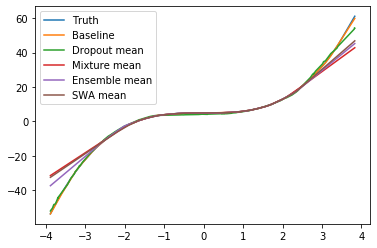

In [21]:
plt.figure()
plt.plot(data_tuple[2][arr1inds,0],data_tuple[2][arr1inds,1],label='Truth')
plt.plot(data_tuple[2][arr1inds,0],baseline[arr1inds,0],label='Baseline')
plt.plot(data_tuple[2][arr1inds,0],dropout_mean[arr1inds,0],label='Dropout mean')
plt.plot(data_tuple[2][arr1inds,0],mixture_mean[arr1inds,0],label='Mixture mean')
plt.plot(data_tuple[2][arr1inds,0],ensemble_mean[arr1inds,0],label='Ensemble mean')
plt.plot(data_tuple[2][arr1inds,0],swa_mean[arr1inds,0],label='SWA mean')
plt.legend()
plt.ylim()
plt.show()

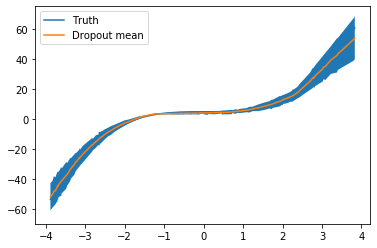

In [22]:
plt.figure()
plt.plot(data_tuple[2][arr1inds,0],data_tuple[2][arr1inds,1],label='Truth')
plt.plot(data_tuple[2][arr1inds,0],dropout_mean[arr1inds,0],label='Dropout mean')
plt.fill_between(x=data_tuple[2][arr1inds,0],y1=dropout_mean[arr1inds,0]-3*dropout_std[arr1inds,0],y2=dropout_mean[arr1inds,0]+3*dropout_std[arr1inds,0])
plt.legend()
plt.ylim()
plt.show()

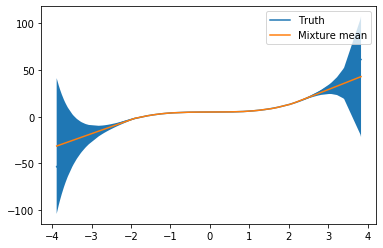

In [23]:
plt.figure()
plt.plot(data_tuple[2][arr1inds,0],data_tuple[2][arr1inds,1],label='Truth')
plt.plot(data_tuple[2][arr1inds,0],mixture_mean[arr1inds,0],label='Mixture mean')
plt.fill_between(x=data_tuple[2][arr1inds,0],y1=mixture_mean[arr1inds,0]-3*mixture_std[arr1inds,0],y2=mixture_mean[arr1inds,0]+3*mixture_std[arr1inds,0])
plt.legend()
plt.ylim()
plt.show()

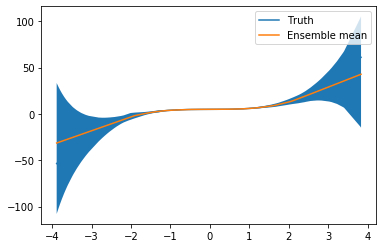

In [24]:
plt.figure()
plt.plot(data_tuple[2][arr1inds,0],data_tuple[2][arr1inds,1],label='Truth')
plt.plot(data_tuple[2][arr1inds,0],mixture_mean[arr1inds,0],label='Ensemble mean')
plt.fill_between(x=data_tuple[2][arr1inds,0],y1=ensemble_mean[arr1inds,0]-3*ensemble_std[arr1inds,0],y2=ensemble_mean[arr1inds,0]+3*ensemble_std[arr1inds,0])
plt.legend()
plt.ylim()
plt.show()

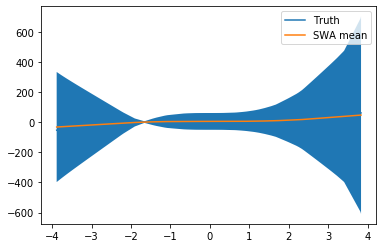

In [25]:
plt.figure()
plt.plot(data_tuple[2][arr1inds,0],data_tuple[2][arr1inds,1],label='Truth')
plt.plot(data_tuple[2][arr1inds,0],swa_mean[arr1inds,0],label='SWA mean')
plt.fill_between(x=data_tuple[2][arr1inds,0],y1=swa_mean[arr1inds,0]-3*swa_std[arr1inds,0],y2=swa_mean[arr1inds,0]+3*swa_std[arr1inds,0])
plt.legend()
plt.ylim()
plt.show()